# PHYS 6260: Homework 3, C. Michael Haynes

In [2]:
# generic list of import statements to not have to keep track
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import constants
import math as m
import warnings
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings( "ignore")

## Problem 1
### Laplace's equation: 2-D Model of an Electronic Capacitor

We use the relaxation (Jacobi) method to solve Laplace's equation for the capacitor specified. This takes advantage of the laplace operator's "averaging" nature, using the surrounding grid points to update each one. This method does NOT correspond to time evolution (unless it is perscribed through the boundary values, similar to problem 2); rather, the iterations are converging towards a steady-state "snapshot" of the capacitor at a single instant in time (or, when it is fully charged with a steady voltage and the potential field does not change).

The Jacobi method relates the potential $\phi$ at a point $(x,y)$ to the average of its neighbors, i.e.:
$$ \phi(x,y) = \frac{1}{4} \left [ \phi(x + \epsilon,y) + \phi(x - \epsilon,y) + \phi(x, y+ \epsilon) + \phi(x, y - \epsilon) \right ] $$
for a grid spacing $\epsilon$. We take advantage of this method and the routine learned in class to calculate the solution to Laplace's equation (or Poisson's equation in a charge-free environment):
$$ \nabla^2 \phi = 0$$

In [2]:
# Define parameters
V = 1.0         # Voltage for capacitor plates (+/-)
target = 1.e-06   # requested precision of 1 uV
M = 100         # Grid side number of points
L = 10.         # side length in centimeters
dl = L/M        # grid spacing in centimeters

# Create arrays to hold potential values, as done in class: [x_idx, y_idx]
phi = np.zeros([M+1,M+1],float)
phiprime = np.empty([M+1,M+1],float)

# calculate indices for array slicing to enforce Voltage values
pV_Xidx = int(2./dl)
nV_Xidx = int(8./dl)
# pV_Yidx = nV_Yidx = pV_Xidx:nV_Xidx

# set positive plate
phi[pV_Xidx,pV_Xidx:nV_Xidx] = V
# set negative plate
phi[nV_Xidx,pV_Xidx:nV_Xidx] = -V


delta = 1.0
iteration = 0
while delta>target:

    # Calculate new values of the potential
    phiprime[0,:] = phi[0,:]
    phiprime[-1,:] = phi[-1,:]
    phiprime[:,0] = phi[:,0]
    phiprime[:,-1] = phi[:,-1]
    
    phiprime[1:M,1:M] = (1./4.) * (phi[2:,1:M] + phi[:M-1,1:M] + phi[1:M,2:] + phi[1:M,:M-1])

    # enforce voltages on the plates
    phiprime[nV_Xidx,pV_Xidx:nV_Xidx] = phi[nV_Xidx,pV_Xidx:nV_Xidx]
    phiprime[pV_Xidx,pV_Xidx:nV_Xidx] = phi[pV_Xidx,pV_Xidx:nV_Xidx]
    
#    for i in range(M+1):
#        for j in range(M+1):
#            if i==0 or i==M or j==0 or j==M:
#                phiprime[i,j] = phi[i,j]
#            else:
#                phiprime[i,j] = 0.25*(phi[i+1,j] + phi[i-1,j] \
#                                      + phi[i,j+1] + phi[i,j-1])

    # Calculate maximum difference from old values
    delta = np.max(abs(phi-phiprime))
    if iteration % 100 == 0:
        print("Iteration %3d: max. residual = %12.6g" % (iteration, delta))

    # Swap the two arrays around
    phi,phiprime = phiprime,phi
    iteration += 1

# transpose the solution to obtain proper coordinates associated with the arrangement of the phi, phiprime arrays
phi = phi.T

Iteration   0: max. residual =         0.25
Iteration 100: max. residual =   0.00239703
Iteration 200: max. residual =   0.00120217
Iteration 300: max. residual =  0.000793906
Iteration 400: max. residual =   0.00057422
Iteration 500: max. residual =   0.00042632
Iteration 600: max. residual =   0.00031856
Iteration 700: max. residual =  0.000238398
Iteration 800: max. residual =  0.000178556
Iteration 900: max. residual =  0.000133849
Iteration 1000: max. residual =   0.00010037
Iteration 1100: max. residual =  7.52813e-05
Iteration 1200: max. residual =  5.64678e-05
Iteration 1300: max. residual =  4.23548e-05
Iteration 1400: max. residual =  3.17658e-05
Iteration 1500: max. residual =  2.38205e-05
Iteration 1600: max. residual =  1.78593e-05
Iteration 1700: max. residual =  1.33873e-05
Iteration 1800: max. residual =  1.00331e-05
Iteration 1900: max. residual =  7.51794e-06
Iteration 2000: max. residual =  5.63225e-06
Iteration 2100: max. residual =  4.21885e-06
Iteration 2200: max.

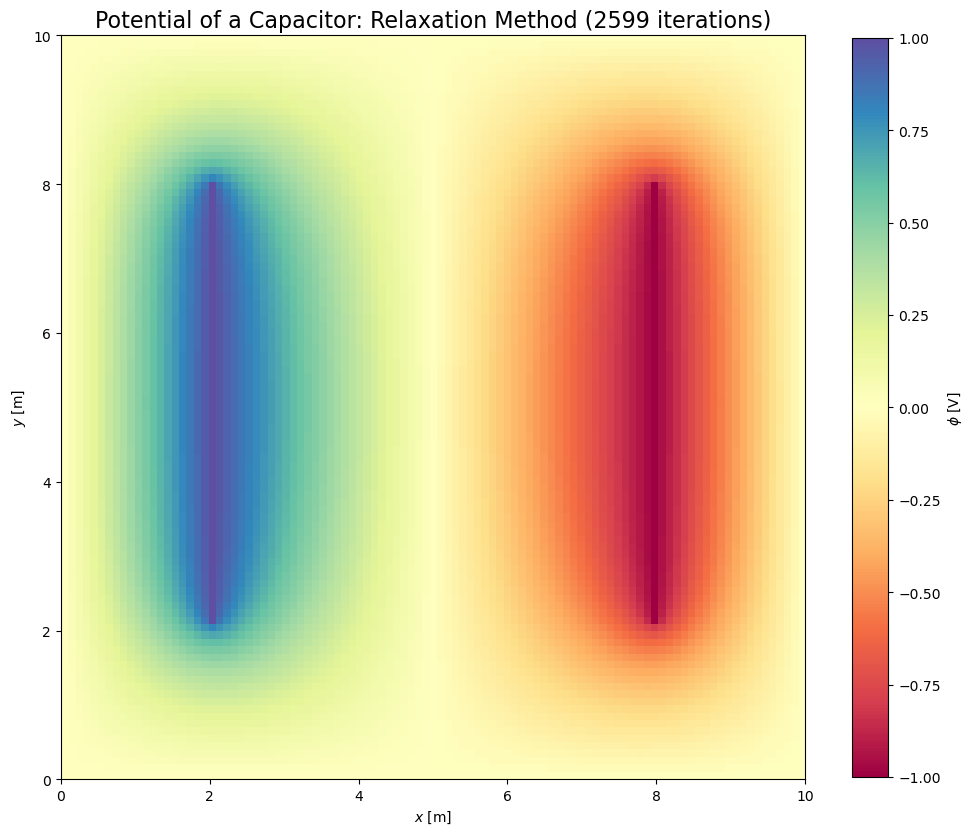

In [3]:
fig, ax = plt.subplots(figsize=(12,12))
f1 = ax.imshow(phi, extent=[0,10,0,10], cmap='Spectral')
ax.set_xlabel(r'$x$ [m]')
ax.set_ylabel(r'$y$ [m]')
fig.colorbar(f1,label=r'$\phi$ [V]', shrink=0.8)
plt.title('Potential of a Capacitor: Relaxation Method ('+str(iteration)+' iterations)',fontsize=16)
plt.show()

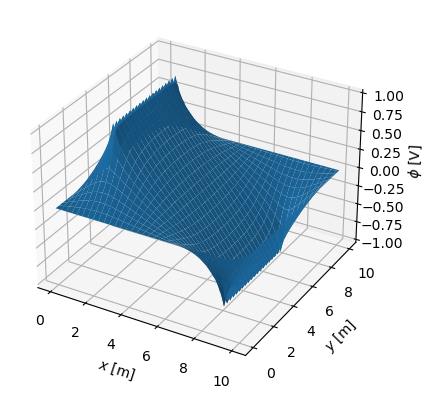

In [4]:
from mpl_toolkits.mplot3d import Axes3D  

x_cap = y_cap = np.arange(start=0,stop=L+dl,step=dl)
Xcap, Ycap = np.meshgrid(x_cap, y_cap)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(Xcap, Ycap, phi)

ax.set_xlabel(r'$x$ [m]')
ax.set_ylabel(r'$y$ [m]')
ax.set_zlabel(r'$\phi$ [V]')

plt.show()


## Problem 2
### Heat equation: Thermal diffusion in Earth’s crust
We wish to calculate the temperature profile as a function of depth in Earth's crust and time over the course of many years. To do so, we implement a numerical tool to calculate a solution for the Heat (diffusion) equation on a prescribed grid mesh. 

Using a time-variable boundary condition for the terrestrial surface temperature, we can emulate the the temperature due to variablility in solar radiation over a point on Earth's surface throughout its orbit. The functional form of the time-dependent boundary value is given by 
$$ T_0(t) = A + B\sin{\left(\frac{2\pi t}{\tau}\right)} \qquad , $$
where $A=10^\circ$ C, $B=12^\circ$, and $\tau=365 \,\mathrm{d}$. We treat the Earth's crust to have a roughly constant thermal diffusivity $D=0.1\,\mathrm{m}^2\,\mathrm{d}^{-1}$. At a depth of $20\,\mathrm{m}$ below the surface, the temperature is approximately constant as a function of time due to the internal heat generated in Earth's core and transported outward by the mantle. Thus, we have two Dirichlet boundary conditions (i.e., perscribed values) at either end of the spatial domain, and the time variability is encoded via our time-dependent boundary condition. We initialize the spatial domain with a constant temperature of $10^\circ $ everywhere inside of the boundaries.

In [5]:

tau = 365   # days / year
eta = 0.1   # m^2 / day

## Modulating Parameters ##
A = 10.     # deg Celsius
B = 12.     # deg Celsius
BC_inner = 11.  # deg Celsius
dz = 0.1    # meters
#############################

## calculate timestep to fulfill stability condition, namely     (eta * dt / dx^2) < 1/2
# Set this parameter to choose the threshold below stability to modulate timestep,  **ranges (1,infty)**
# effectively the factor by which dt would need to be multiplied to make the stability condition equation an equality
timestep_threshold = 1.01
# calculate timestep
dt = (dz ** 2)/(2.*eta)
dt /= timestep_threshold
## this gives timestep in DAYS
print("\n\nTimestep in days: "+str(round(dt,5))+"\n")
# convert to years
dt /= tau

## compute D (stability criterion)
D_coef = (eta*dt*tau) / (dz ** 2)

## initialize coordinates
depth_arr = np.arange(start=0,stop=20.,step=dz)
num_spatial_steps = len(depth_arr)
time_arr = np.arange(start=0.,stop=10.,step=dt)
num_timesteps = len(time_arr)


## Time dependent surface boundary condition
def BC_t(t):
    return (A + B*np.sin((2*m.pi)*t))

## initialize IC
depth_IC = np.full(num_spatial_steps,10.)   # set all values to 10 deg Celsius
depth_IC[0] = BC_t(0.)
depth_IC[-1]= 11.

Temp_profile = depth_IC.copy()
newTemp_profile = np.zeros(num_spatial_steps)
timeDependent_Temp_profile = [Temp_profile.copy()]

## START SOLVER
for n in range(num_timesteps):
    for j in range(num_spatial_steps):
        if j == 0:
            newTemp_profile[j] = BC_t(n*dt)
        elif j == num_spatial_steps-1 :
            newTemp_profile[j] = BC_inner
        else:
            newTemp_profile[j] = Temp_profile[j] + D_coef*(Temp_profile[j+1] - 2*Temp_profile[j] + Temp_profile[j-1])
        

    timeDependent_Temp_profile.append(newTemp_profile.copy())
    Temp_profile = newTemp_profile.copy()

## plotting and visualization

dt_per_year = 1 // dt
dt_inc = dt_per_year // 4

#print(dt_per_year)



Timestep in days: 0.0495



Here we plot the specified quantities: for final (10th) year, we plot four temperature profiles taken at 3-month intervals on a single graph to illustrate how the temperature behaves as a function of depth and time. Additionally, we include a colormap displaying the temperature evolution. 

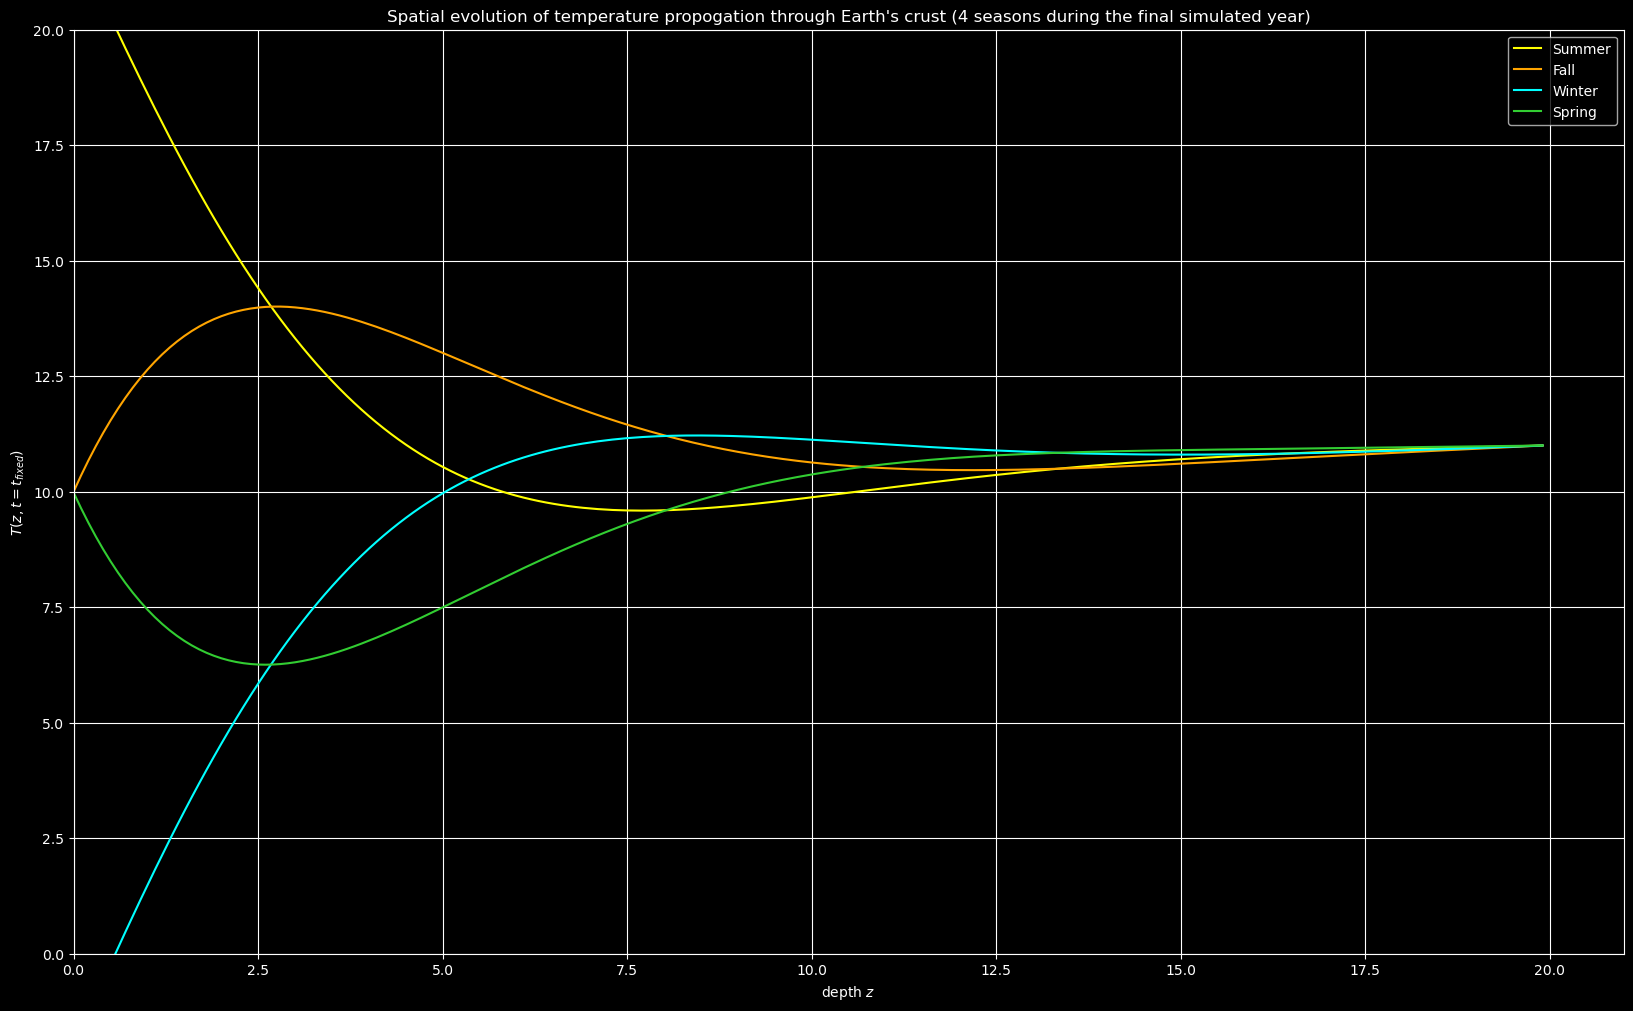

In [6]:
plt.style.use('dark_background')


plot_1 = timeDependent_Temp_profile[num_timesteps-1][:]
plot_2 = timeDependent_Temp_profile[int(num_timesteps-dt_inc)][:]
plot_3 = timeDependent_Temp_profile[int(num_timesteps-(2*dt_inc))][:]
plot_4 = timeDependent_Temp_profile[int(num_timesteps-(3*dt_inc))][:]




x_grid = np.arange(start=0,stop=20.1,step=dz)

## plot of solution
fig, ax = plt.subplots(figsize=(20,12))

plt.plot(depth_arr, plot_4,label='Summer',color='yellow')
plt.plot(depth_arr, plot_3,label='Fall', color='orange')
plt.plot(depth_arr, plot_2,label='Winter',color='cyan')
plt.plot(depth_arr, plot_1,label='Spring',color='limegreen')


plt.xlim(0,21)
plt.ylim(0,20)

plt.legend()
plt.grid()
plt.xlabel("depth $z$")
plt.ylabel("$T(z,t=t_{fixed})$")
plt.title("Spatial evolution of temperature propogation through Earth's crust (4 seasons during the final simulated year)")
plt.show()

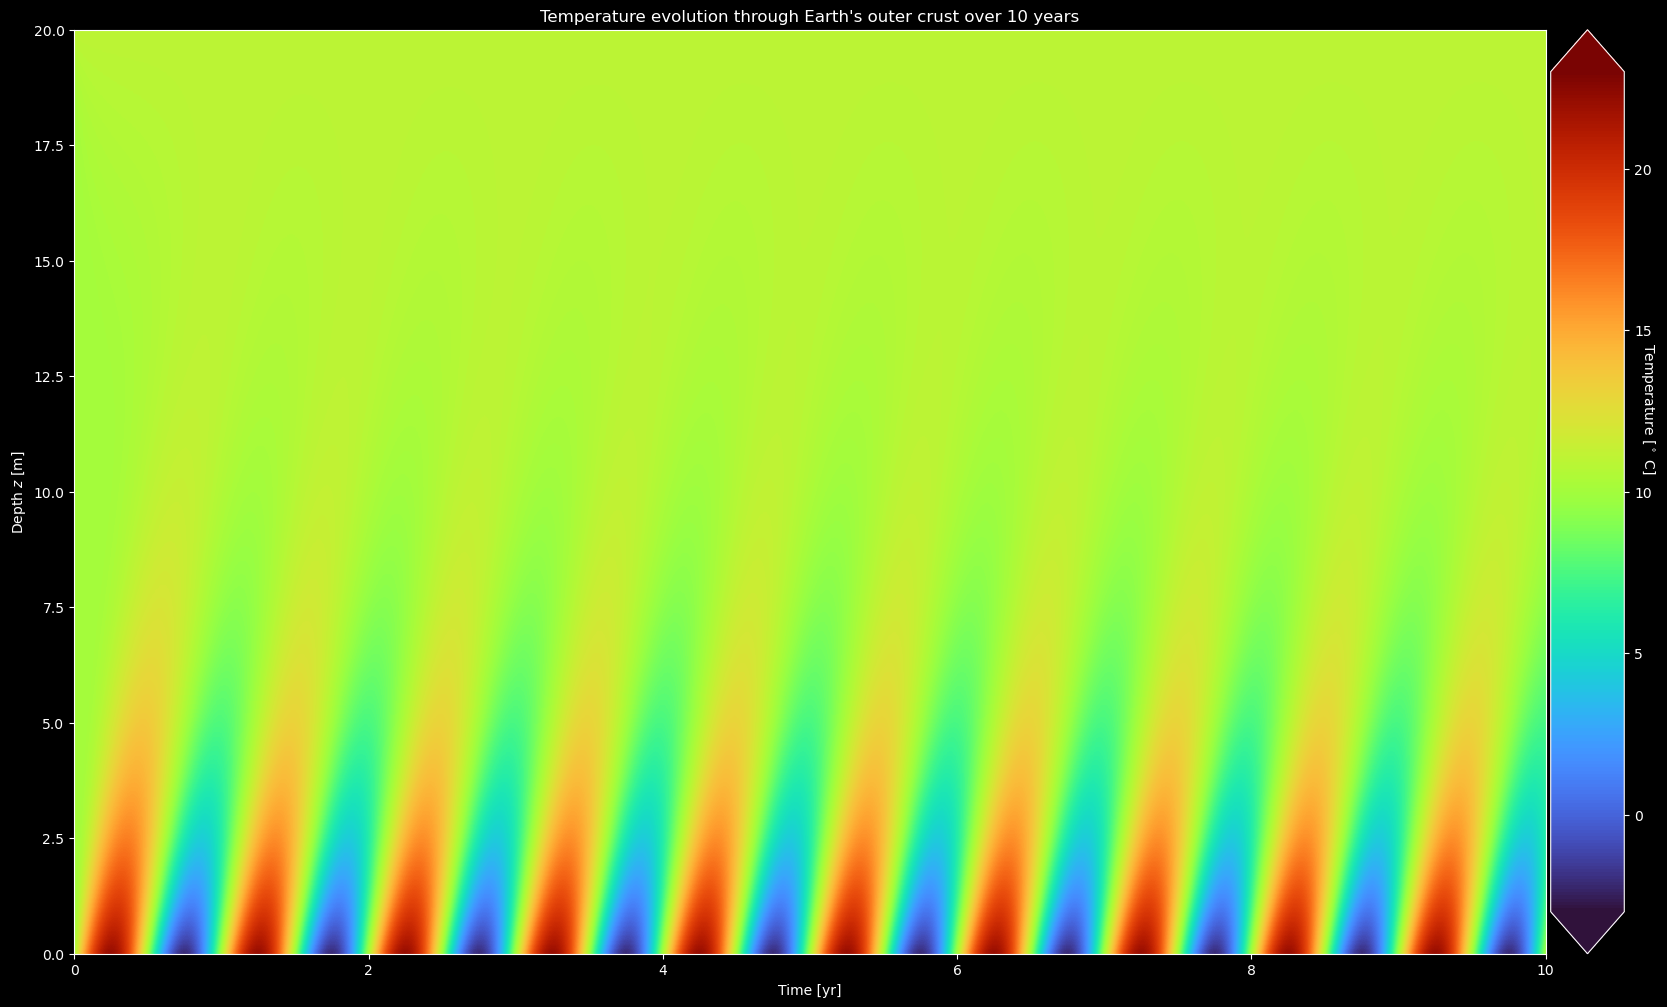

In [7]:
plt.figure(figsize=(20,12))
ax = plt.gca()

#fig1 = plt.imshow(timeDependent_Temp_profile, extent = [0,360, -90,90], origin = 'lower', cmap = 'viridis',interpolation='catrom', vmin = 0, vmax = maxel+1e2)
fig1 = plt.imshow(np.transpose(timeDependent_Temp_profile), origin = 'lower', cmap = 'turbo', vmin = -3, vmax = 23, aspect = 'auto', extent=[0,10,0, 20])


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

ax.set_ylabel('Depth $z$ [m]')
ax.set_xlabel('Time [yr]')

ax.set_title('Temperature evolution through Earth\'s outer crust over 10 years')
cbar = plt.colorbar(fig1,cax = cax, extend='both')
cbar.set_label('Temperature [$^\circ$ C]',y=0.6,rotation=270)
plt.show()

## Problem 3
### Wave equation 

#### (a) FTCS (Forward-time, Centered-spatial) Integration method: solving the wave equation

We wish to solve the wave equation in 1 spatial dimension, for a piano string the moment it is impulsed by a hammer (i.e., a single note being played). The string extends a length $L=1\,\mathrm{m}$, and the hammer strikes $d=10\,\mathrm{cm}$ from the left endpoint. We use the following expressions from lecture to reformulate the wave equation as a system of first order equations. We start with the wave equation in 1 dimension: 
$$ \partial_t^2 \phi = v^2 \partial_x^2 \phi $$
Discretizing using the FTCS method discussed in class:
$$ \partial_t^2 \phi = \left(\frac{v}{a}\right)^2 \left [ \phi(x+a,t) + \phi(x-a,t) - 2 \phi(x,t) \right ] \qquad ,$$
where $a$ is the separation used for the 1D spatial grid. Rewriting this as two first-order ODEs, we obtain two finite difference expressions we can iterate over to evolve the system through time and space:
$$\phi(x, t+h) = \phi(x,t) + h\psi(x,t) $$
$$ \psi(x,t+h) = \psi(x,t) + \frac{h v^2}{a^2} \left [ \phi(x+a,t) + \phi(x-a,t) - 2 \phi(x,t) \right ] $$
The initial values specified are given by:
$$ \phi(x,t=0) = 0 $$
$$ \psi(x,t=0) =  \frac{C x (L - x)}{L^2} e^{-\frac{(x-d)^2}{2 \sigma^2}} $$

_FYI, there is an error in the hw sheet: it references equations (6-9) from Lecture Notes #8, but should be (1-4) from Lecture Notes #7_

0.05
dt = 1e-07 s; dx = 0.002 m
reached time t=0.0


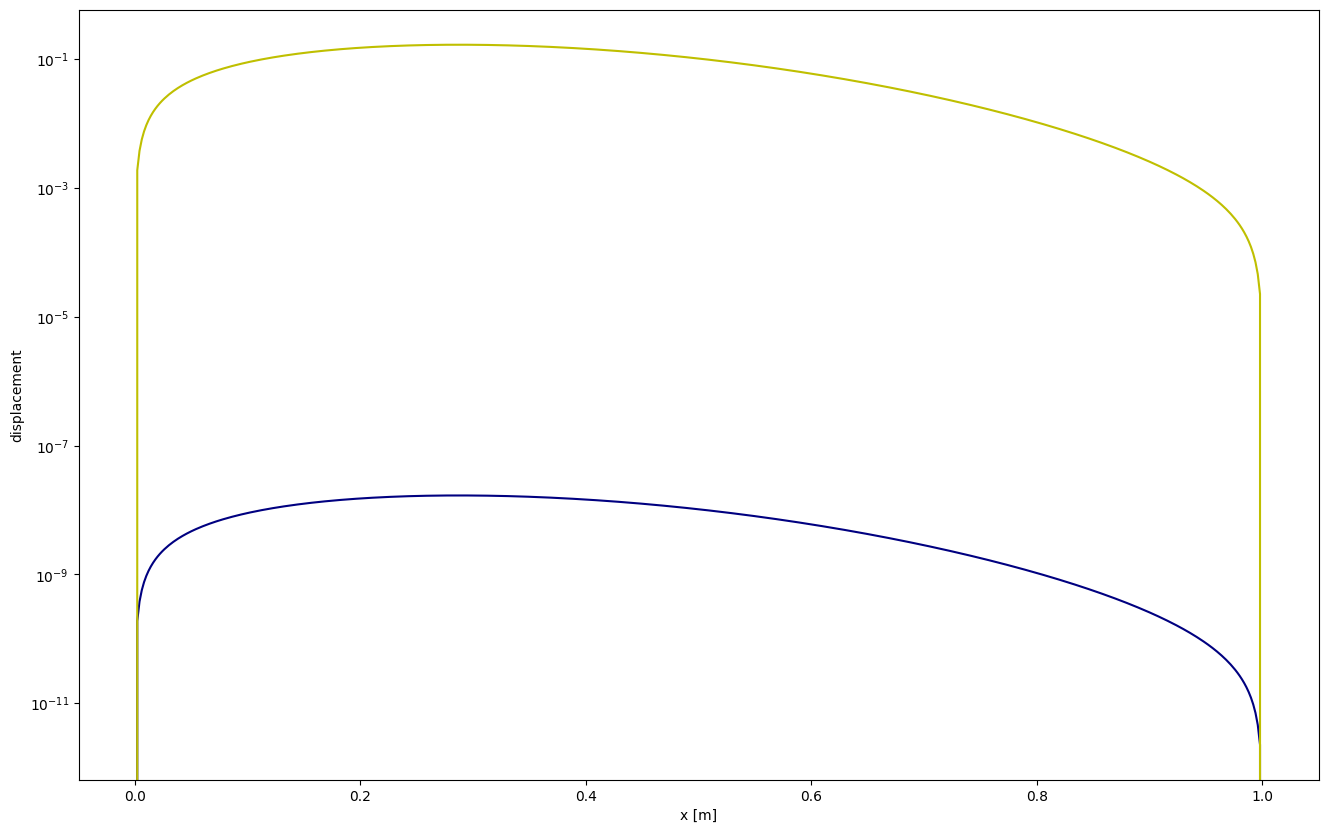

reached time t=0.00019999999999999998


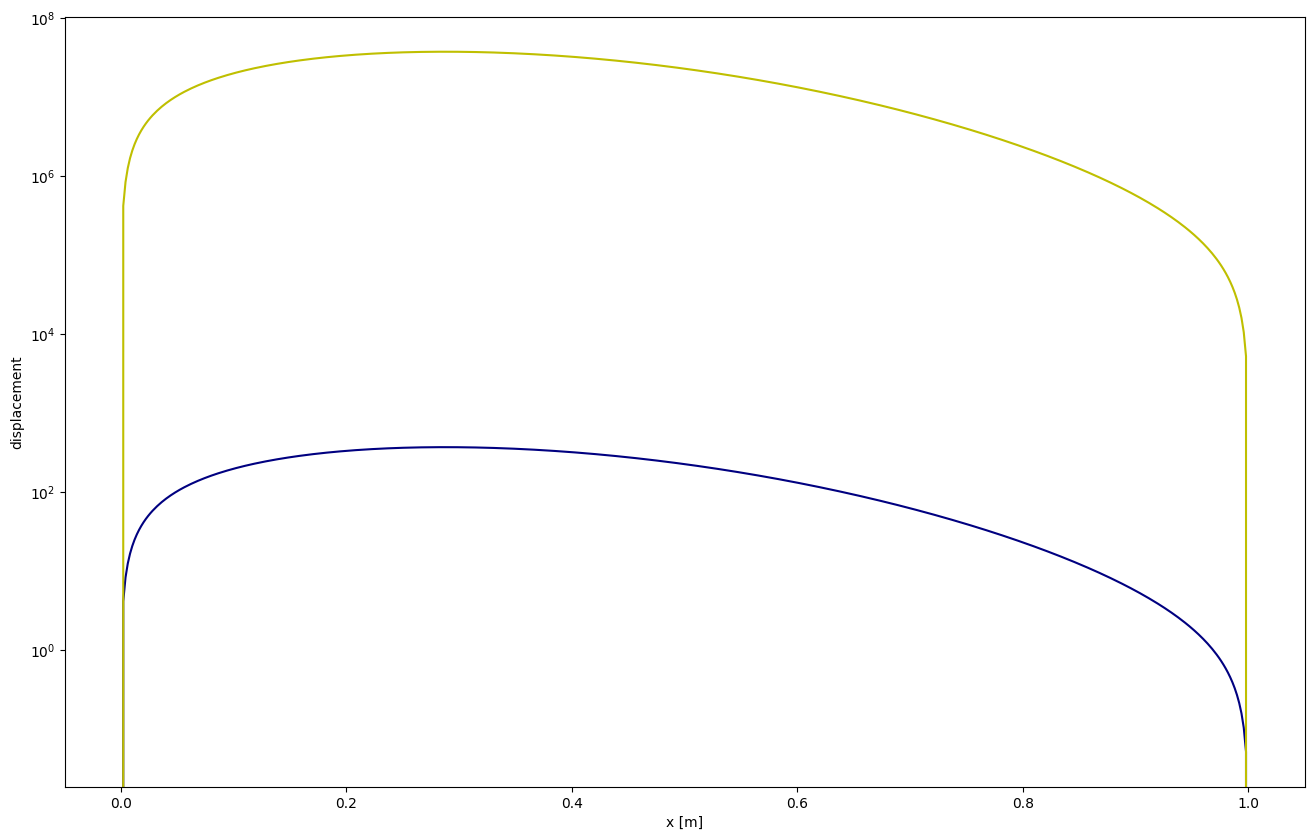

reached time t=0.00039999999999999996


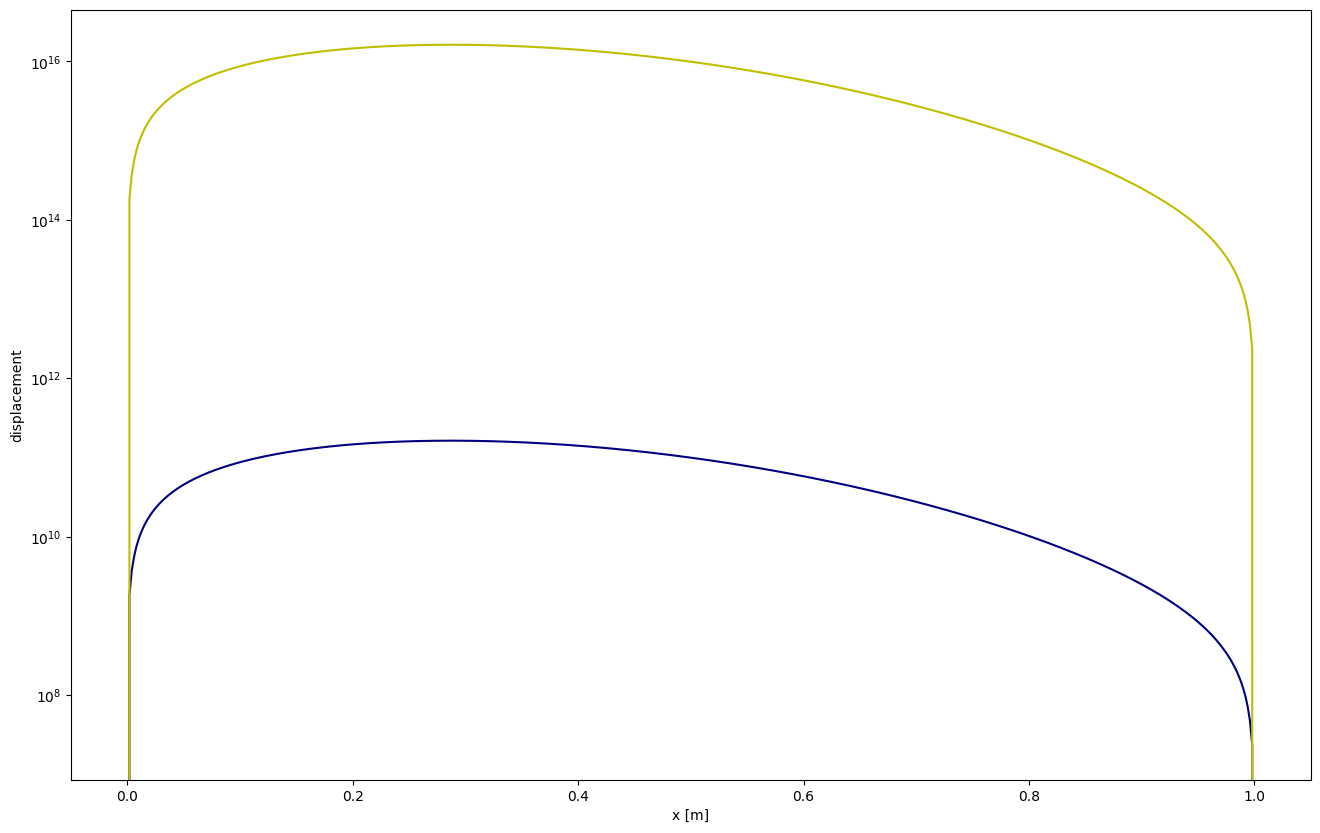

reached time t=0.0006


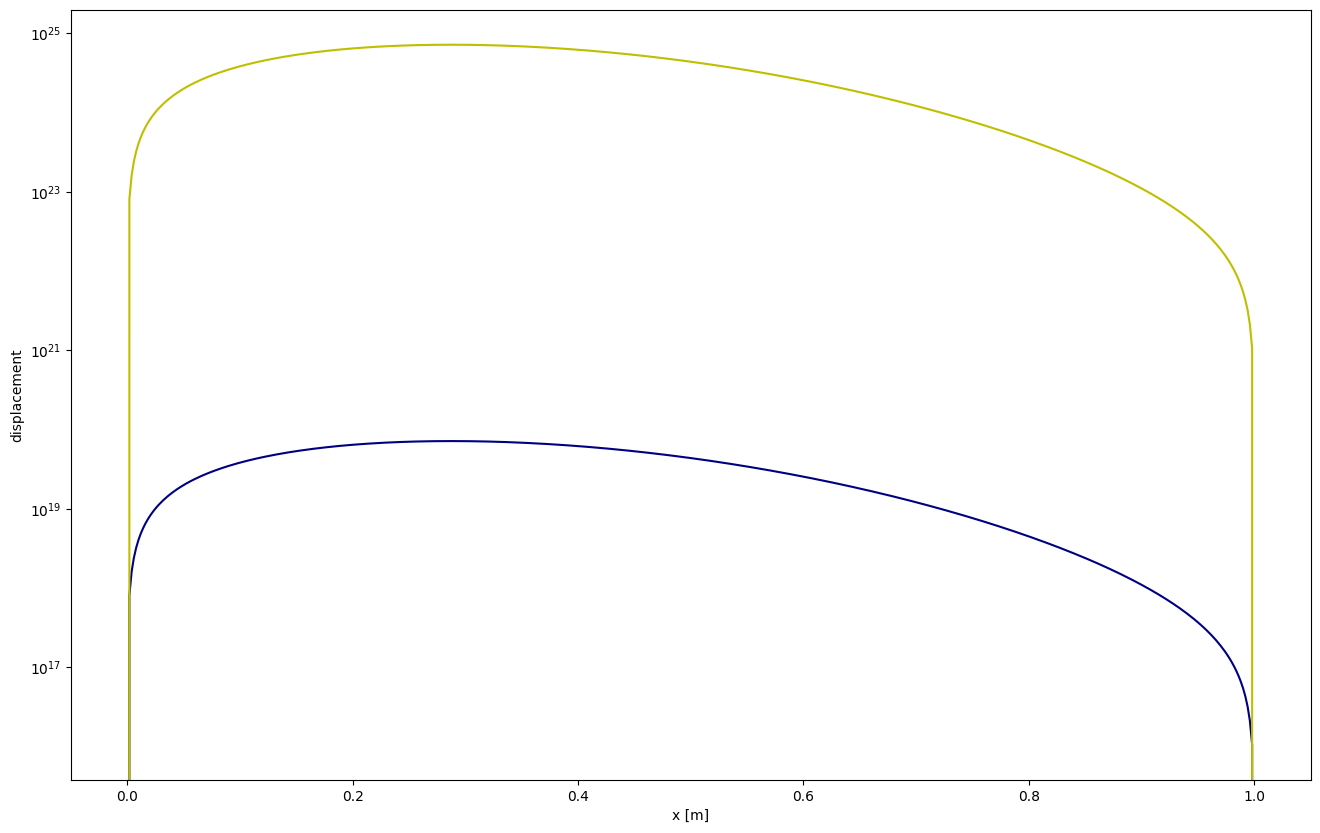

reached time t=0.0007999999999999999


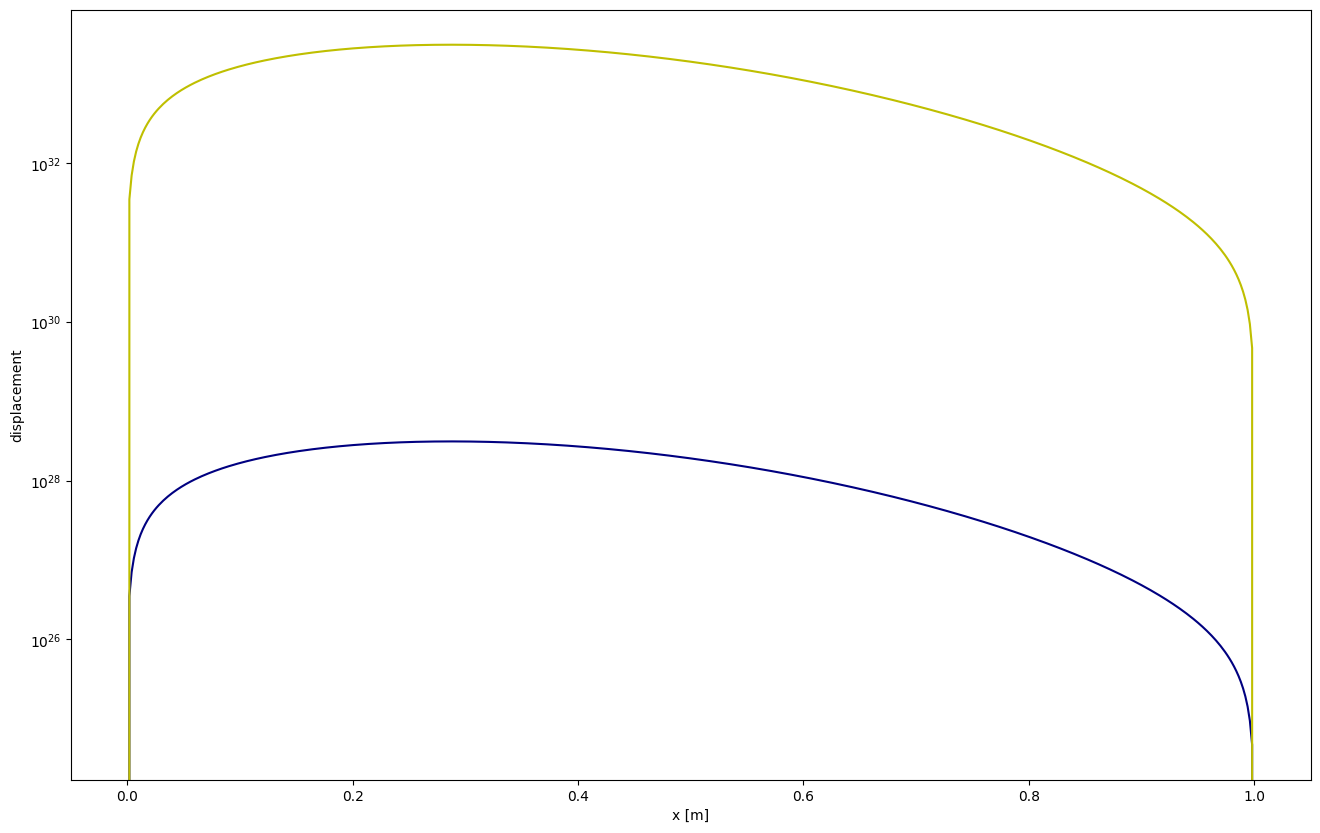

reached time t=0.001


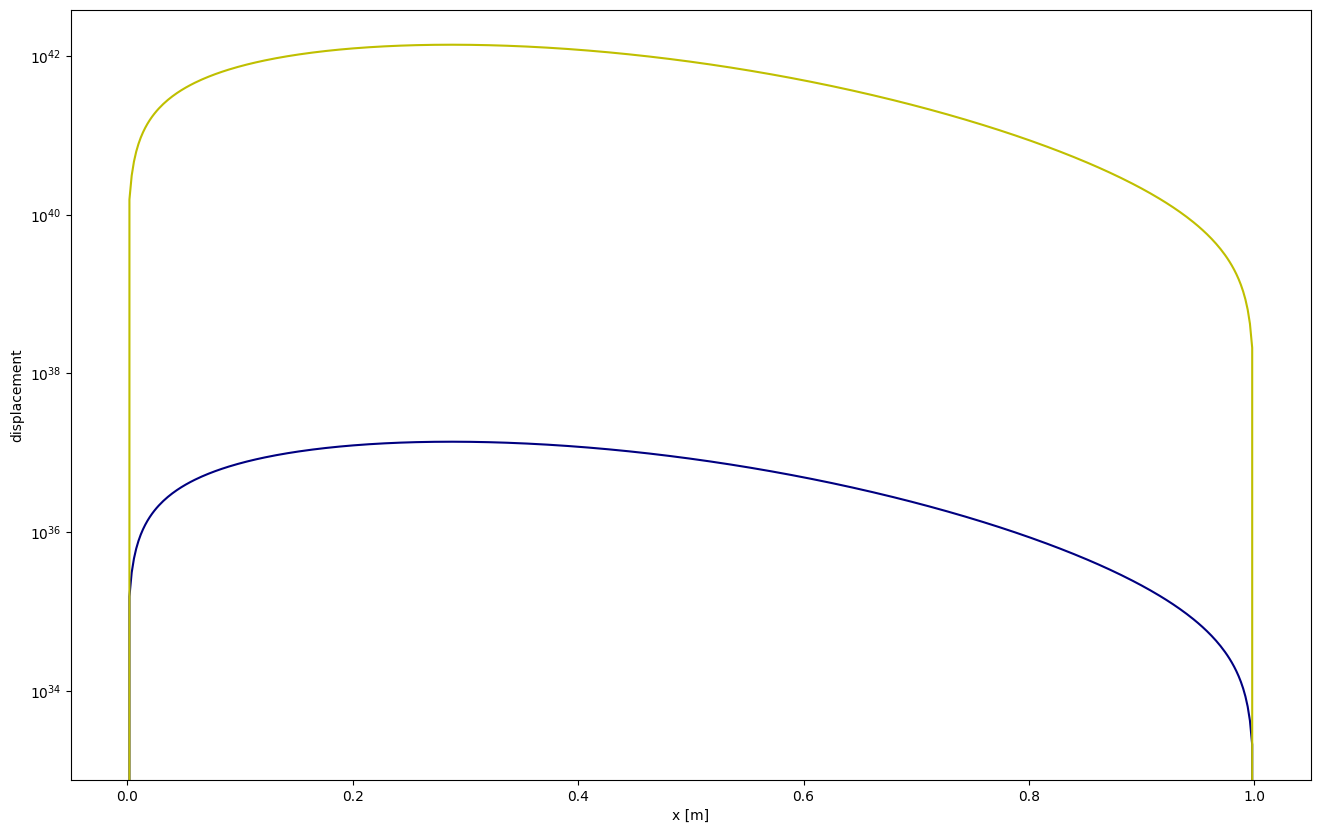

reached time t=0.0012


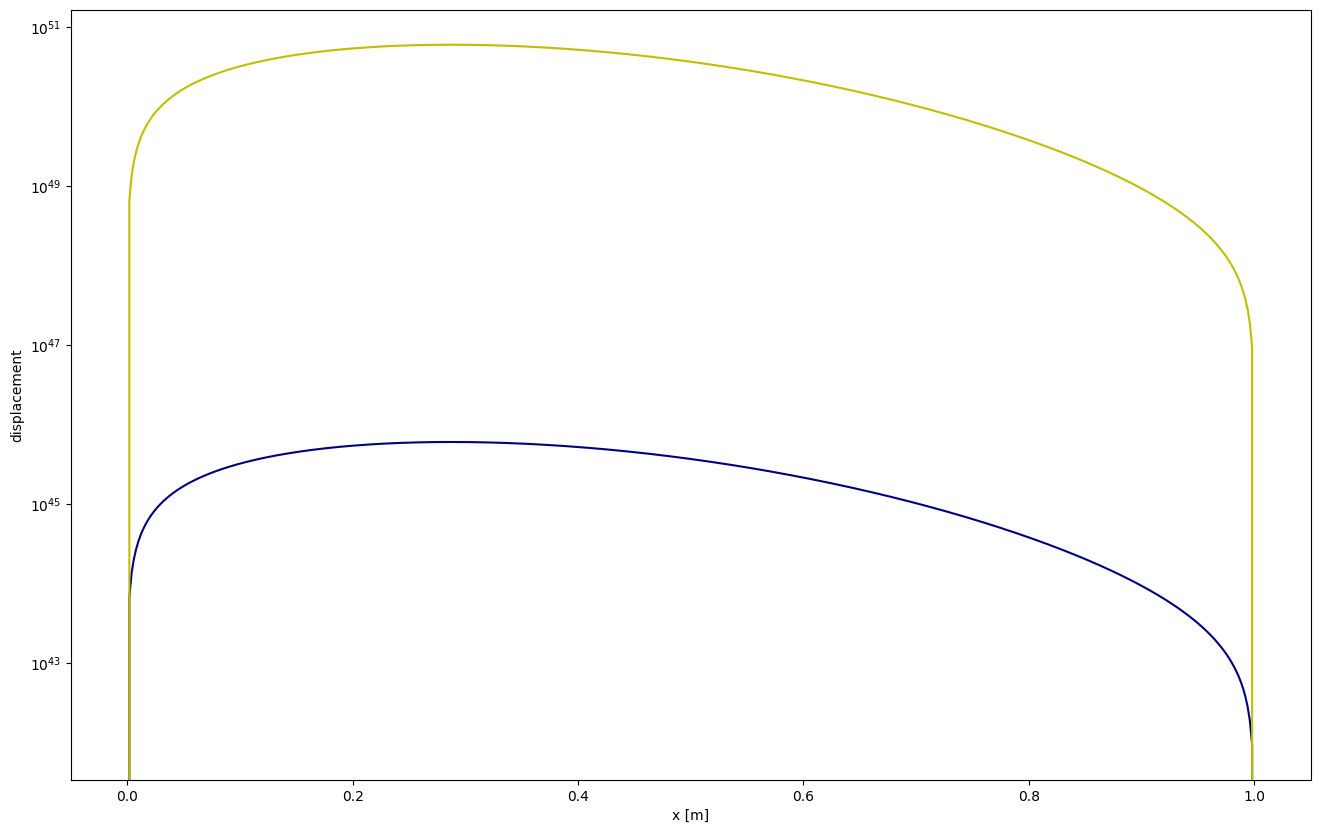

reached time t=0.0014


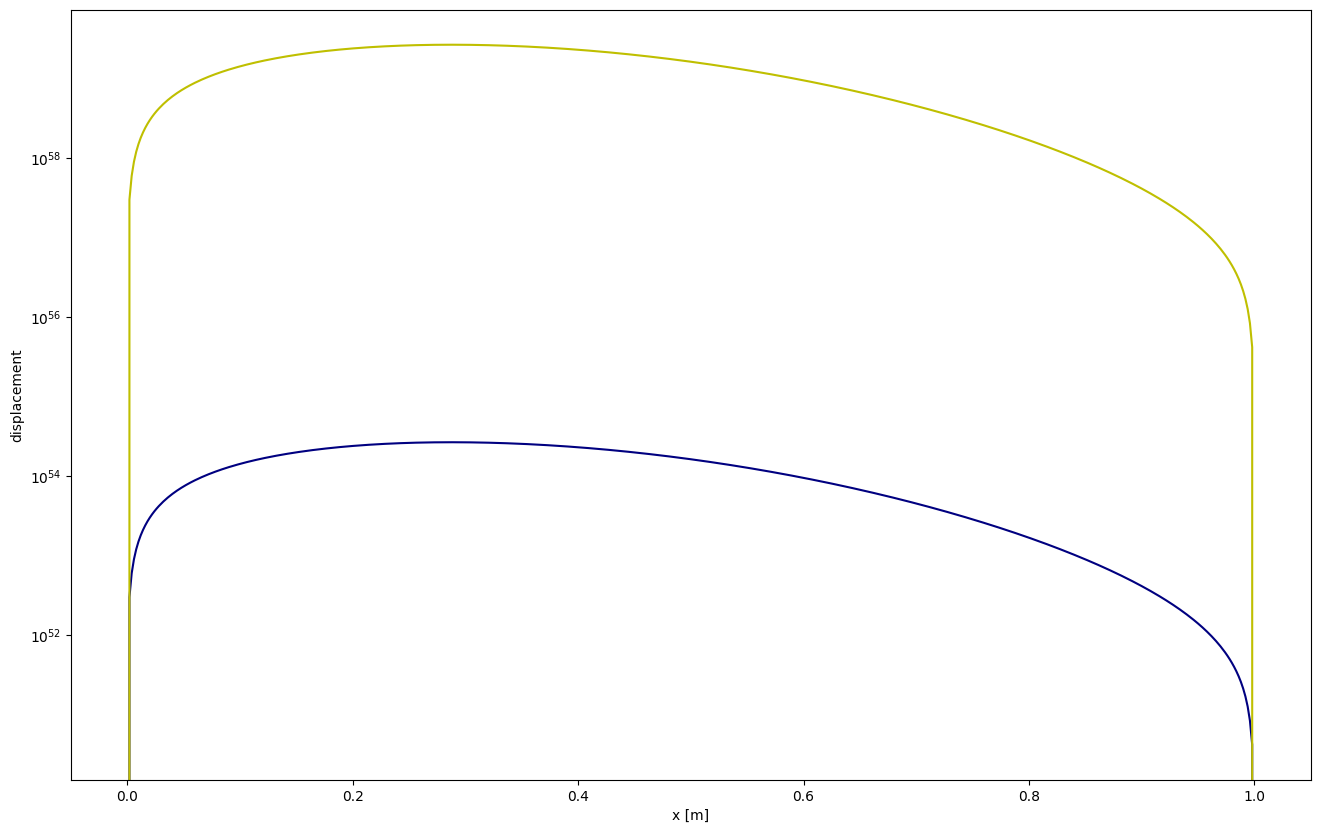

reached time t=0.0015999999999999999


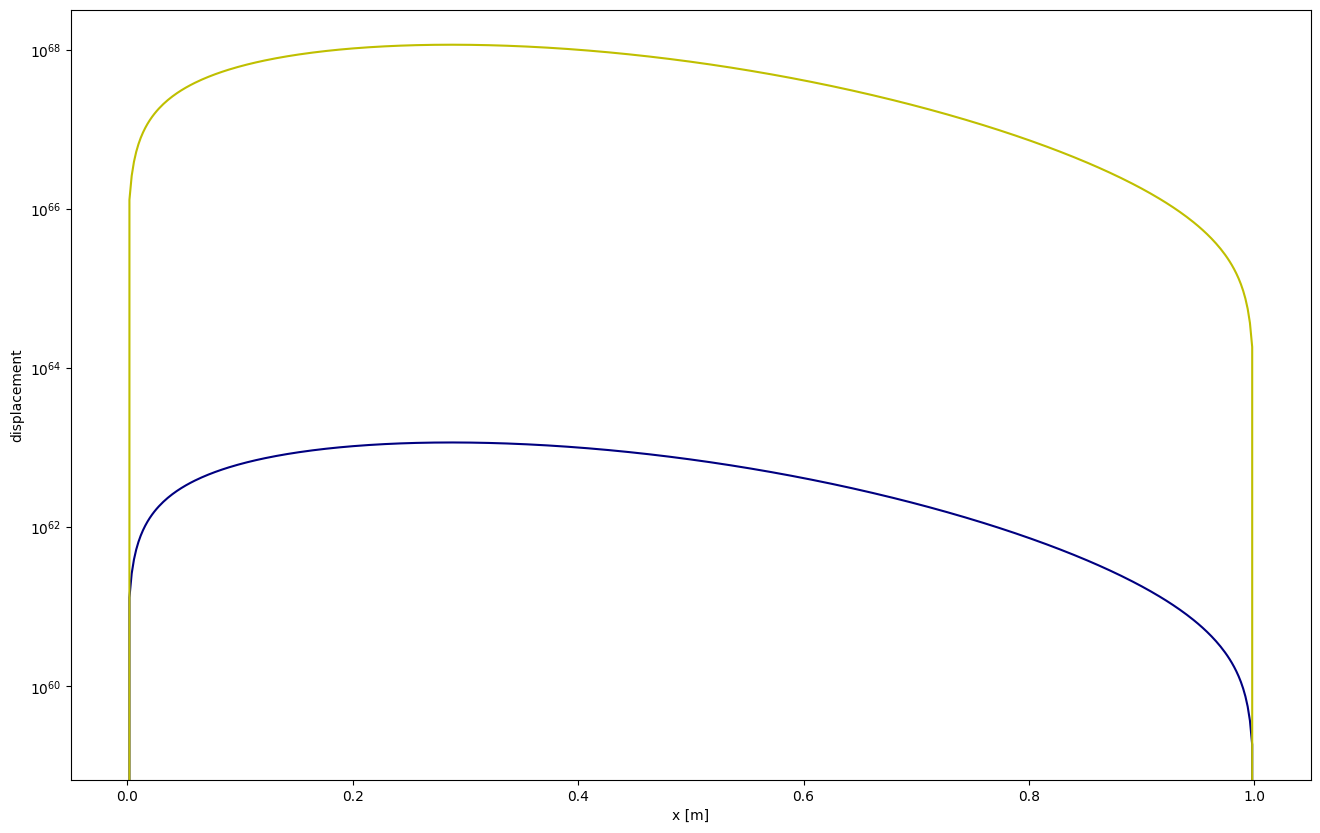

reached time t=0.0018


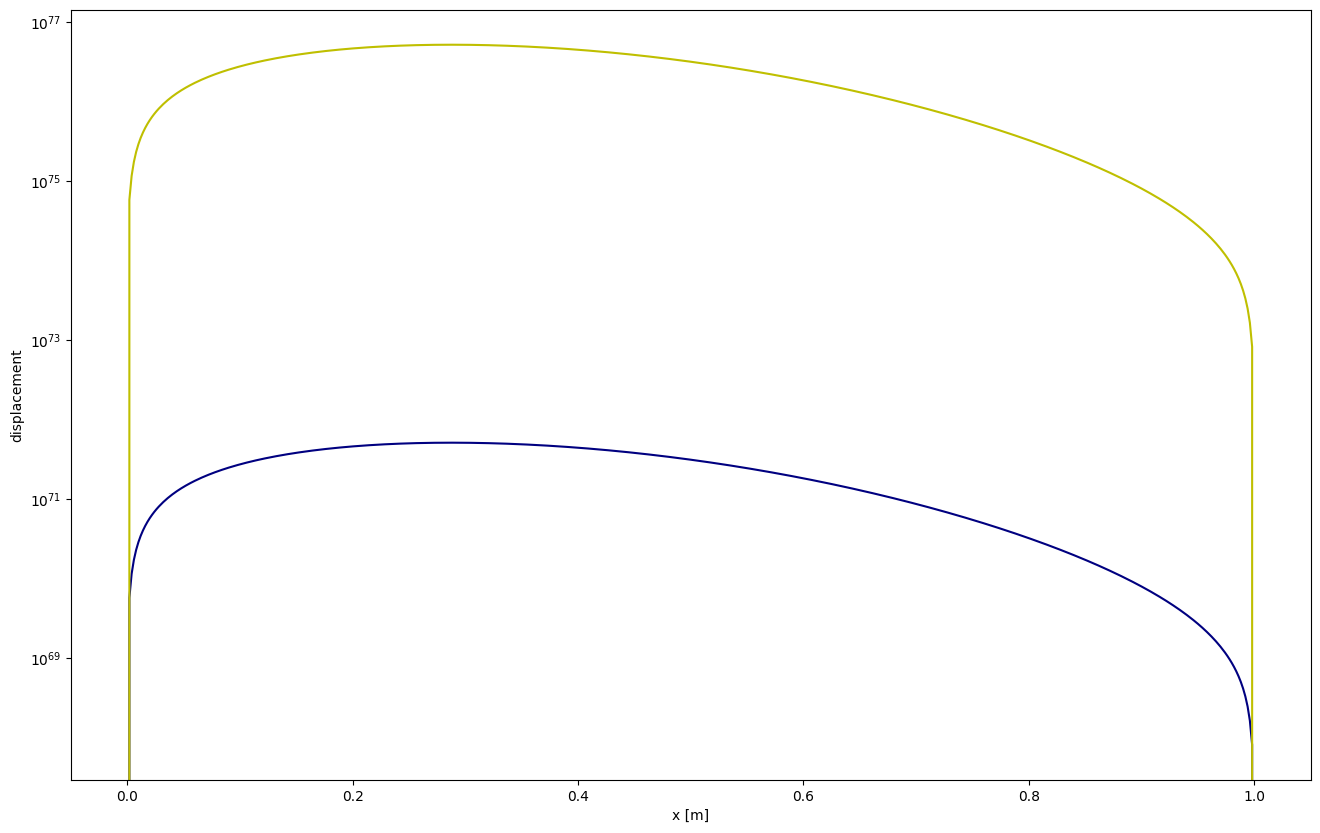

reached time t=0.002


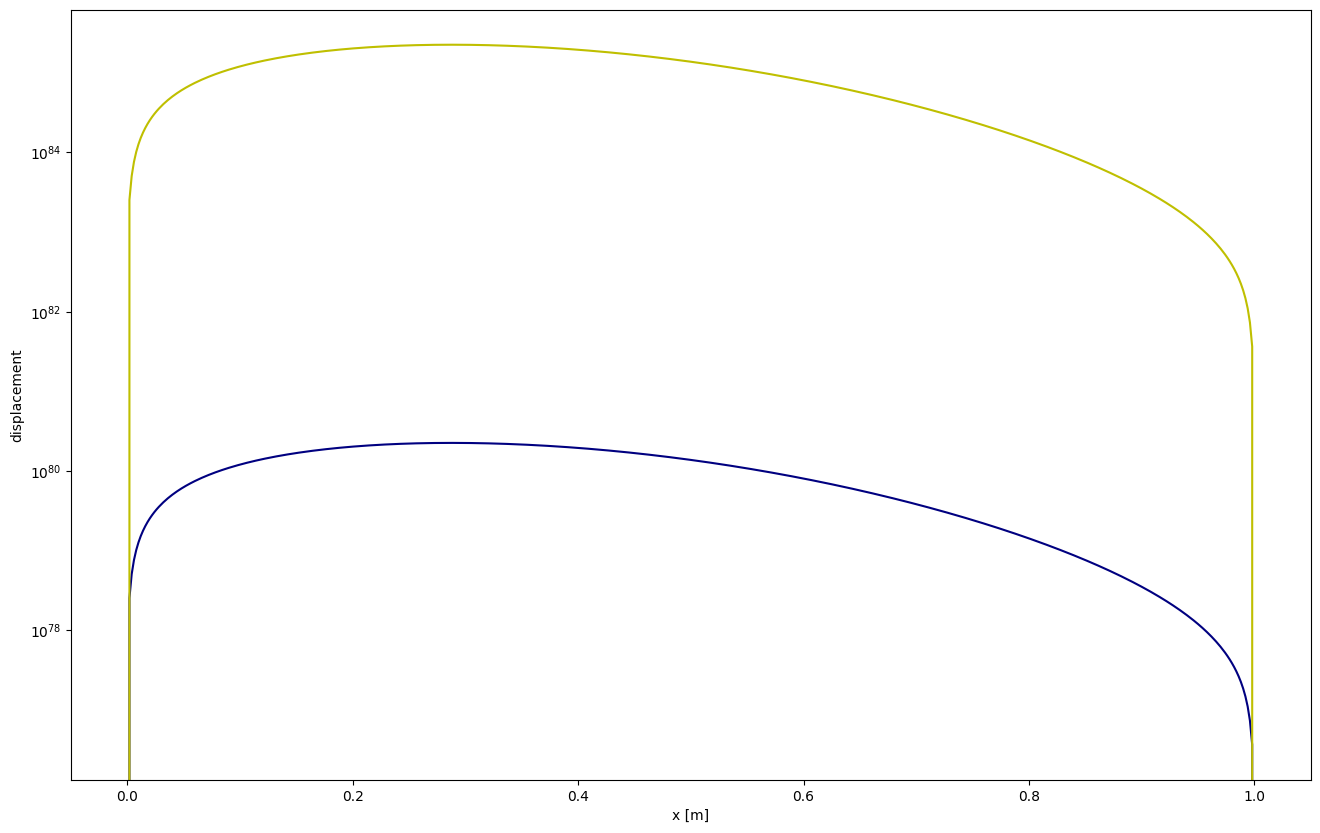

reached time t=0.0021999999999999997


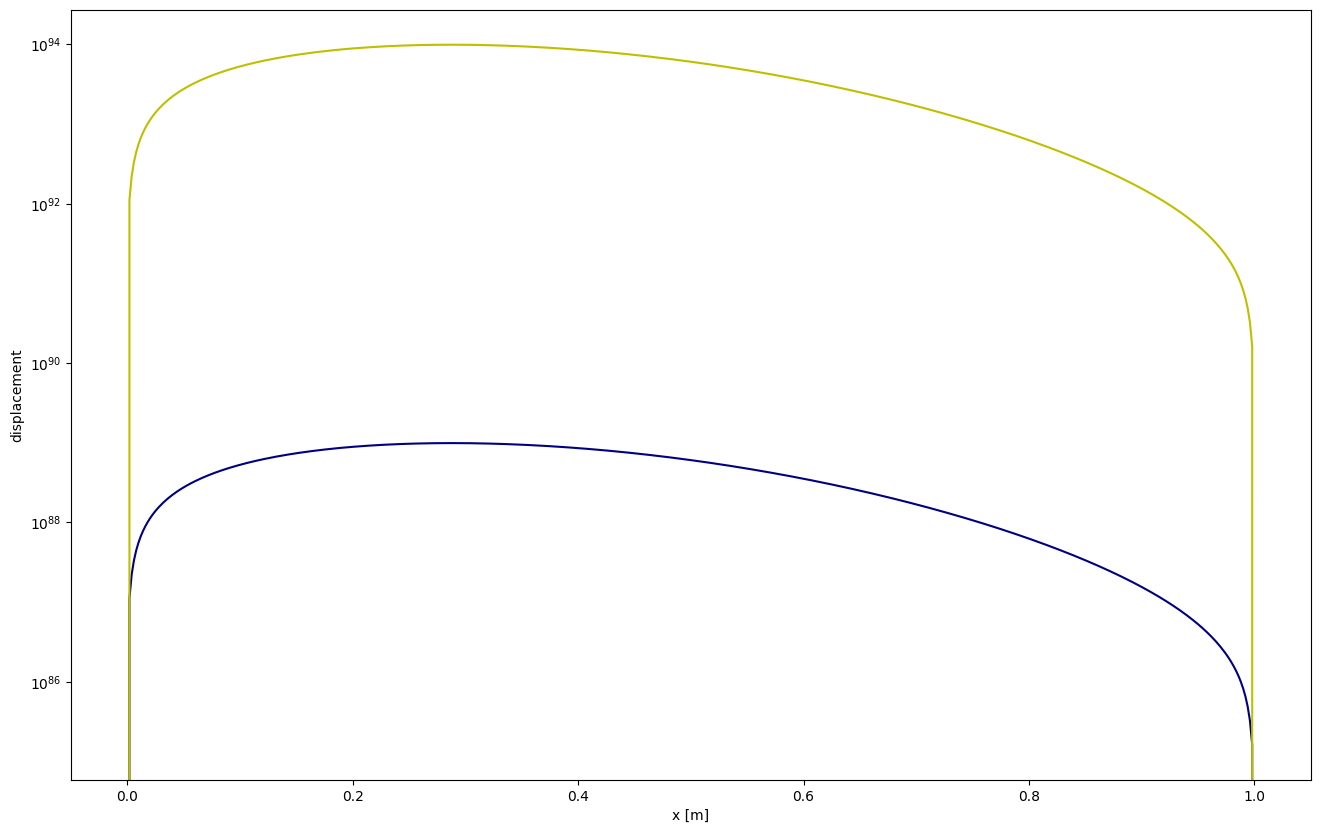

reached time t=0.0024


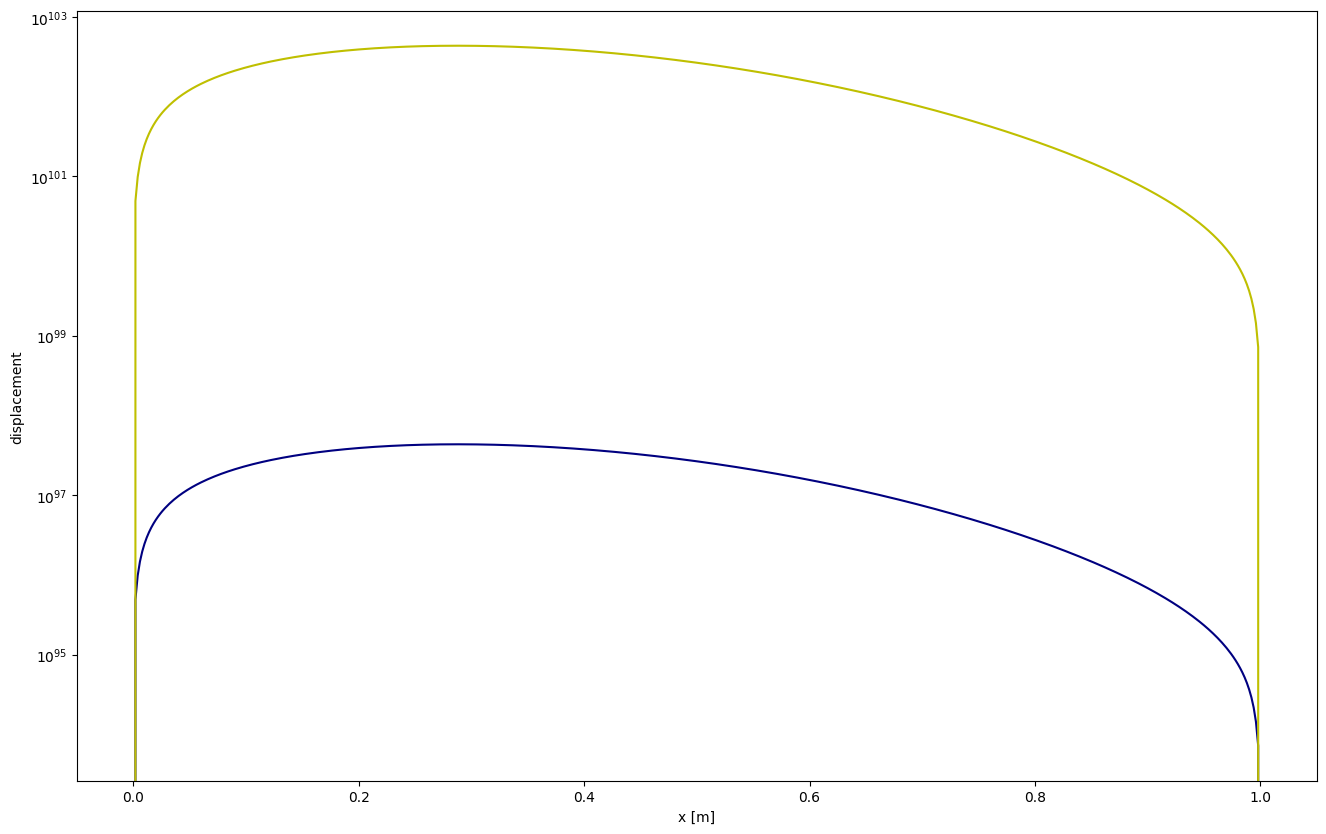

reached time t=0.0026


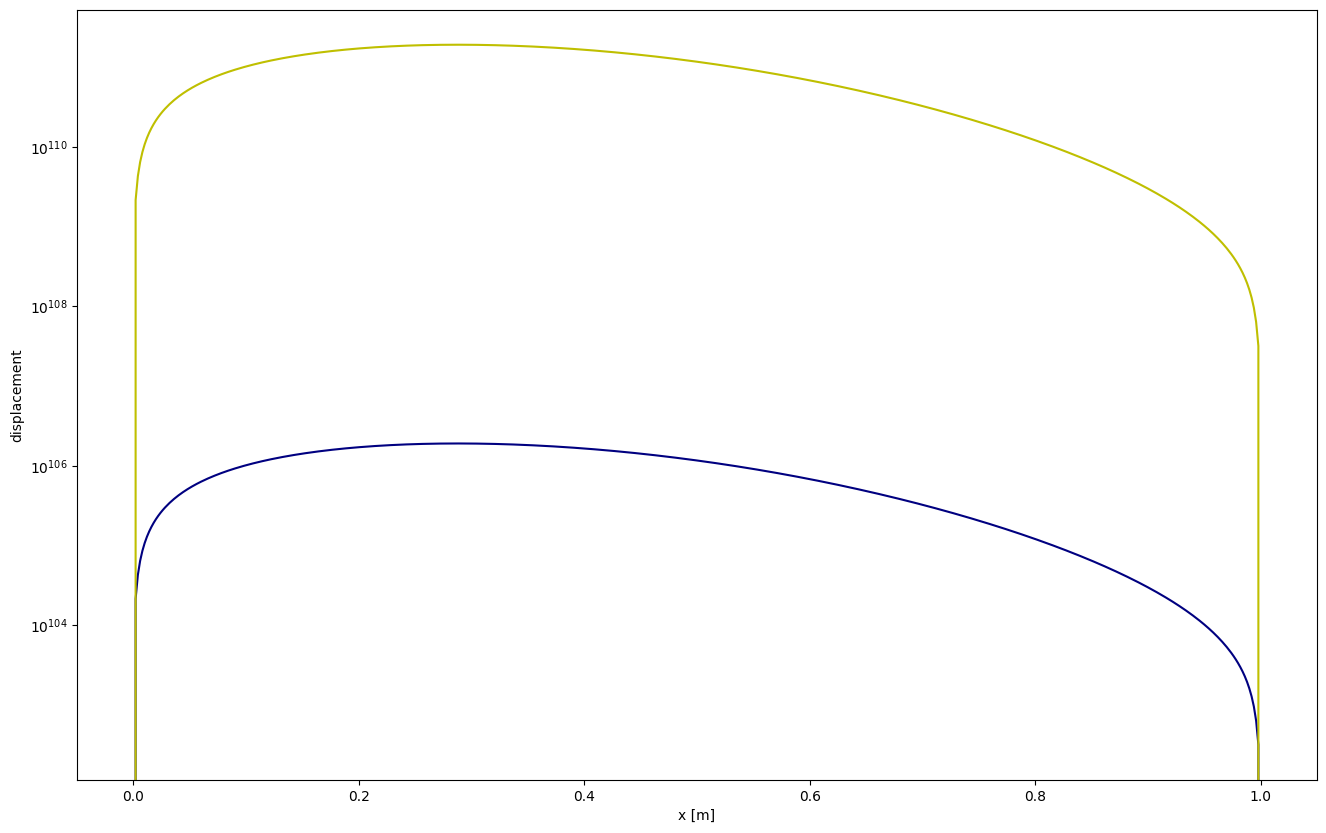

reached time t=0.0028


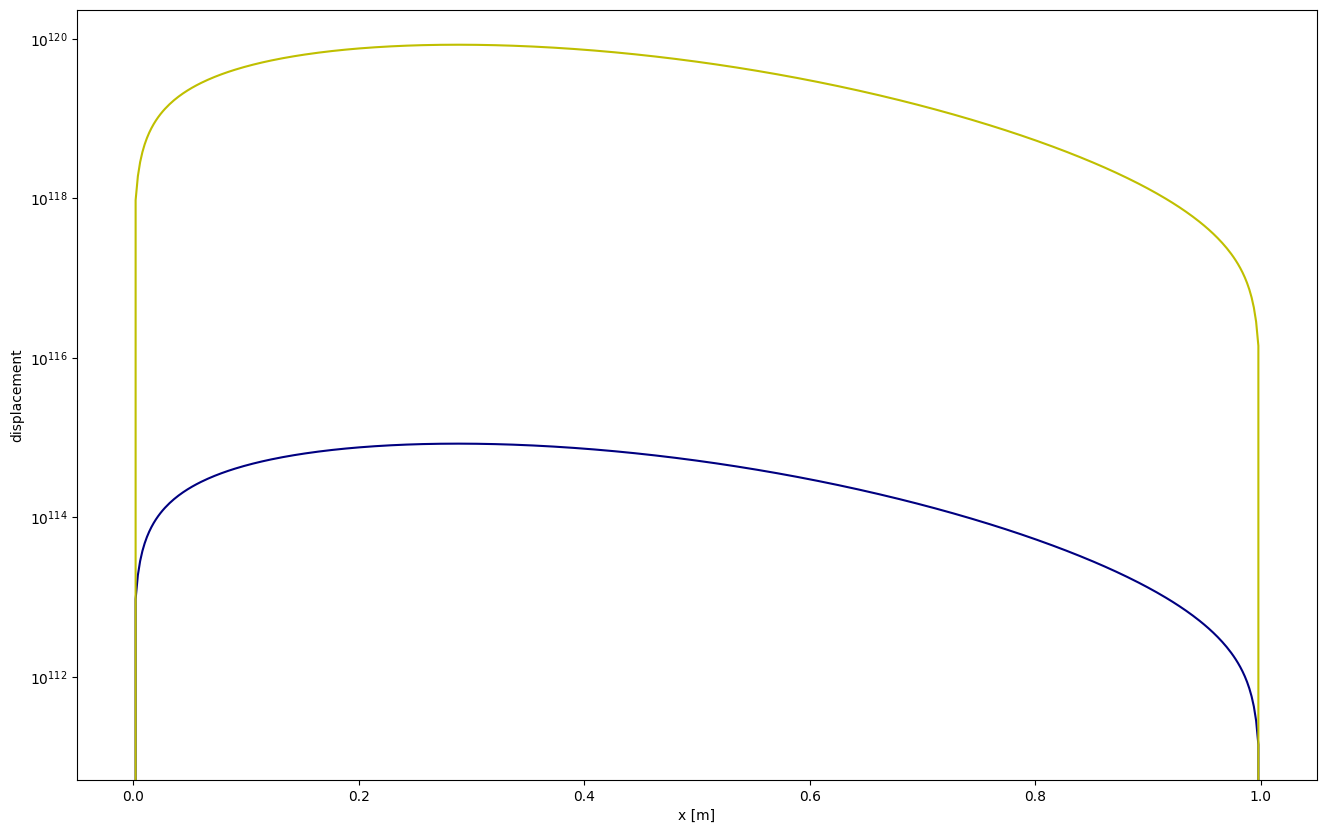

reached time t=0.003


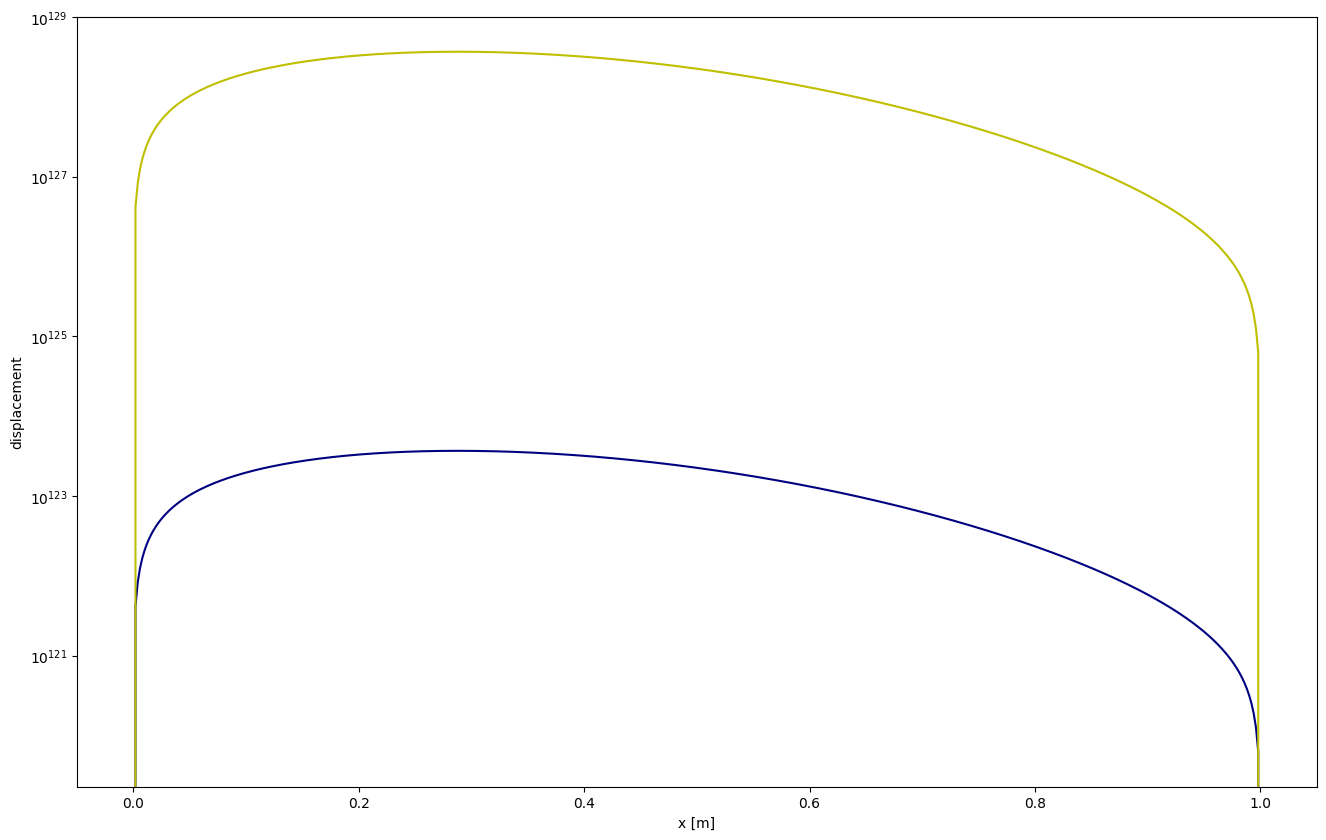

reached time t=0.0031999999999999997


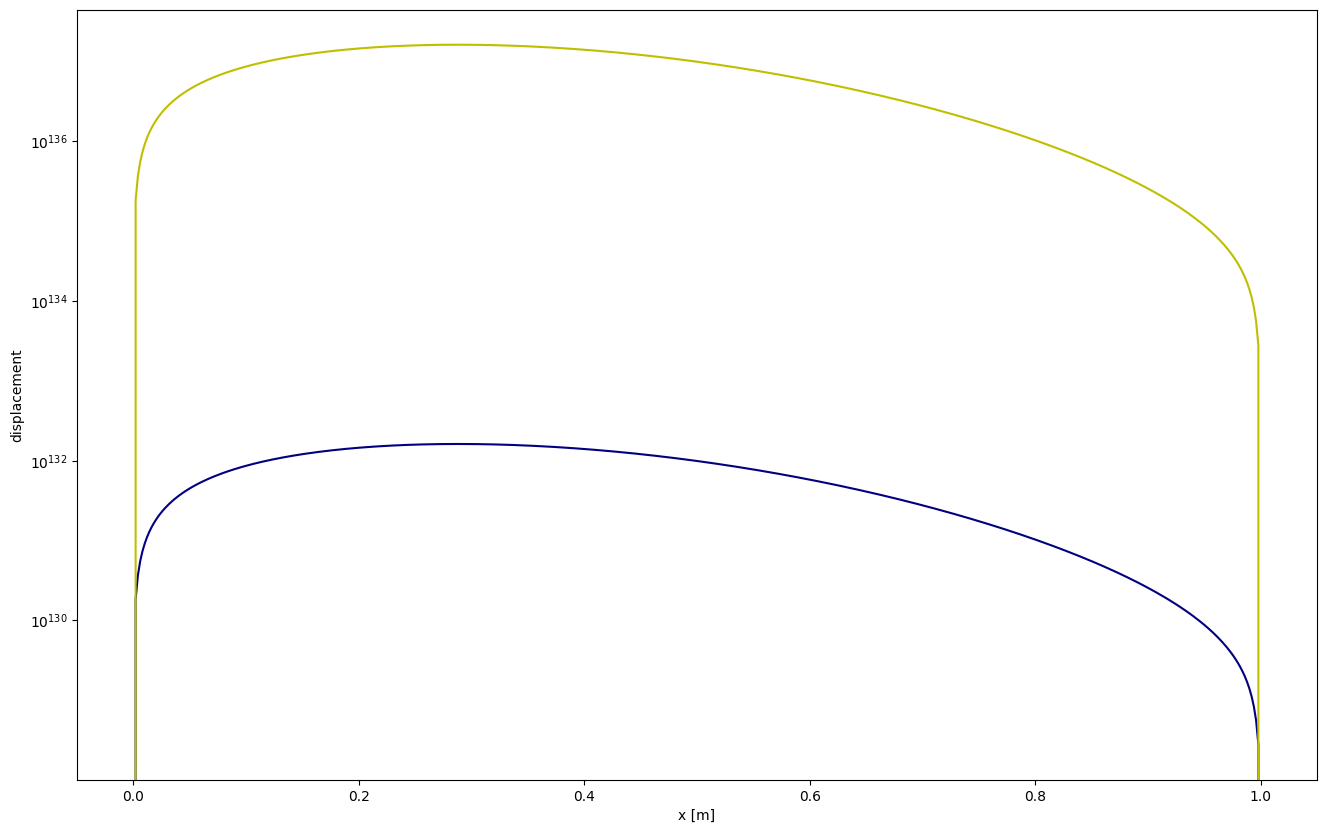

reached time t=0.0034


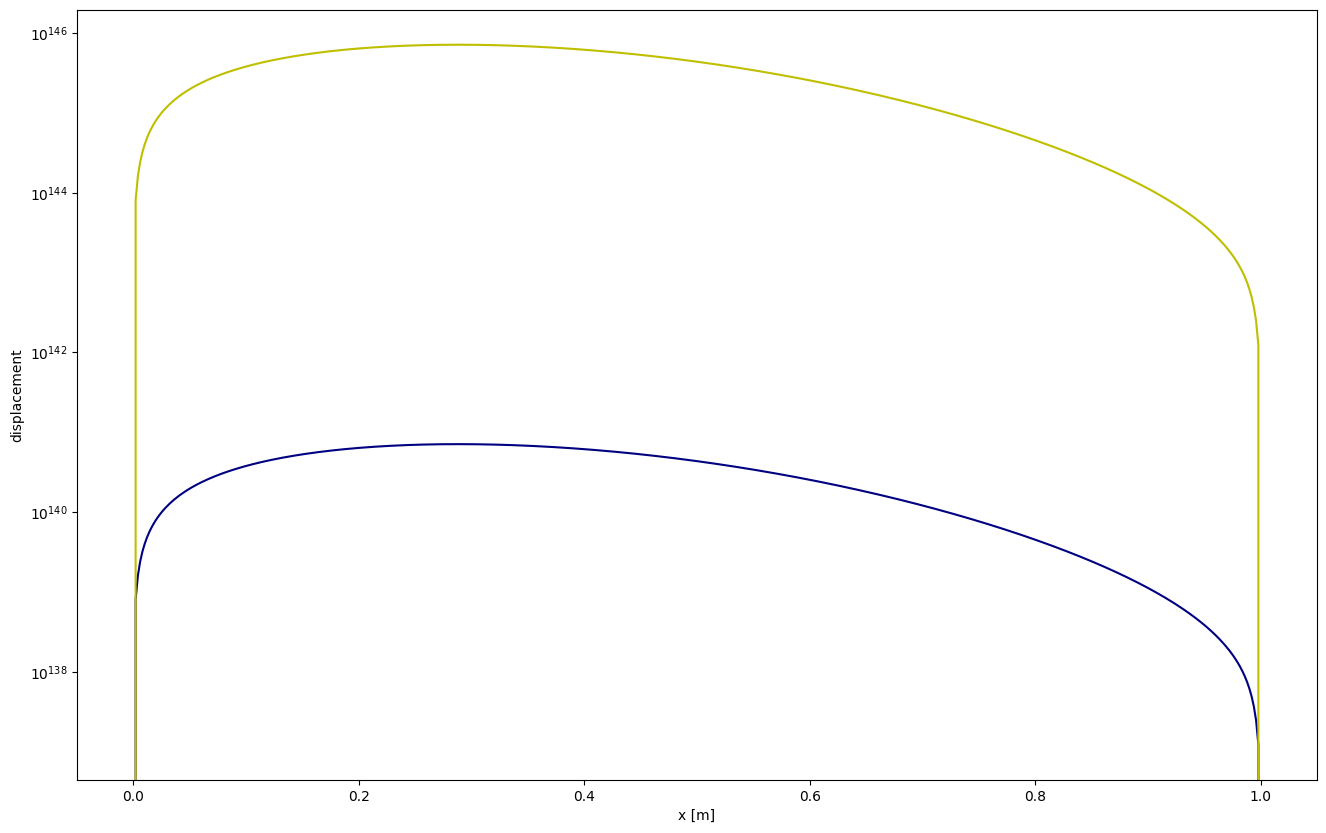

reached time t=0.0036


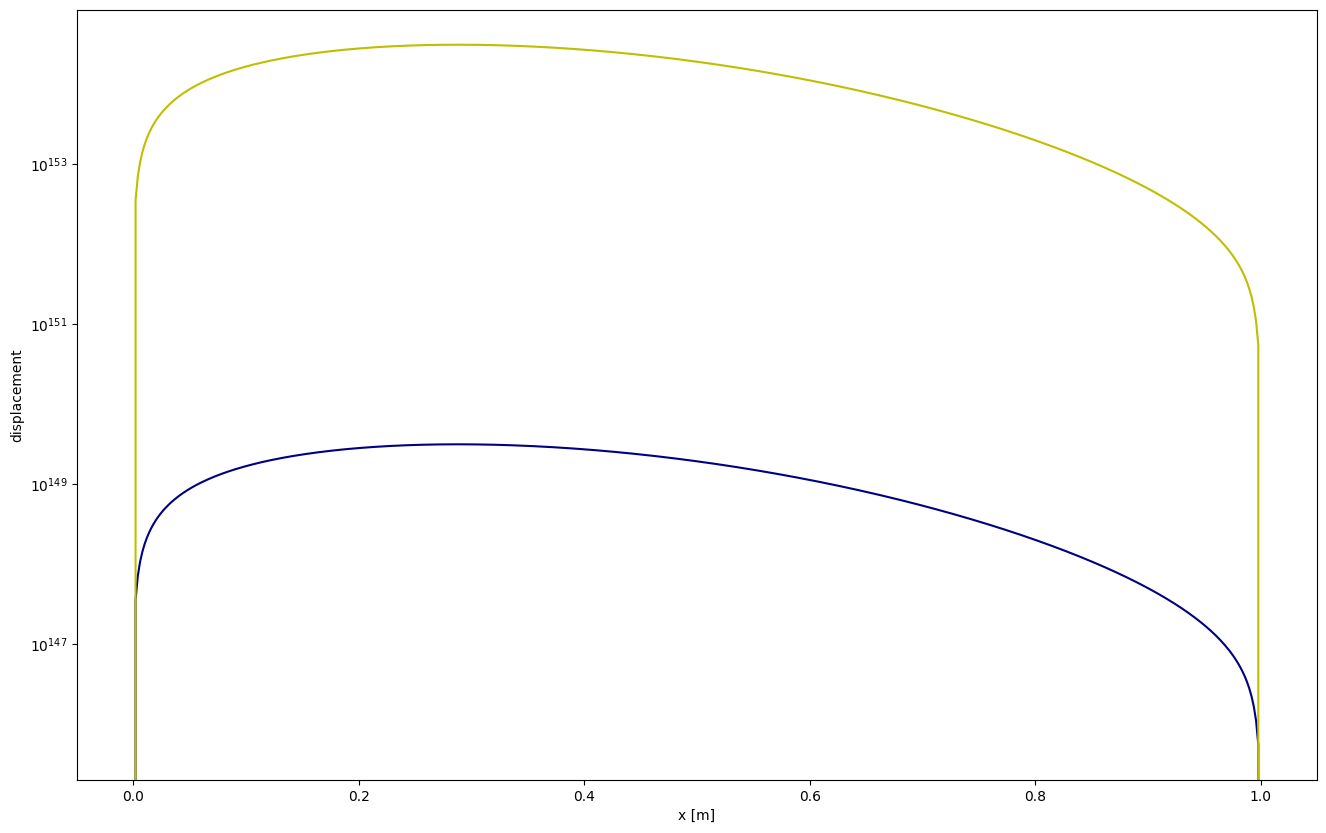

reached time t=0.0038


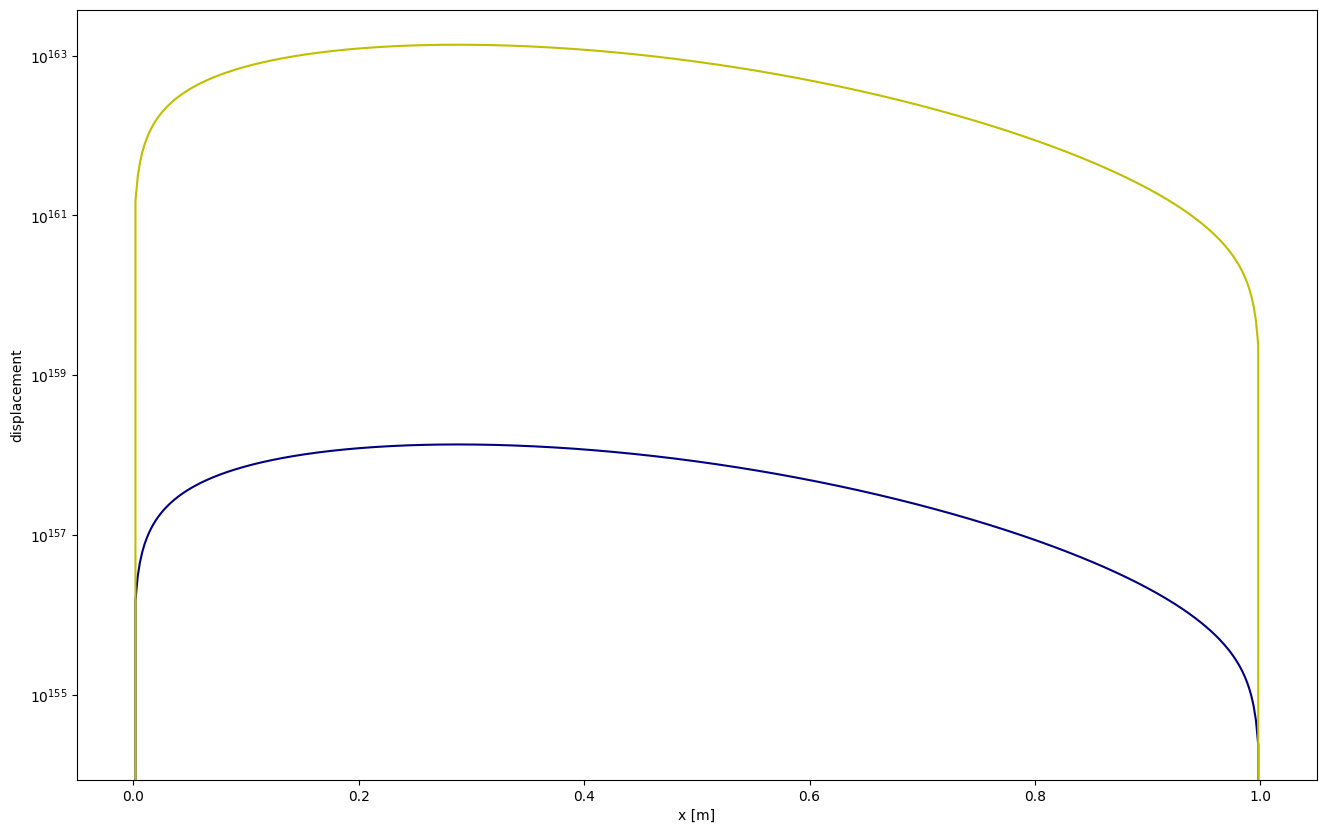

reached time t=0.004


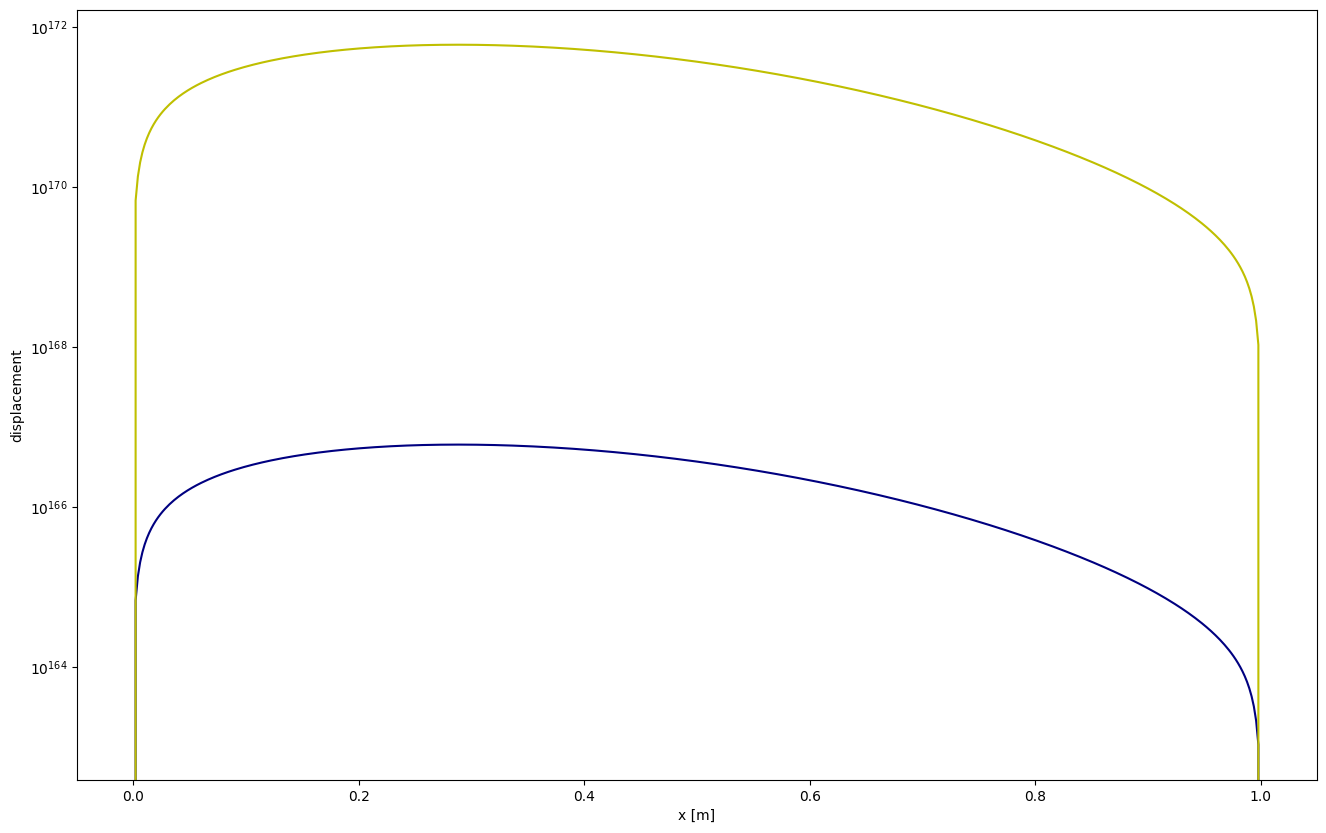

reached time t=0.0042


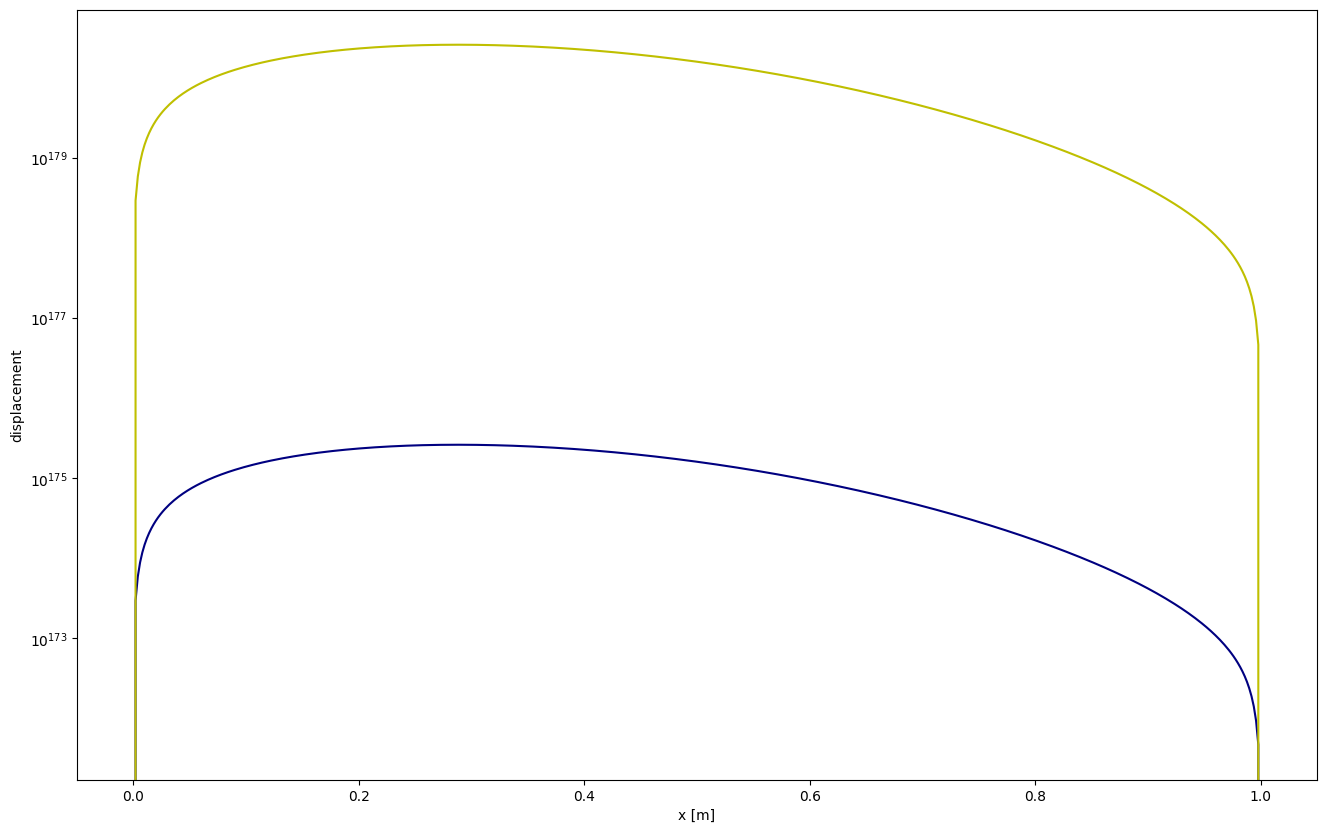

reached time t=0.004399999999999999


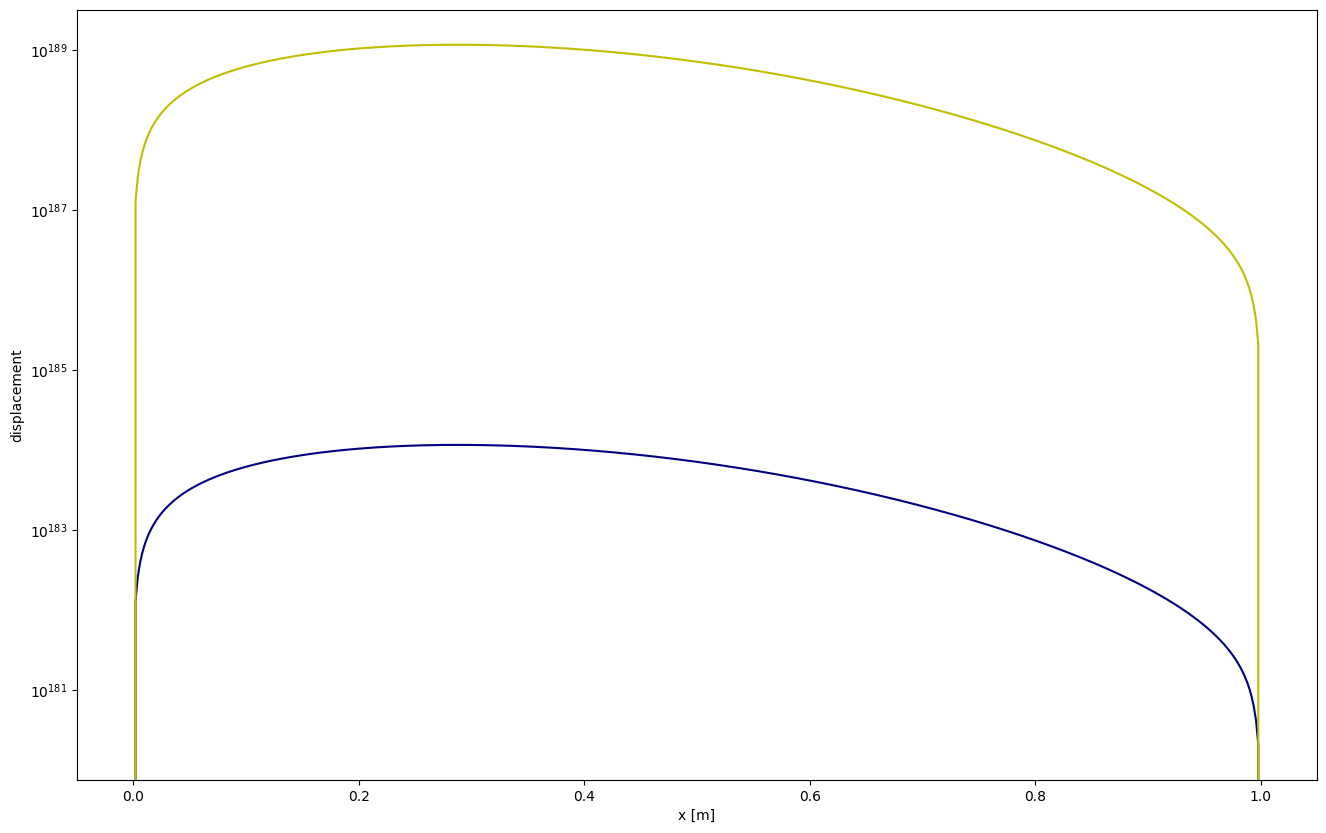

reached time t=0.0046


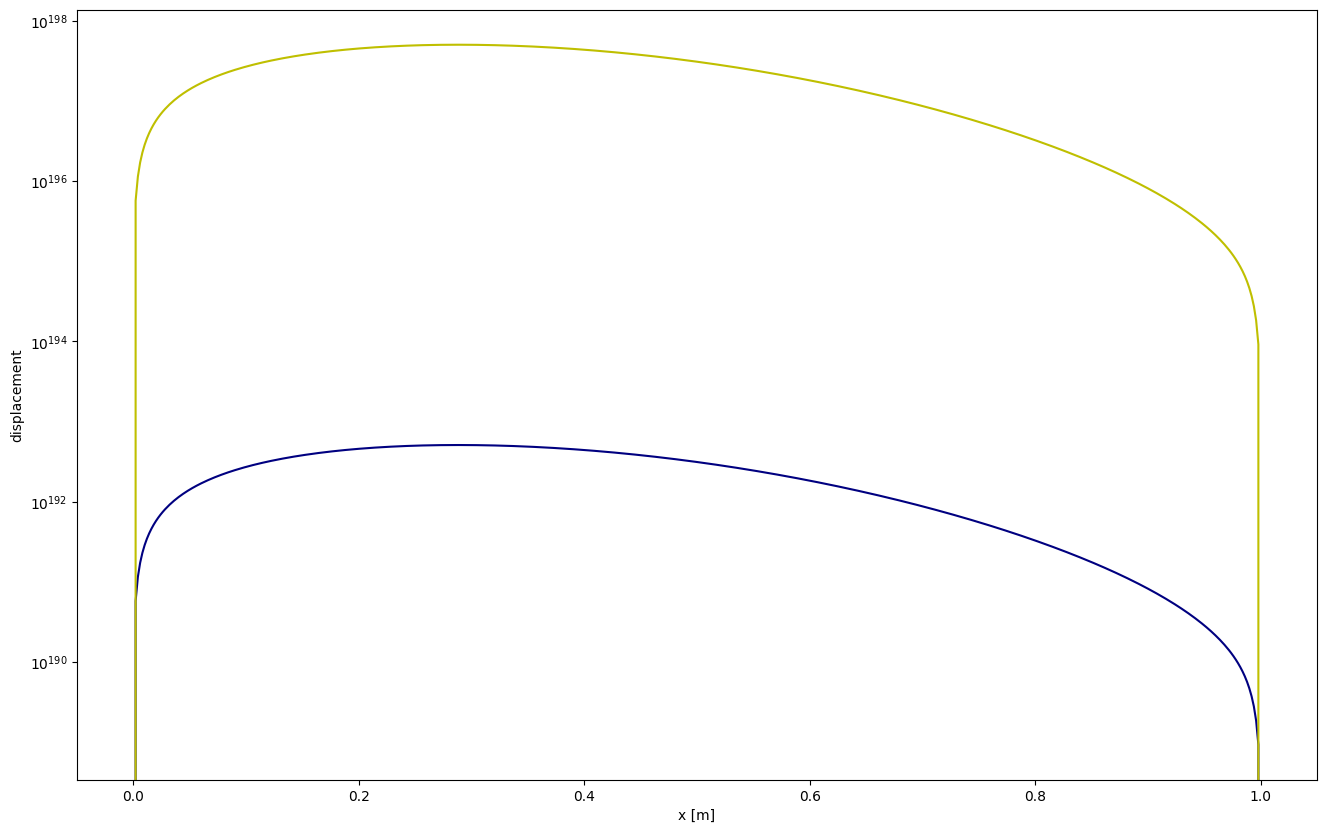

reached time t=0.0048


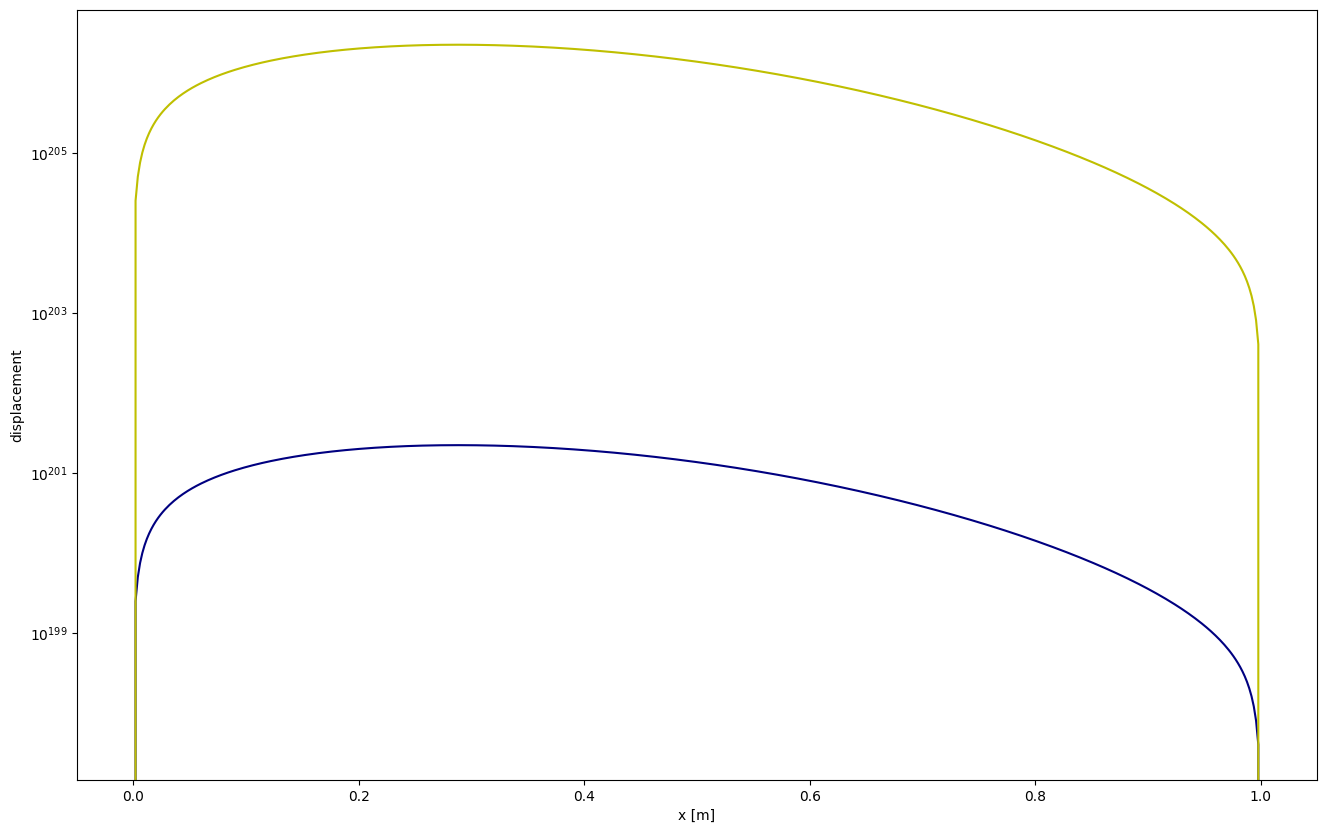

reached time t=0.005


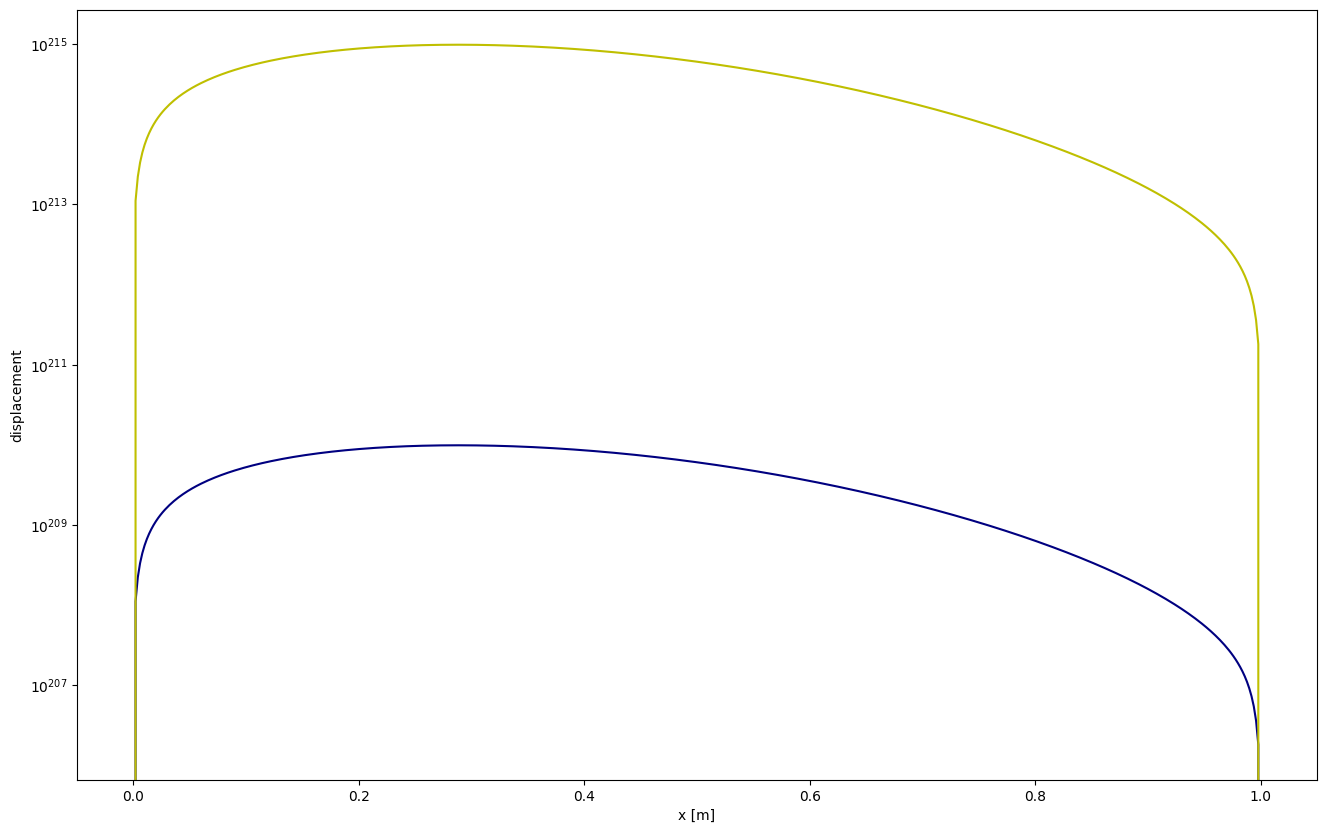

reached time t=0.0052


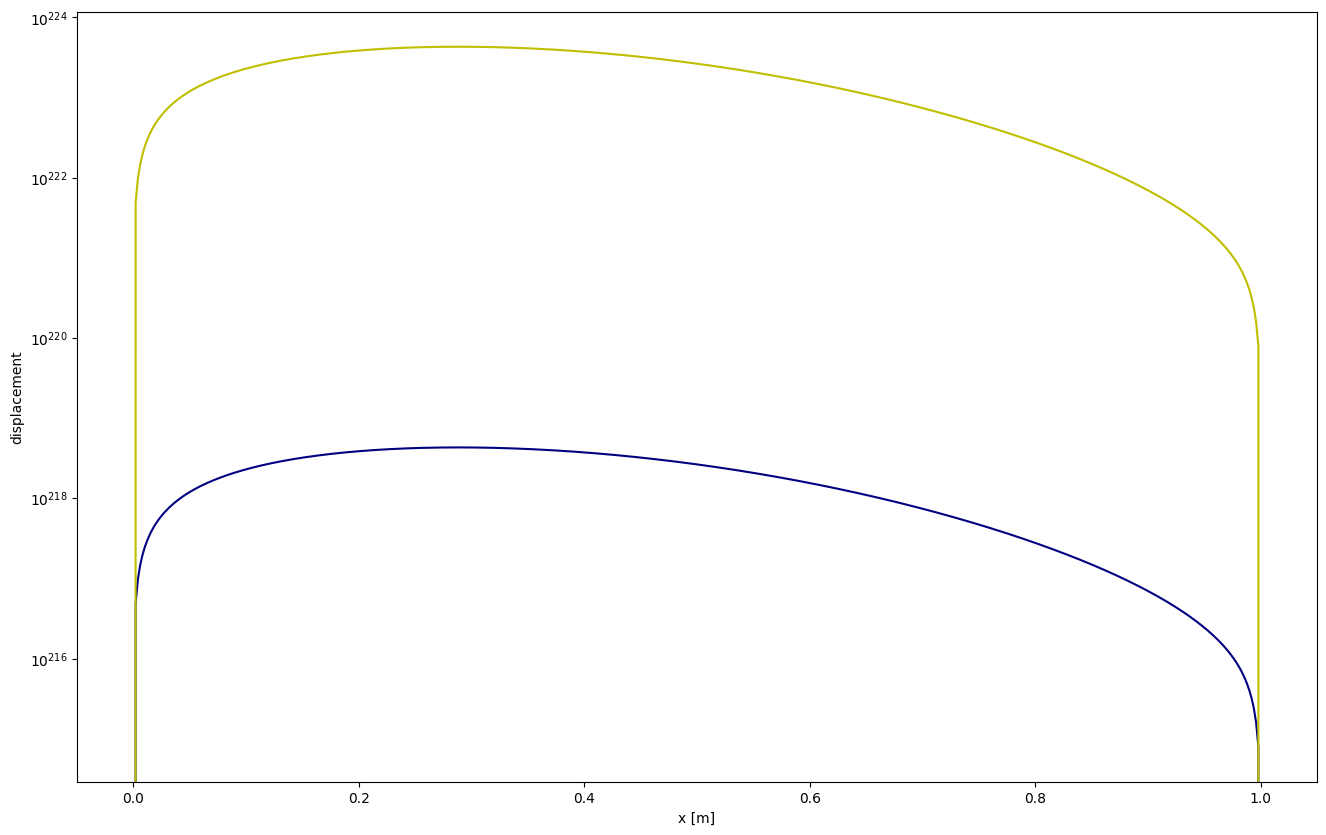

reached time t=0.005399999999999999


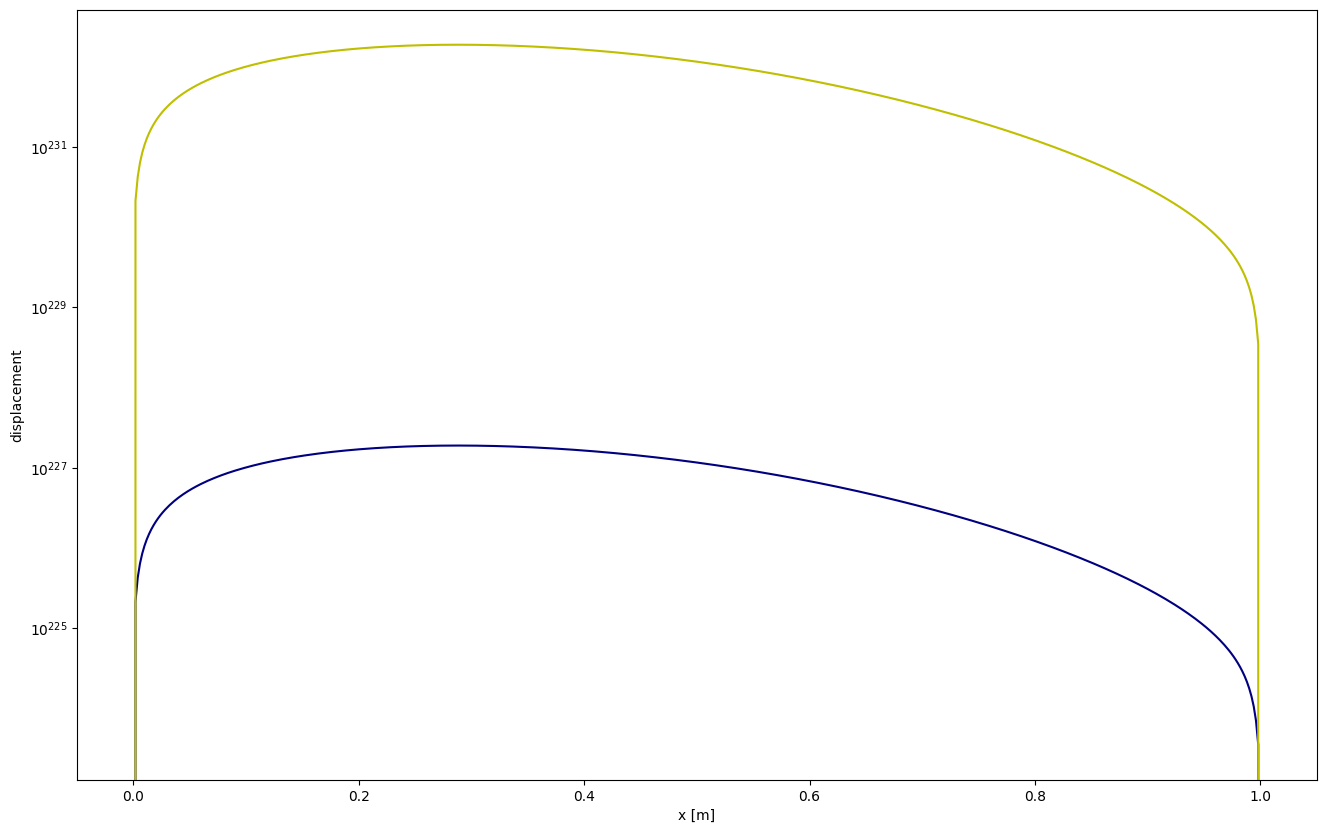

reached time t=0.0056


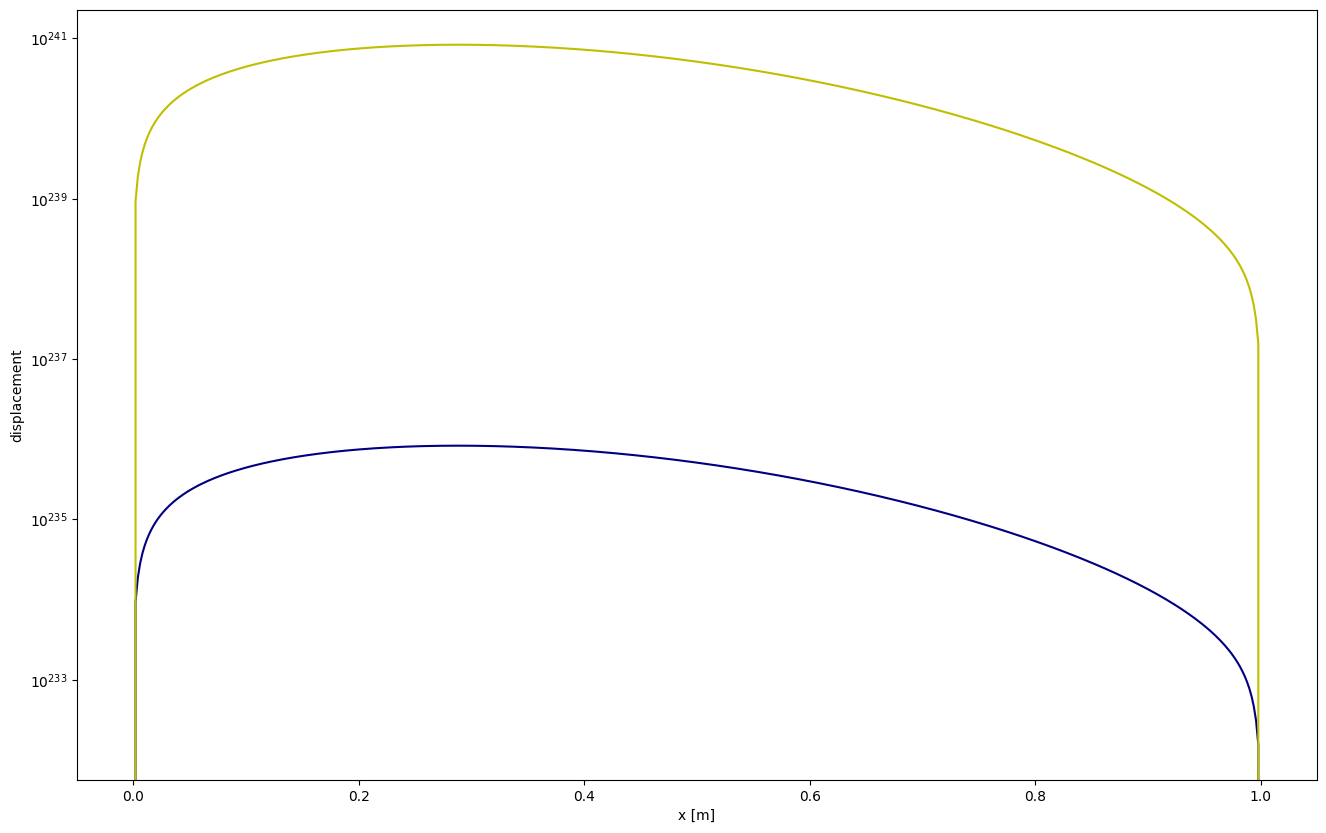

reached time t=0.0058


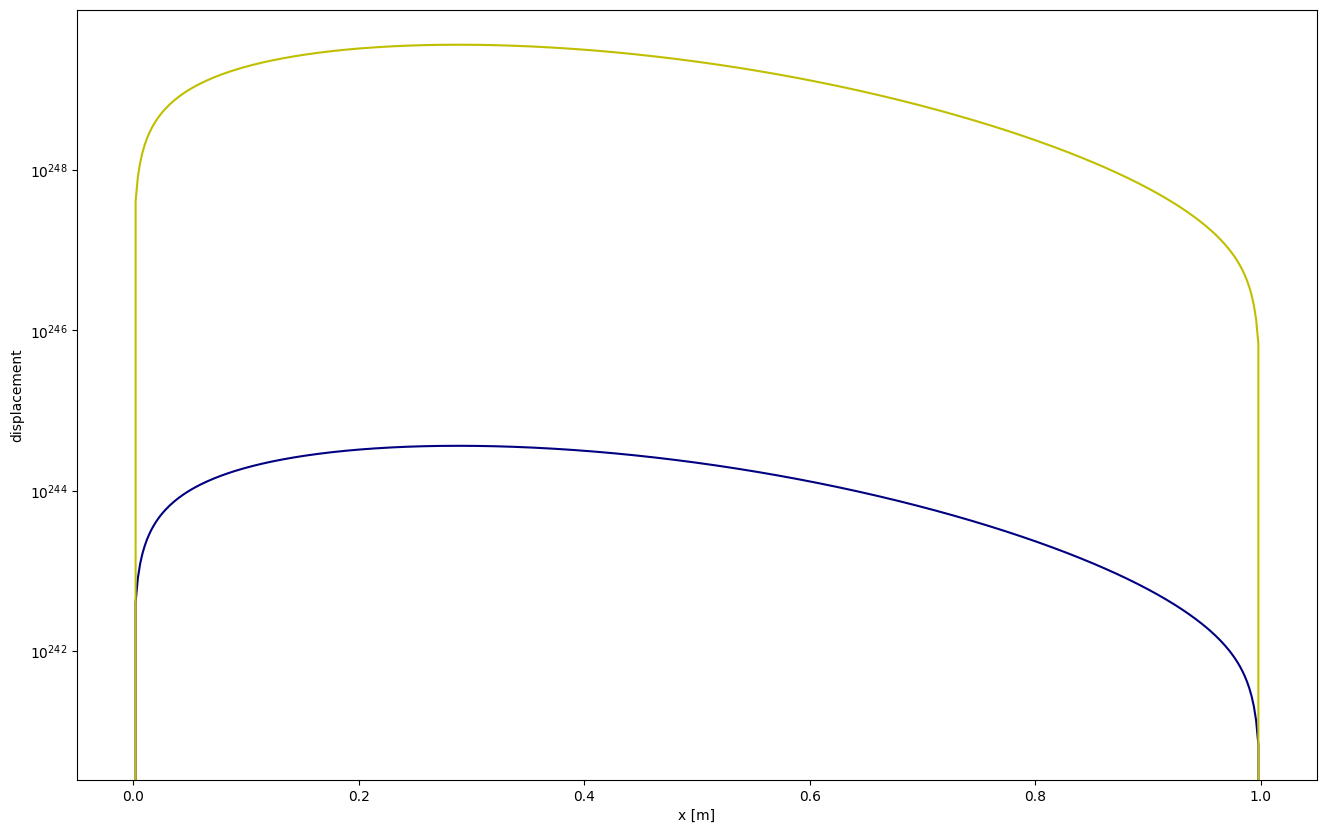

reached time t=0.006


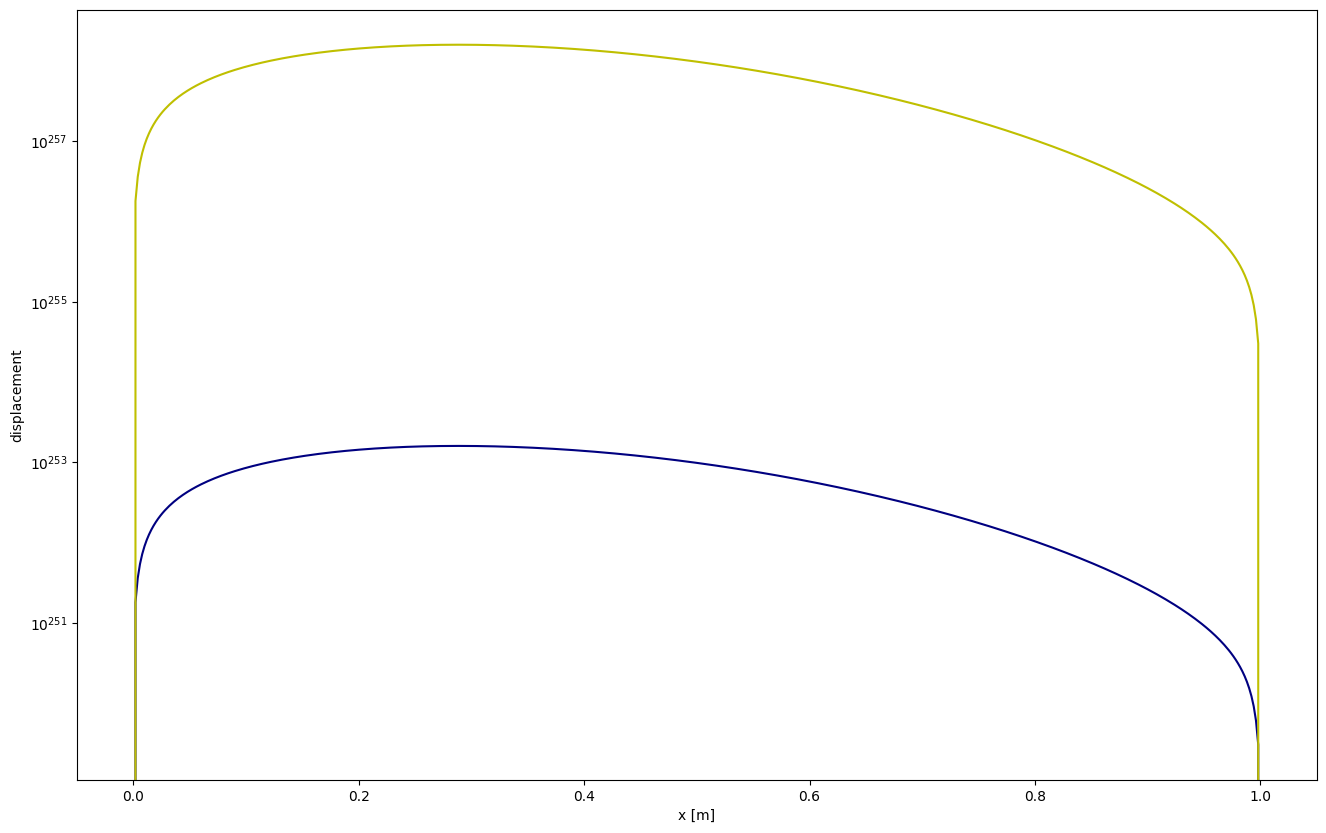

reached time t=0.0062


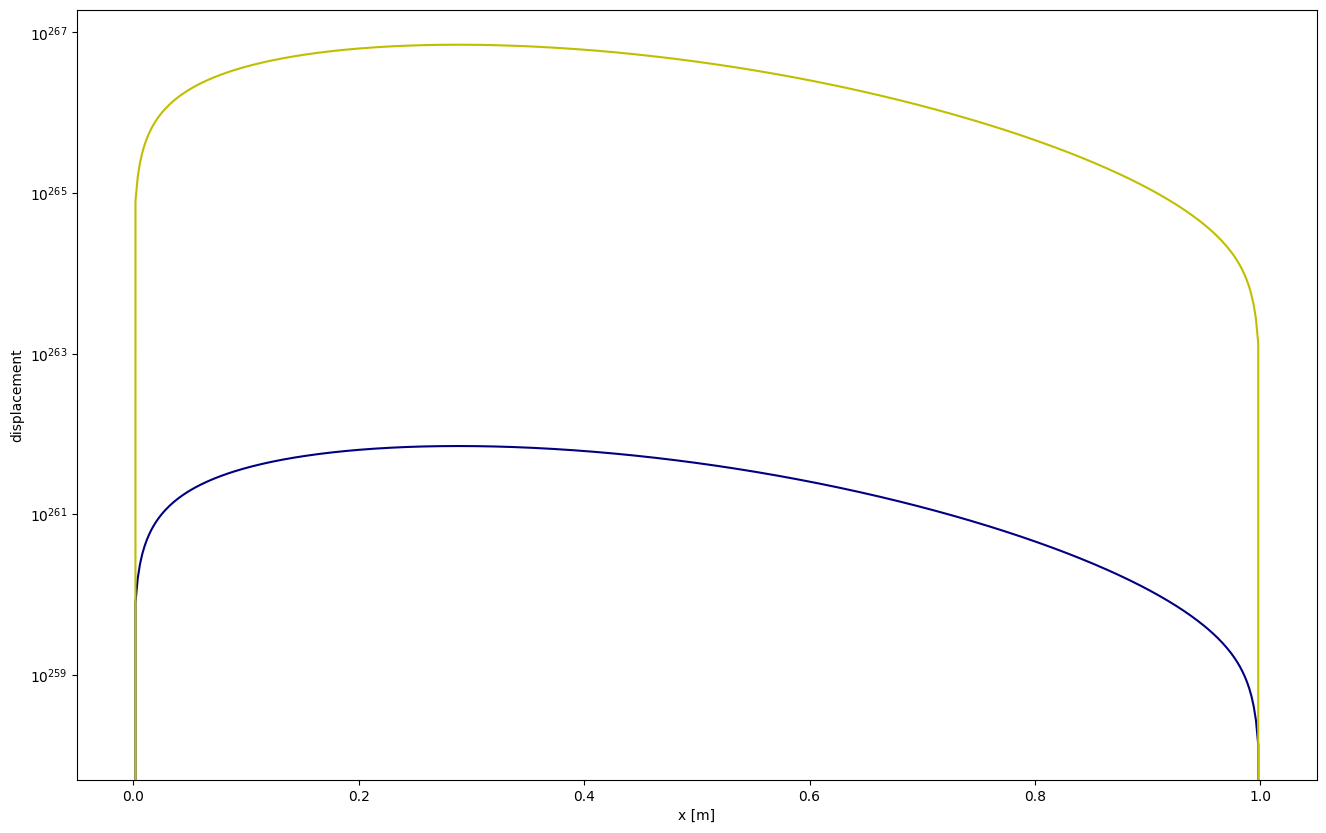

reached time t=0.0063999999999999994


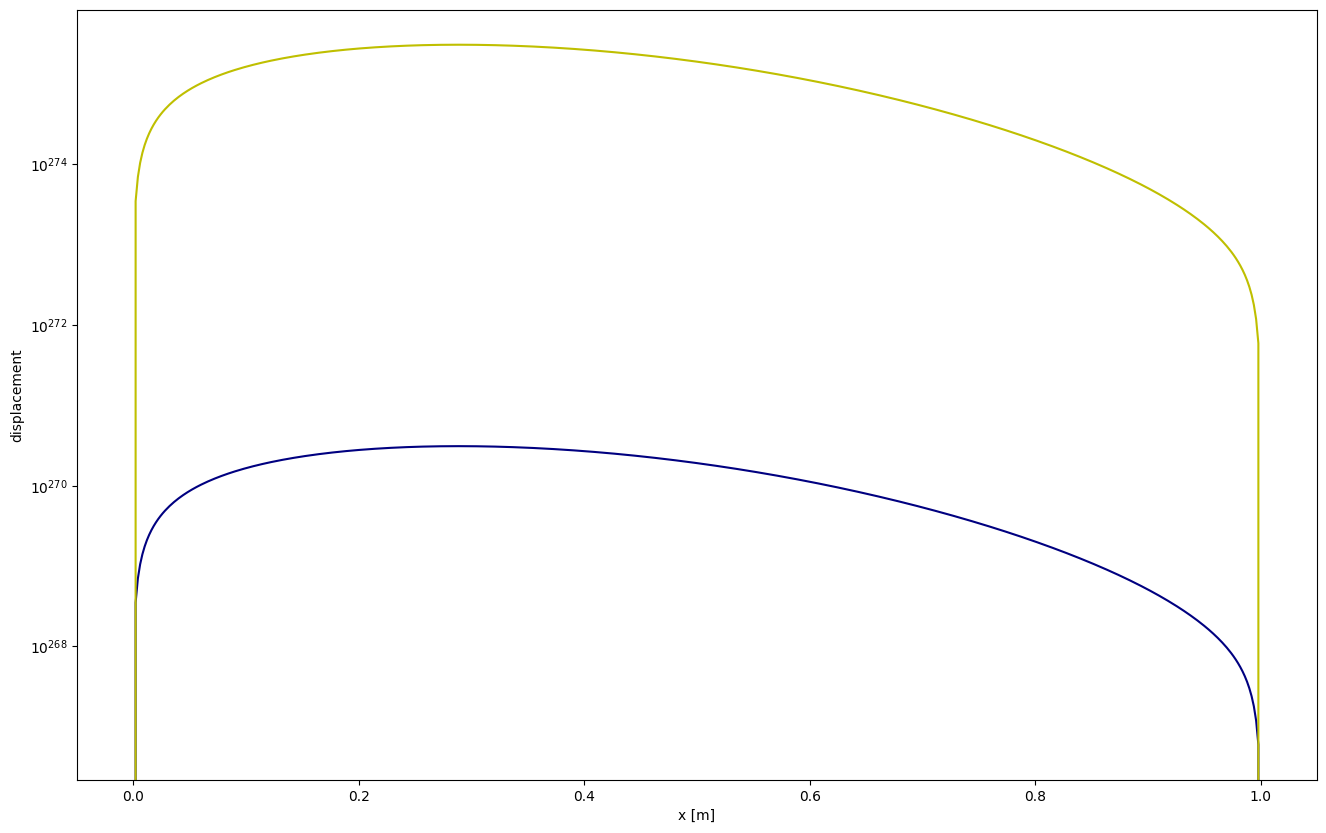

reached time t=0.0066


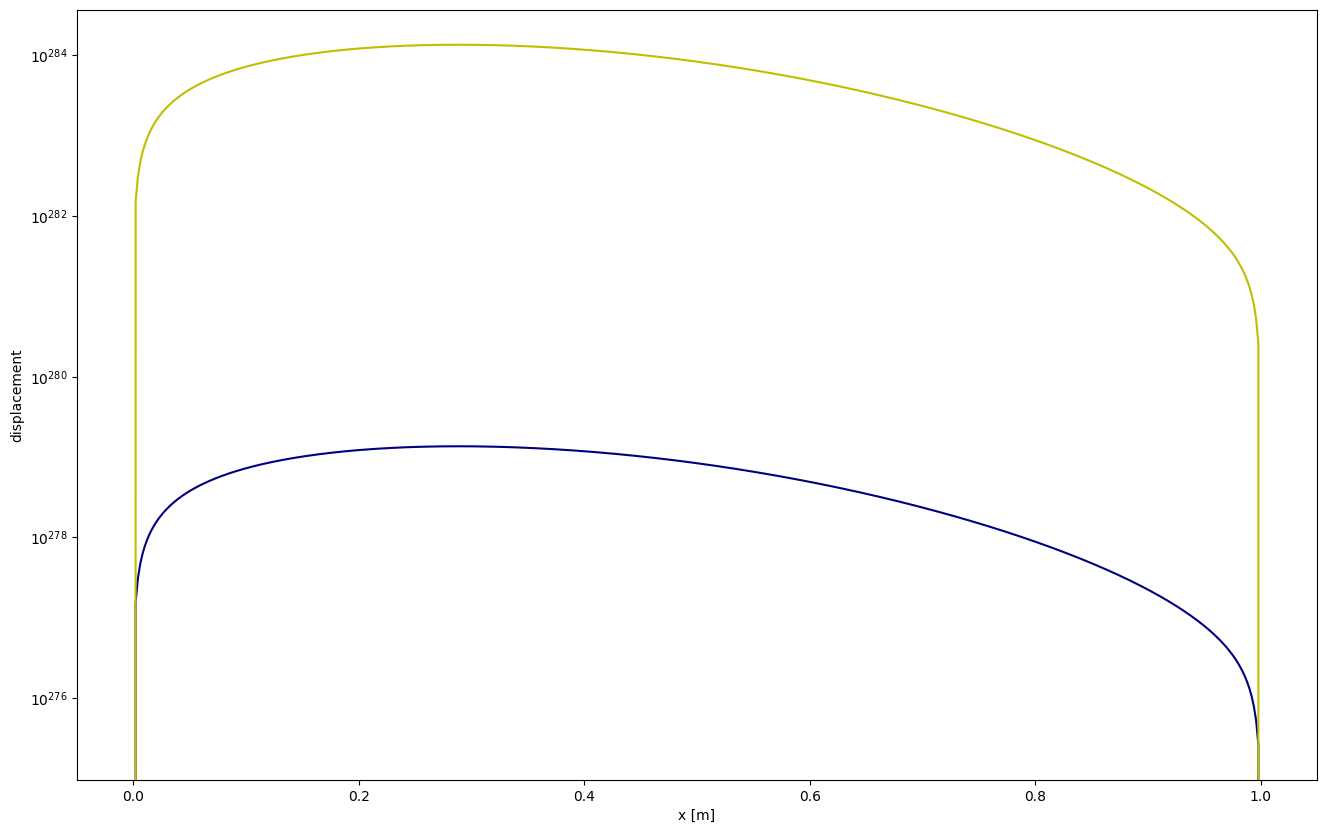

reached time t=0.0068


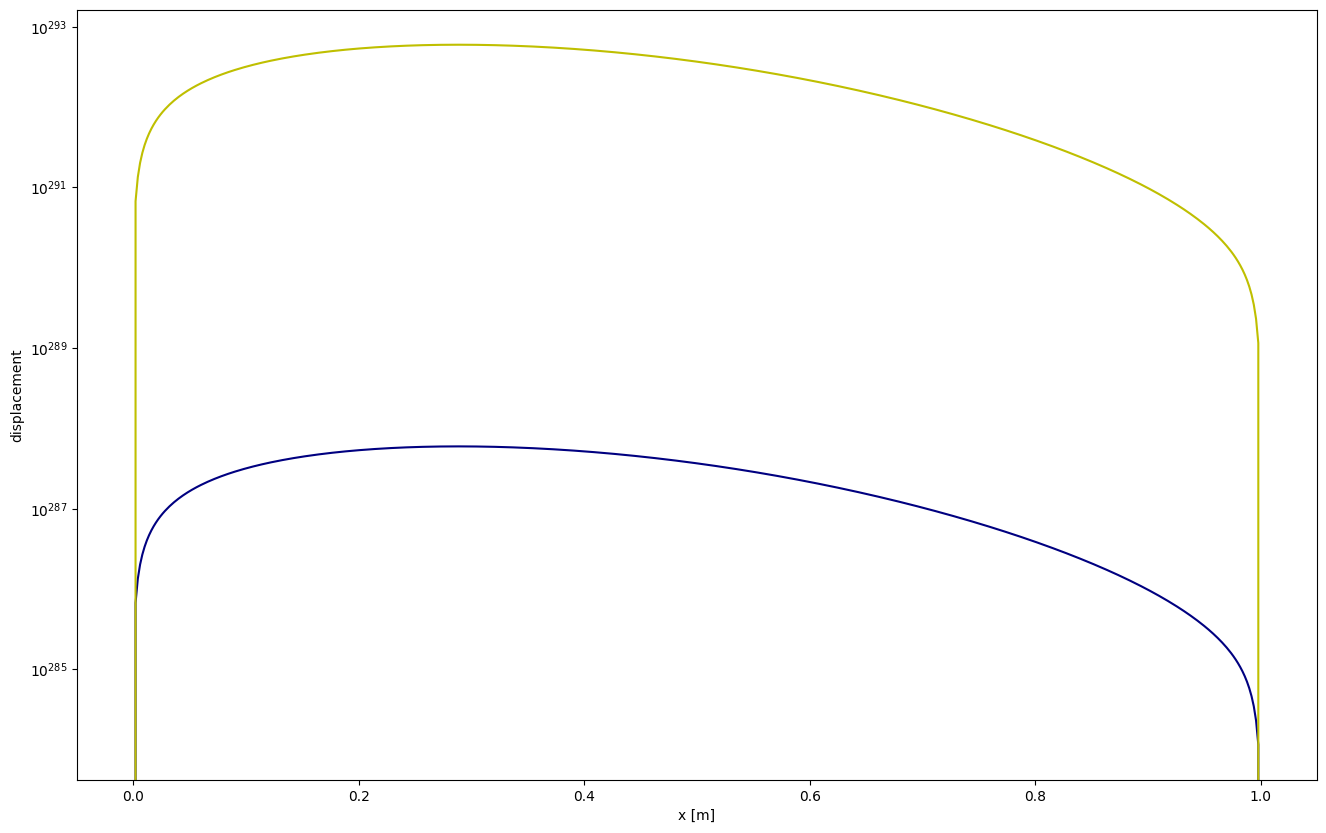

reached time t=0.006999999999999999


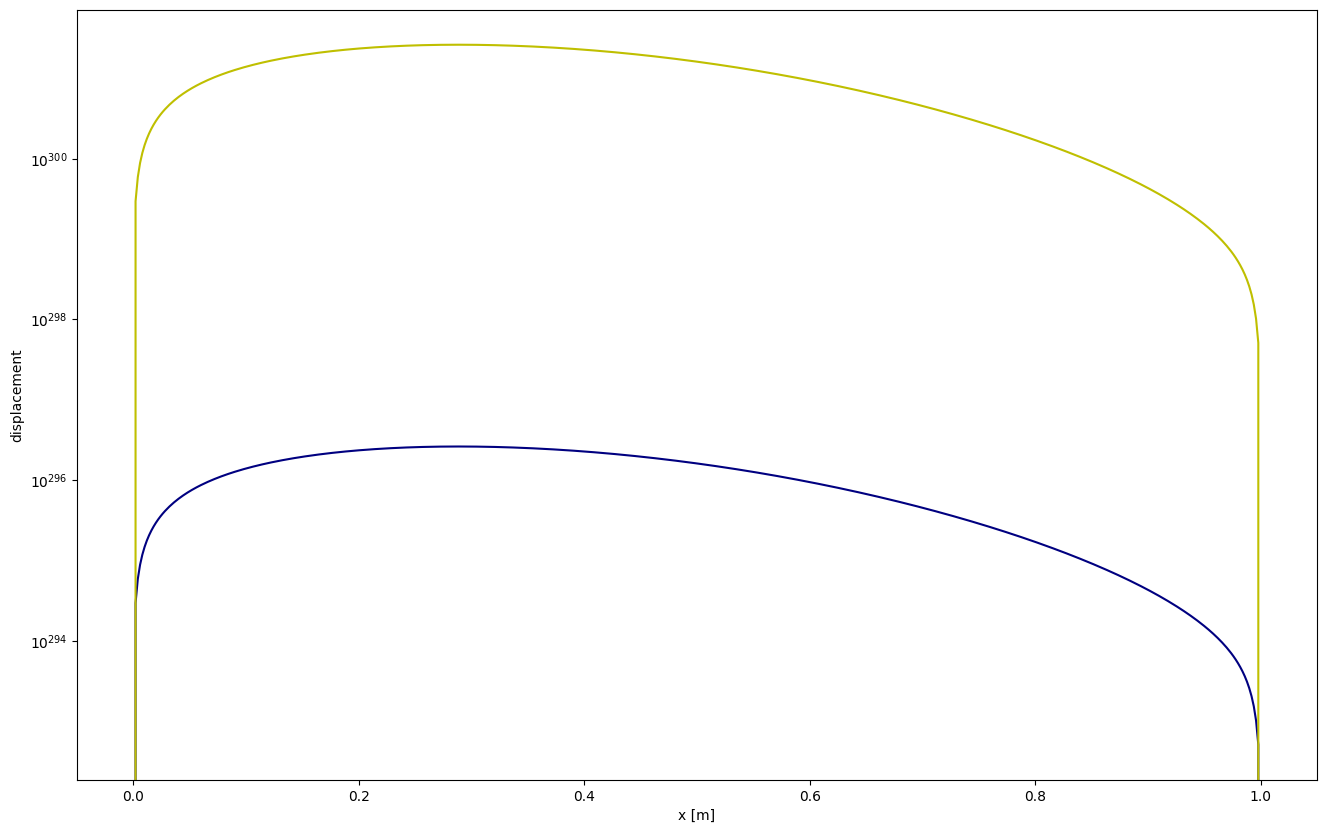

reached time t=0.0072


ValueError: cannot convert float NaN to integer

<Figure size 1600x1000 with 1 Axes>

reached time t=0.0073999999999999995


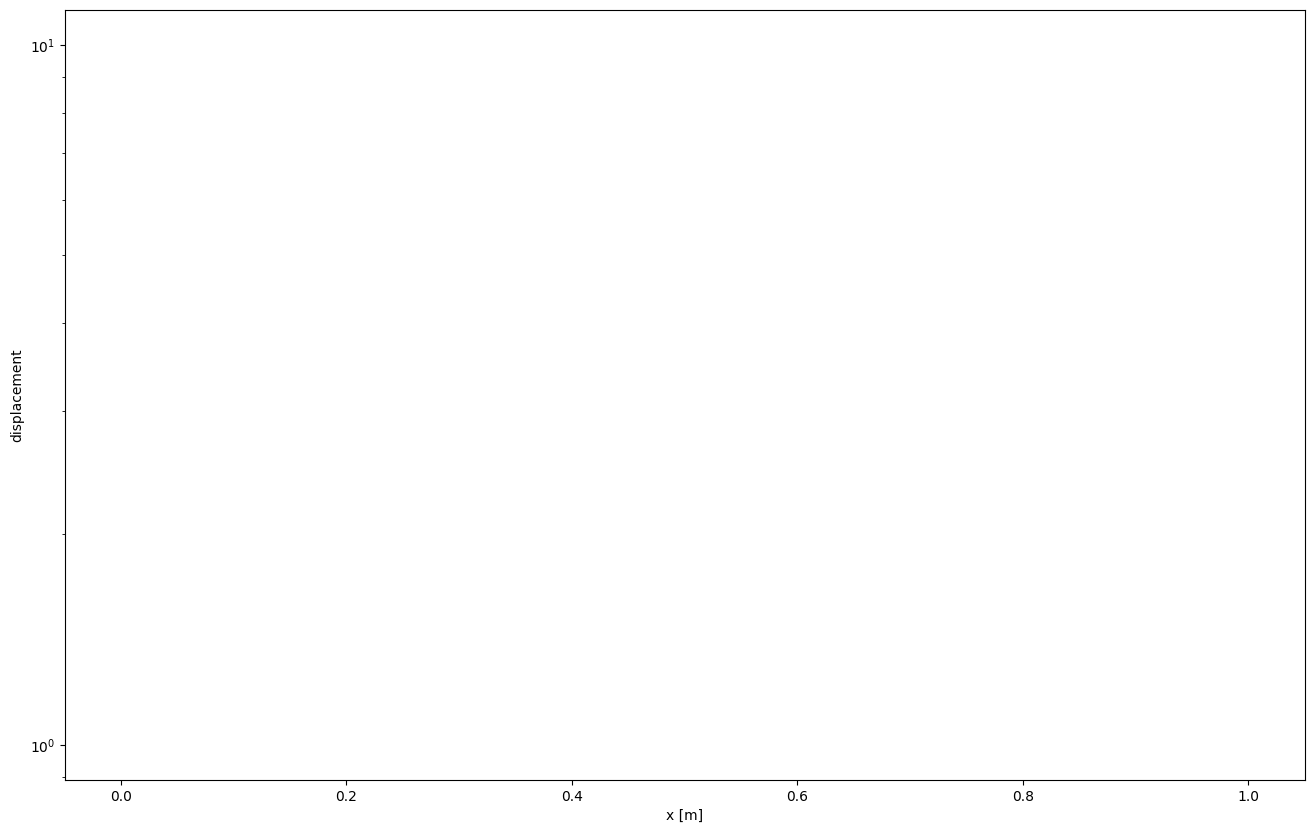

reached time t=0.0076


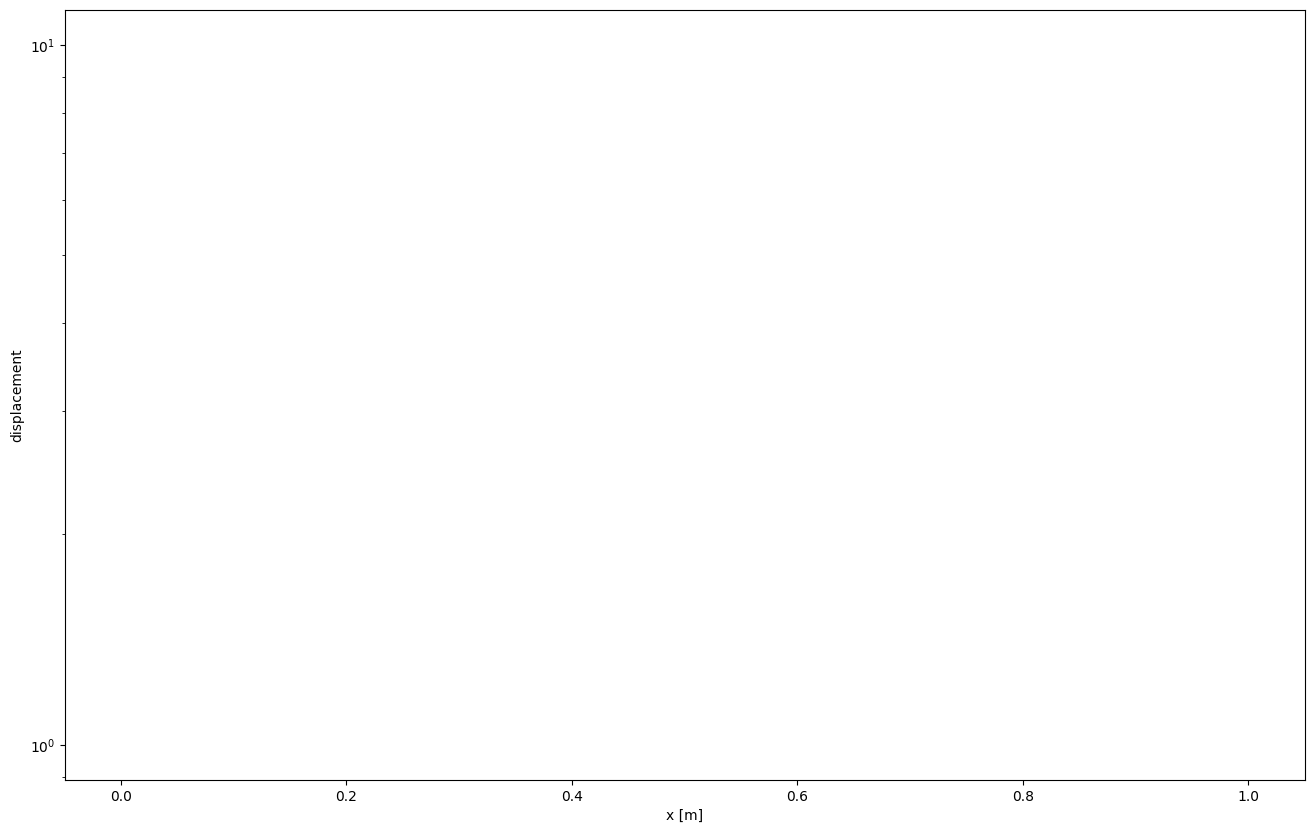

reached time t=0.0078


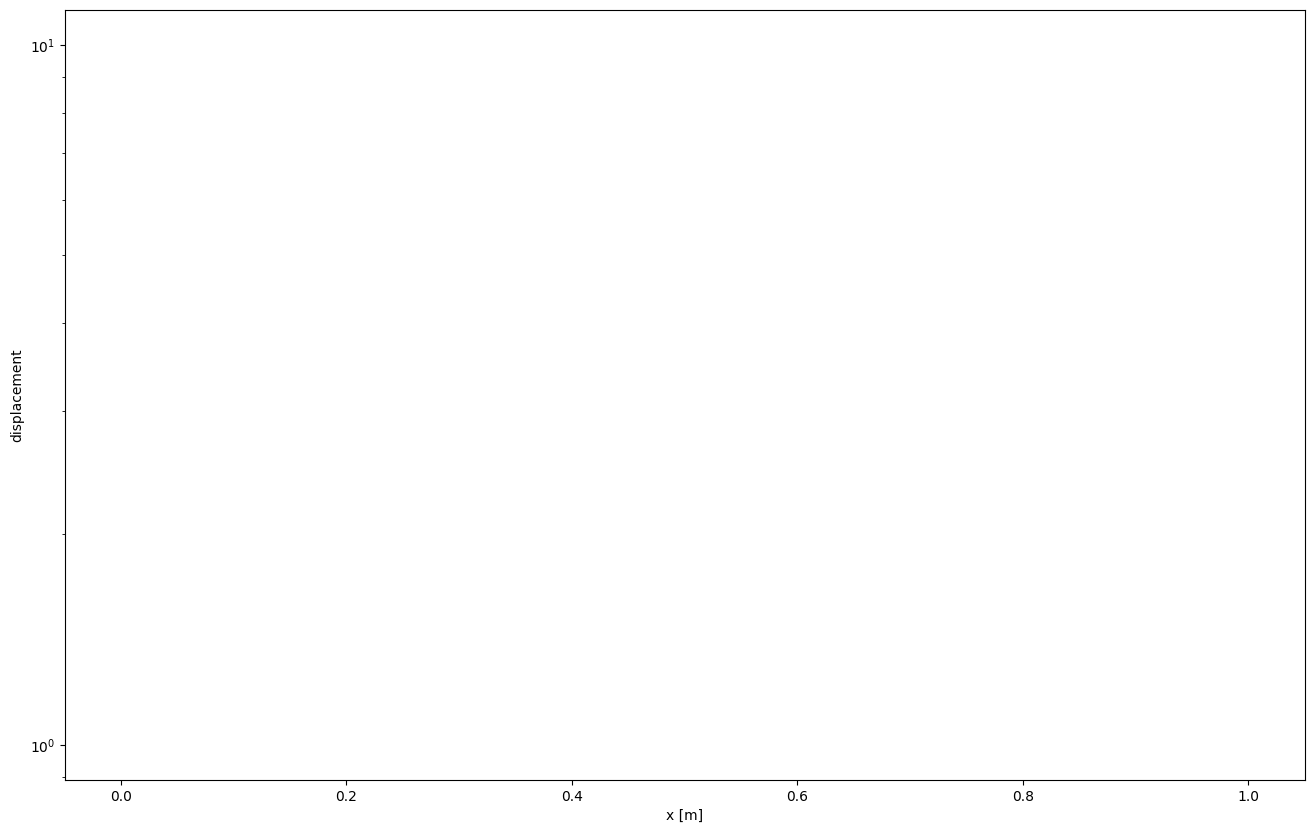

reached time t=0.008


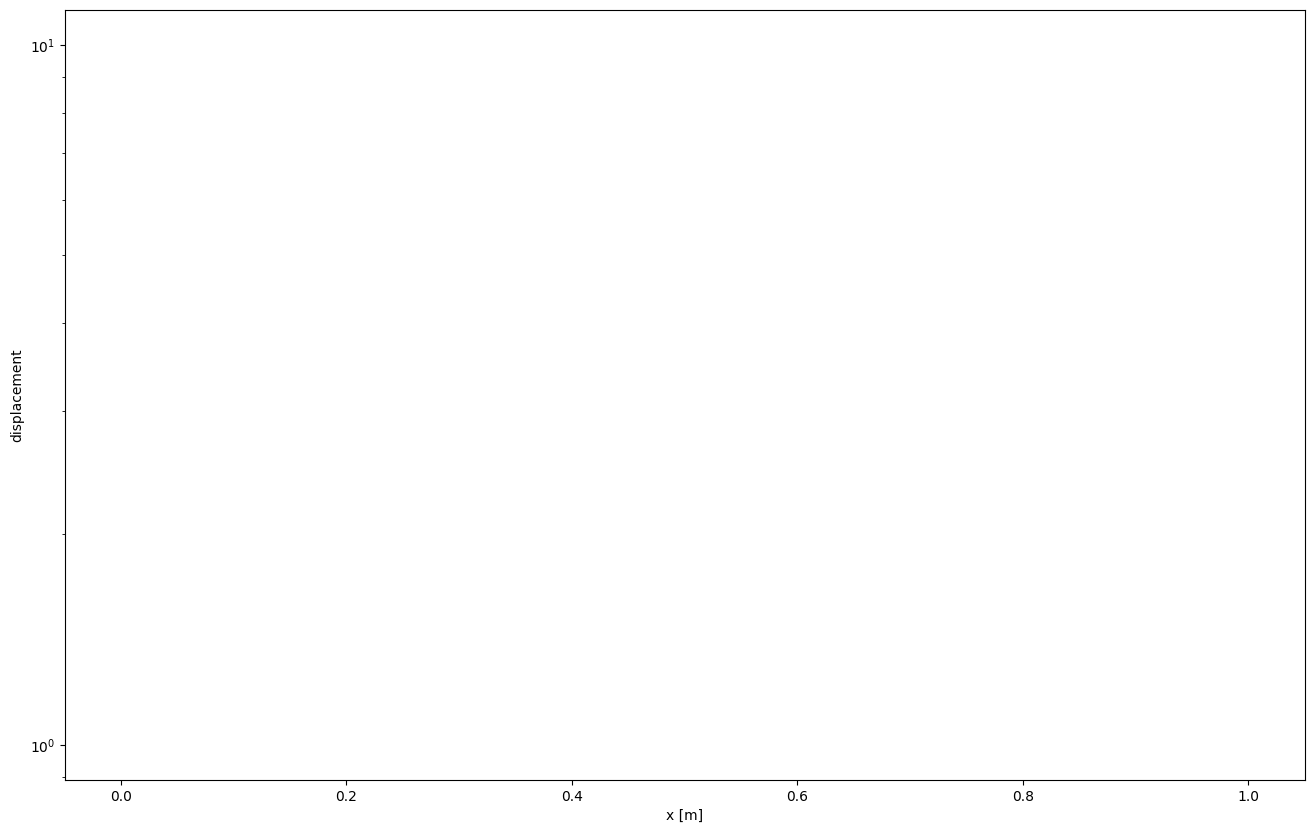

reached time t=0.008199999999999999


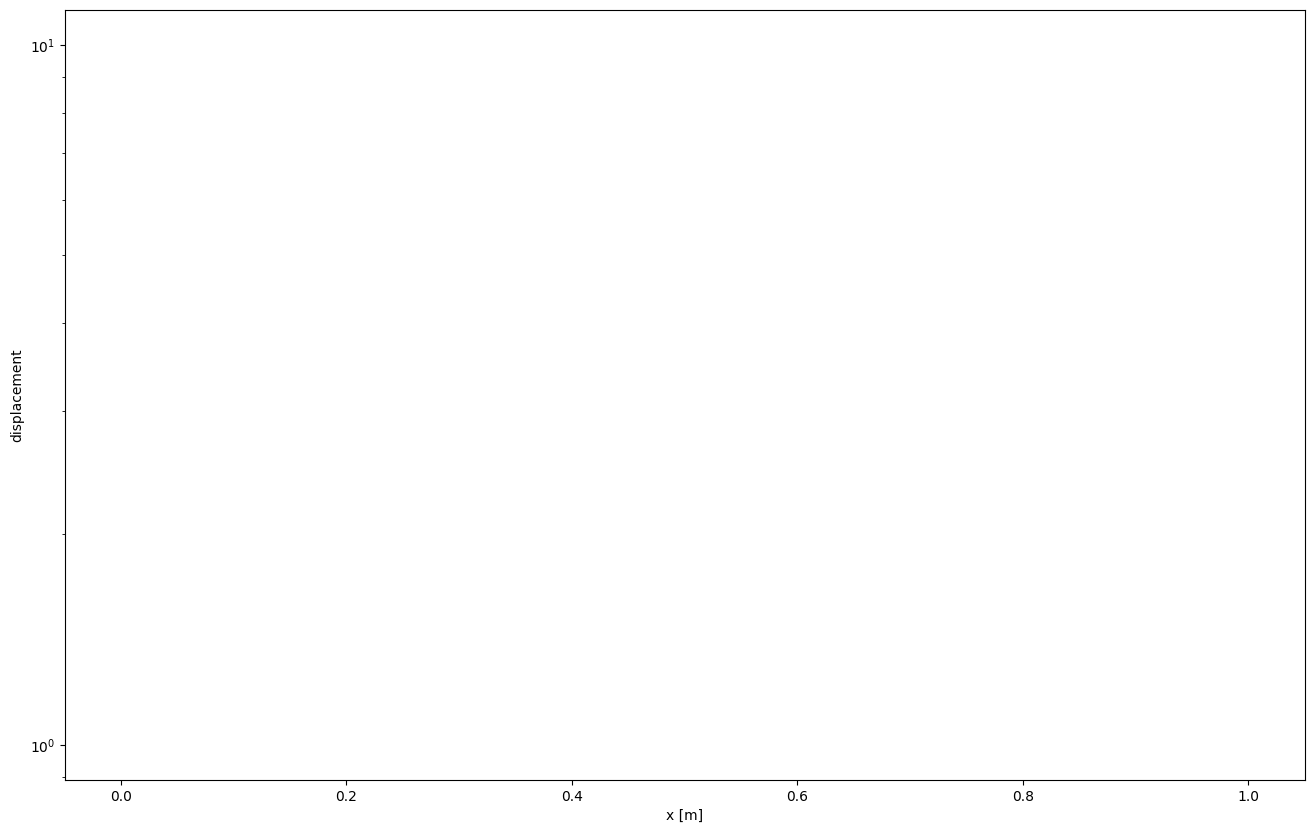

reached time t=0.0084


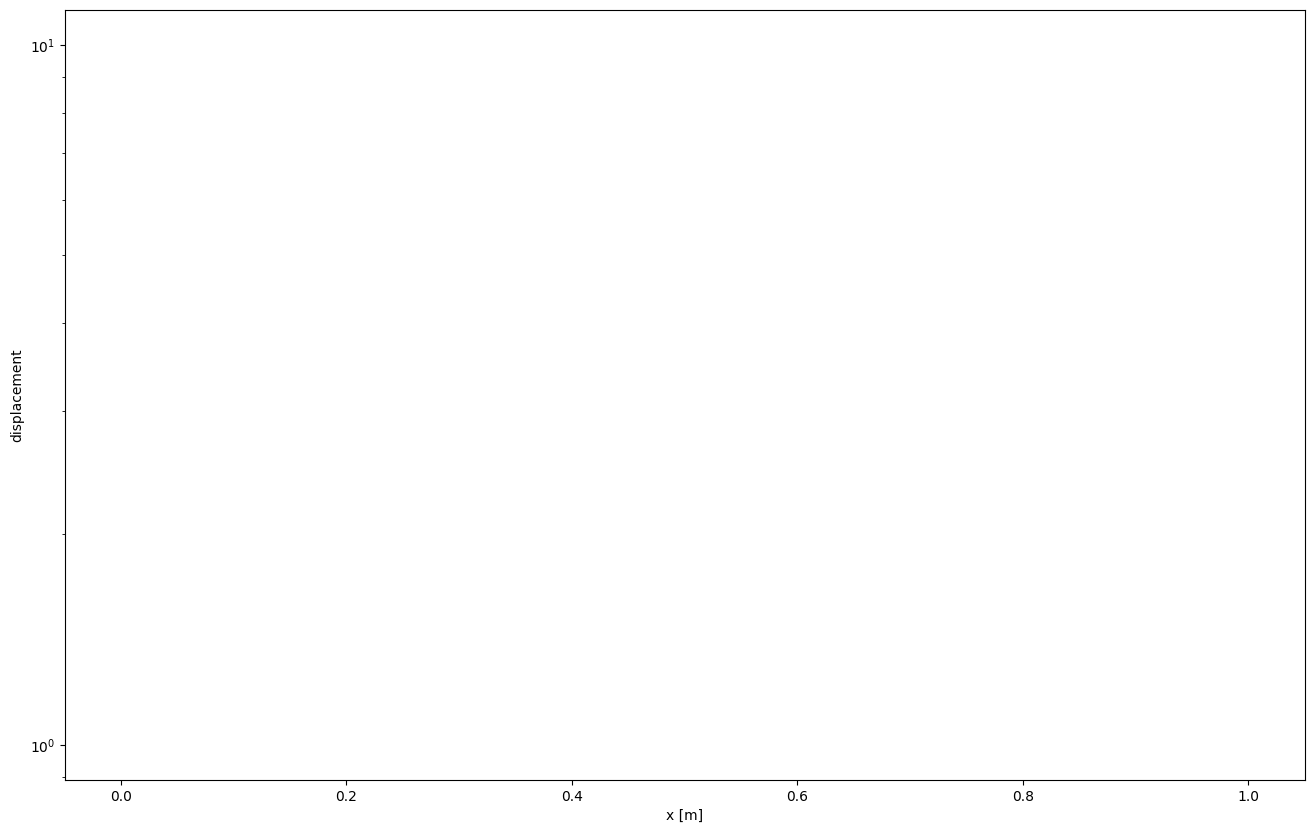

reached time t=0.0086


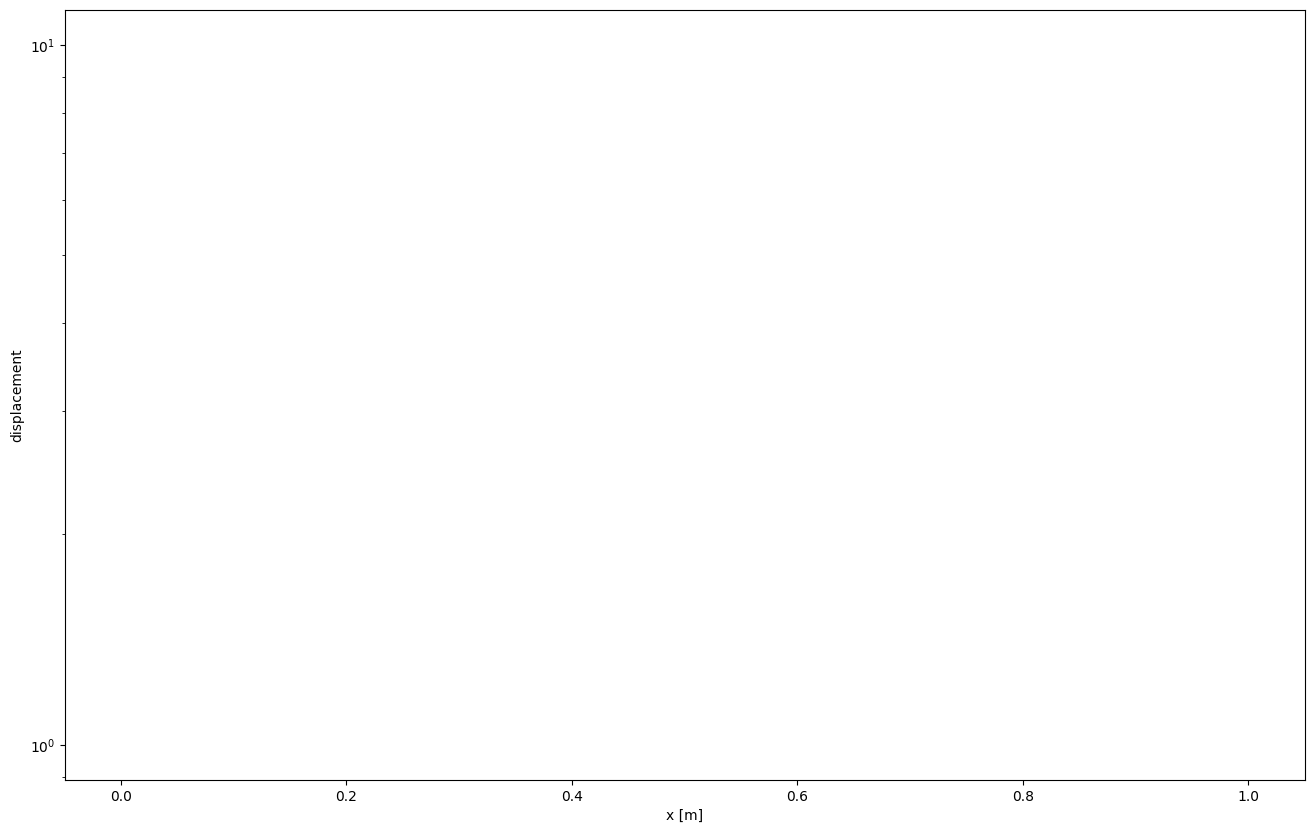

reached time t=0.008799999999999999


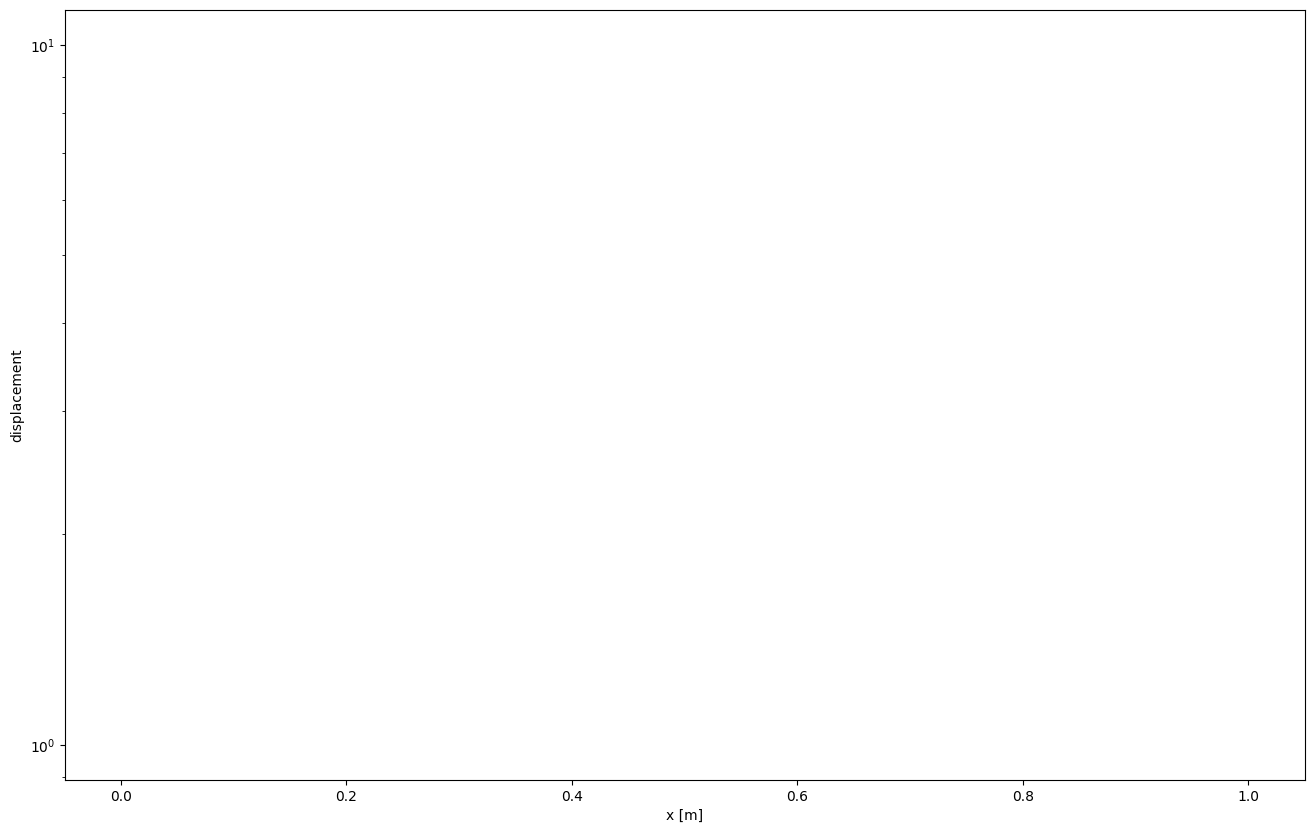

reached time t=0.009


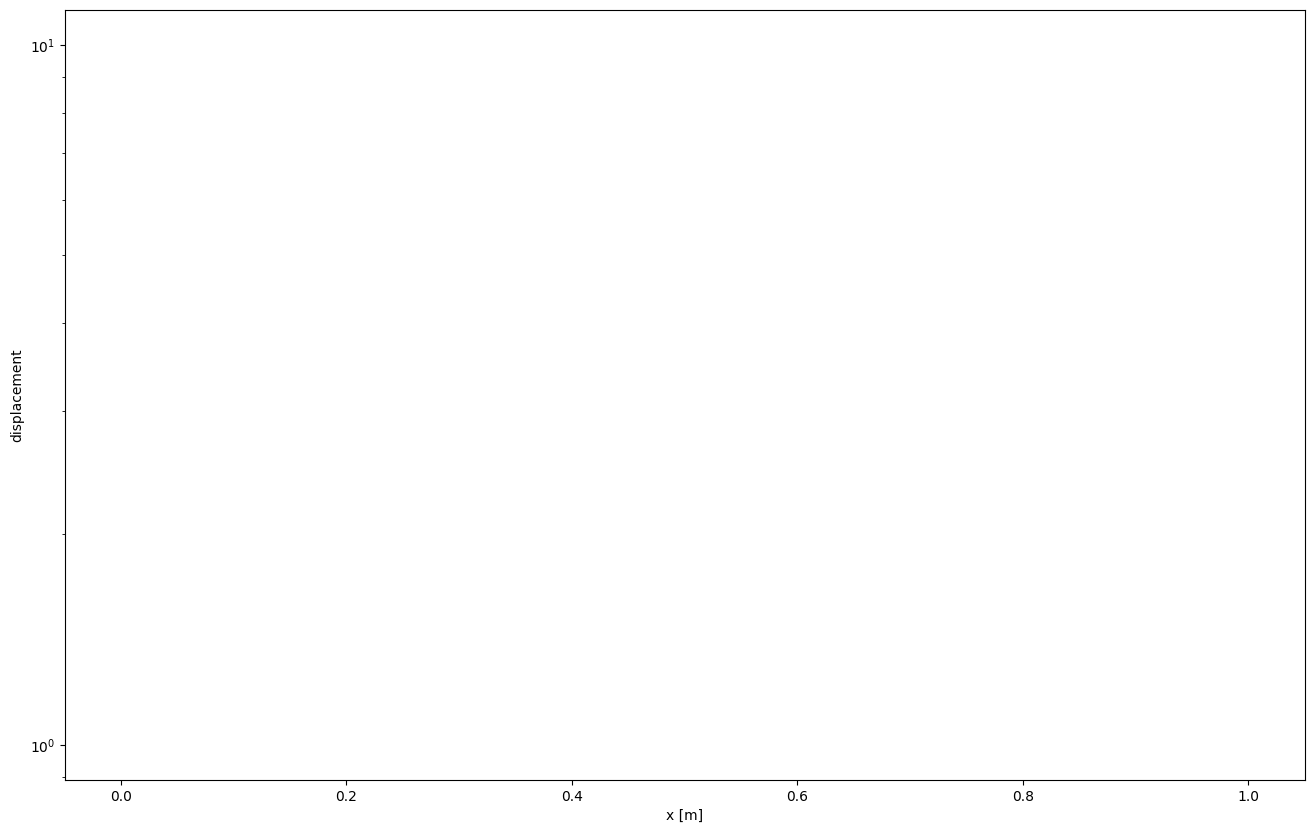

reached time t=0.0092


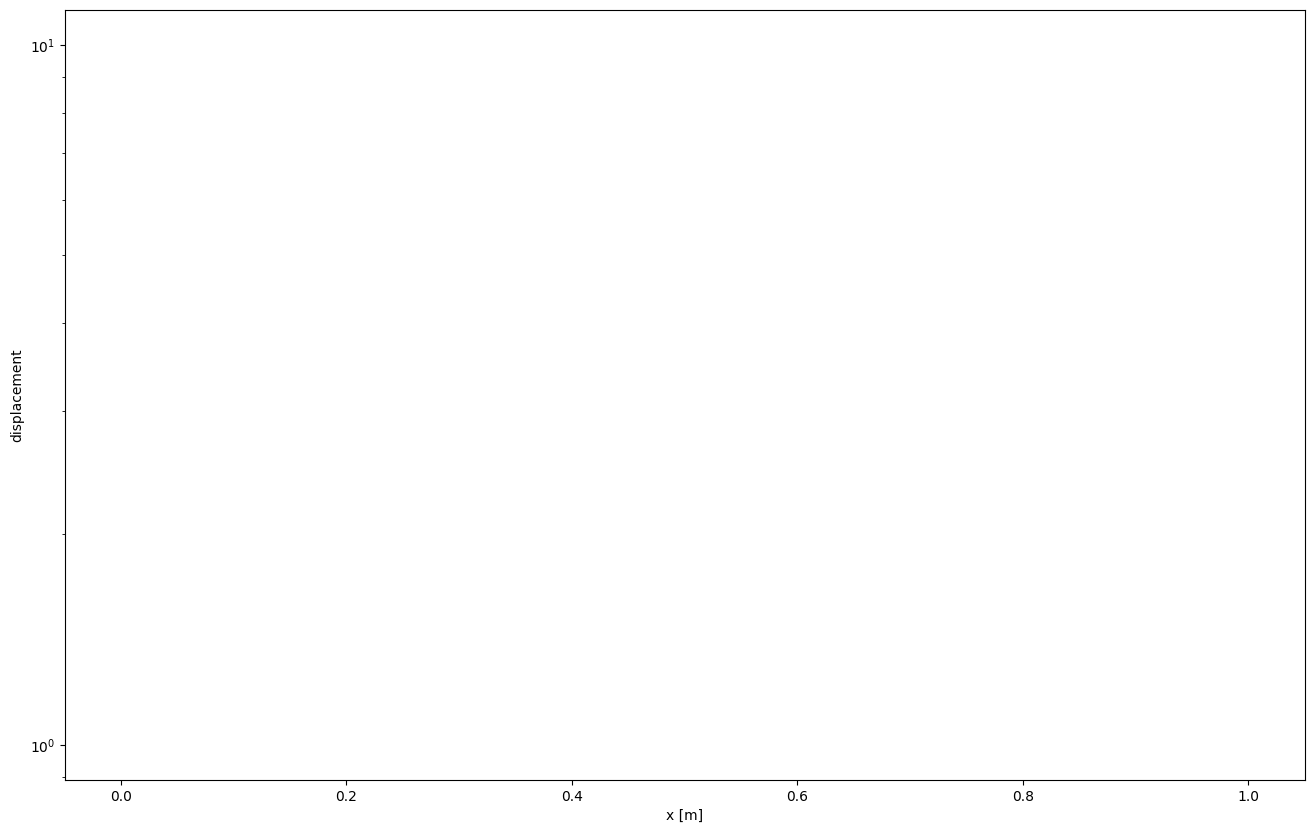

reached time t=0.0094


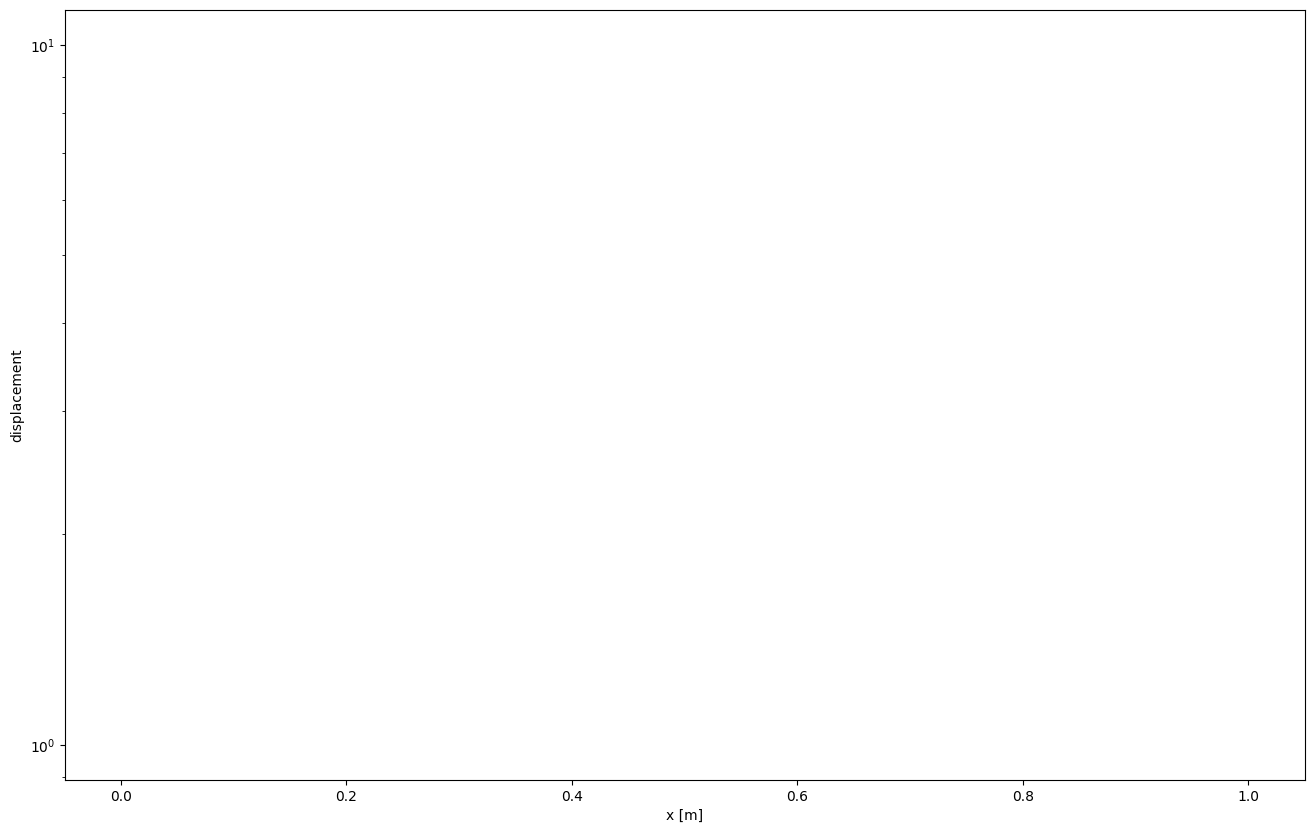

reached time t=0.0096


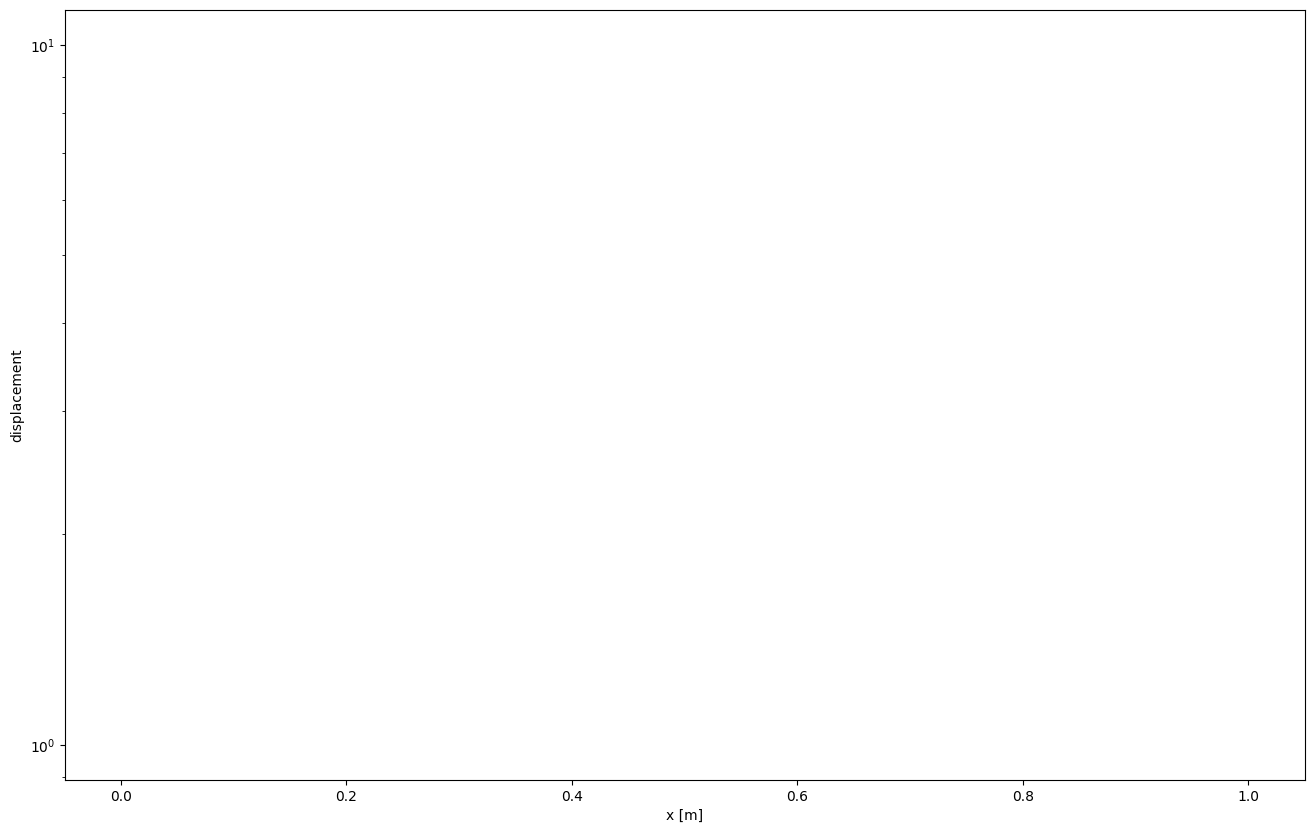

reached time t=0.0098


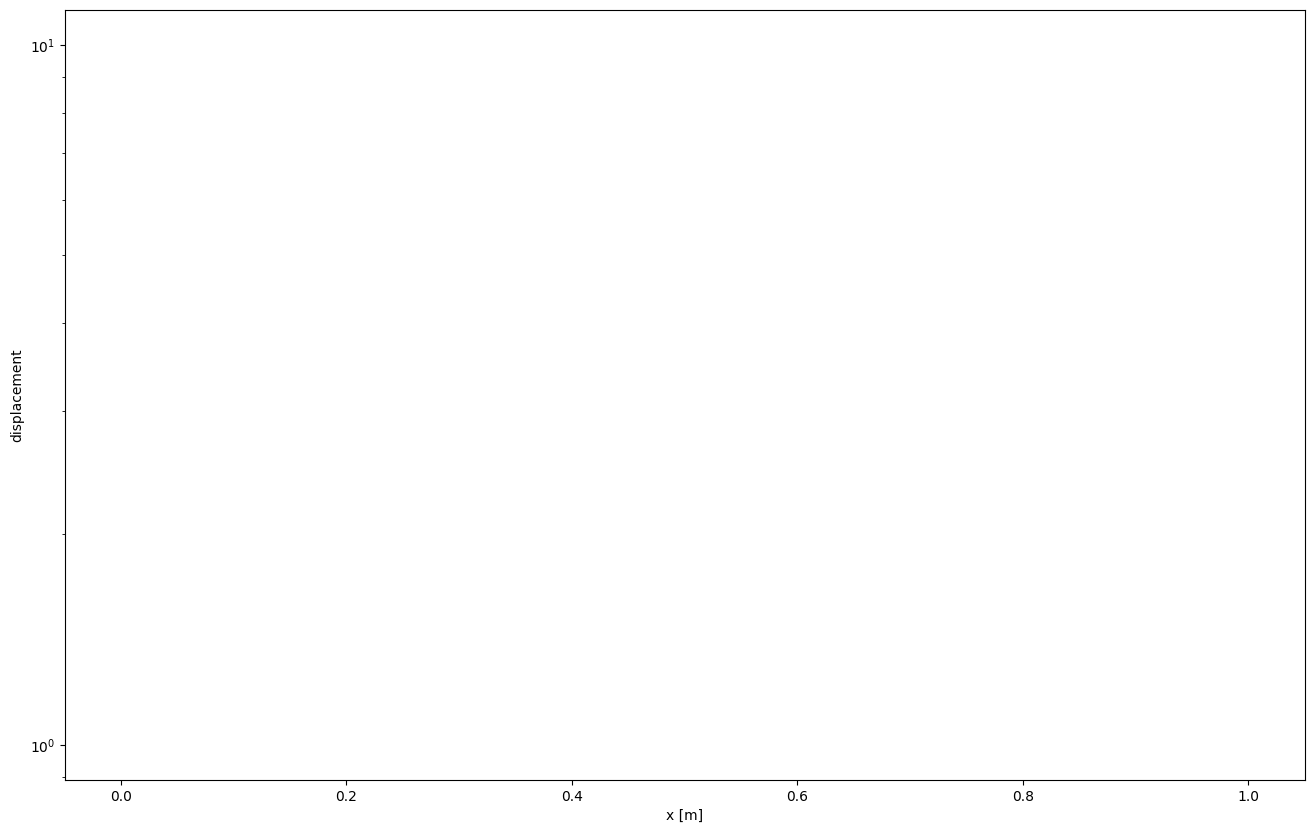

reached time t=0.01


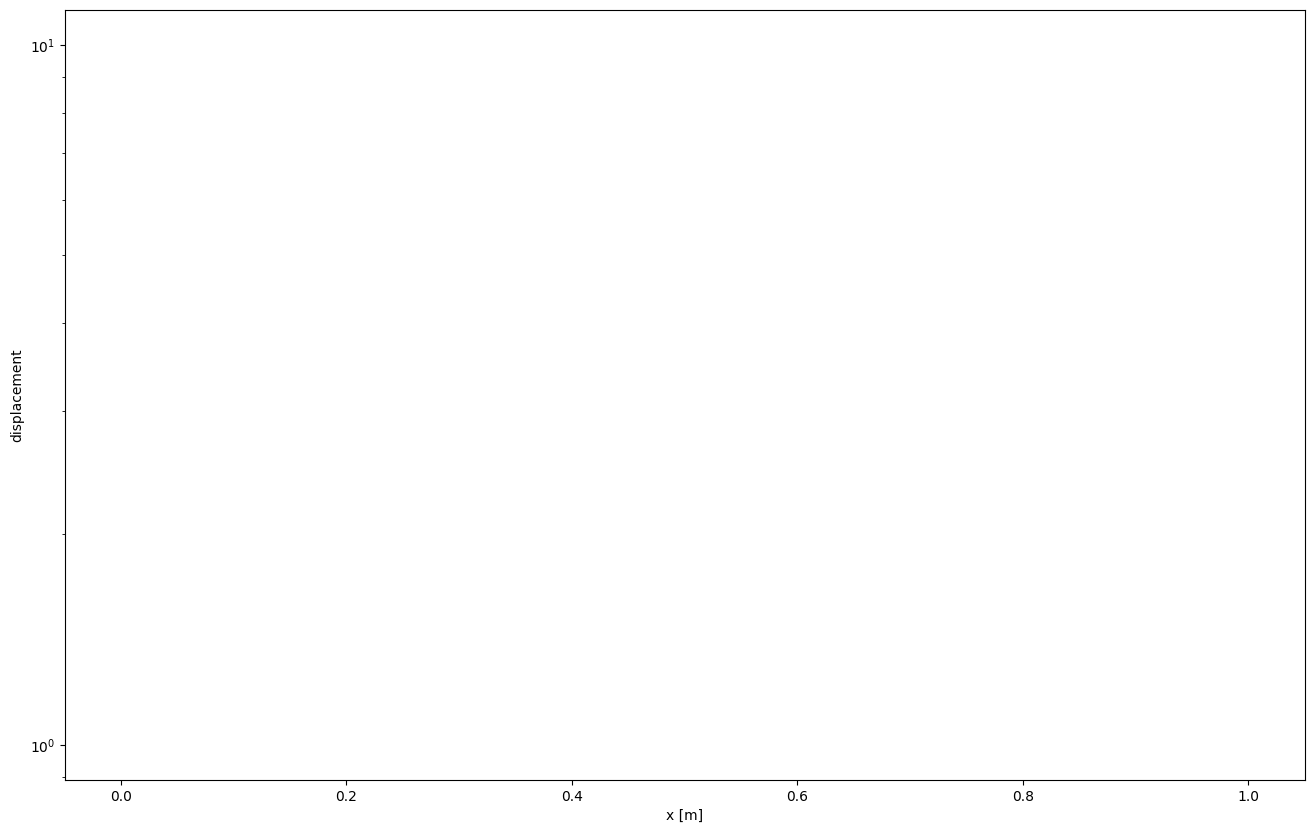

reached time t=0.010199999999999999


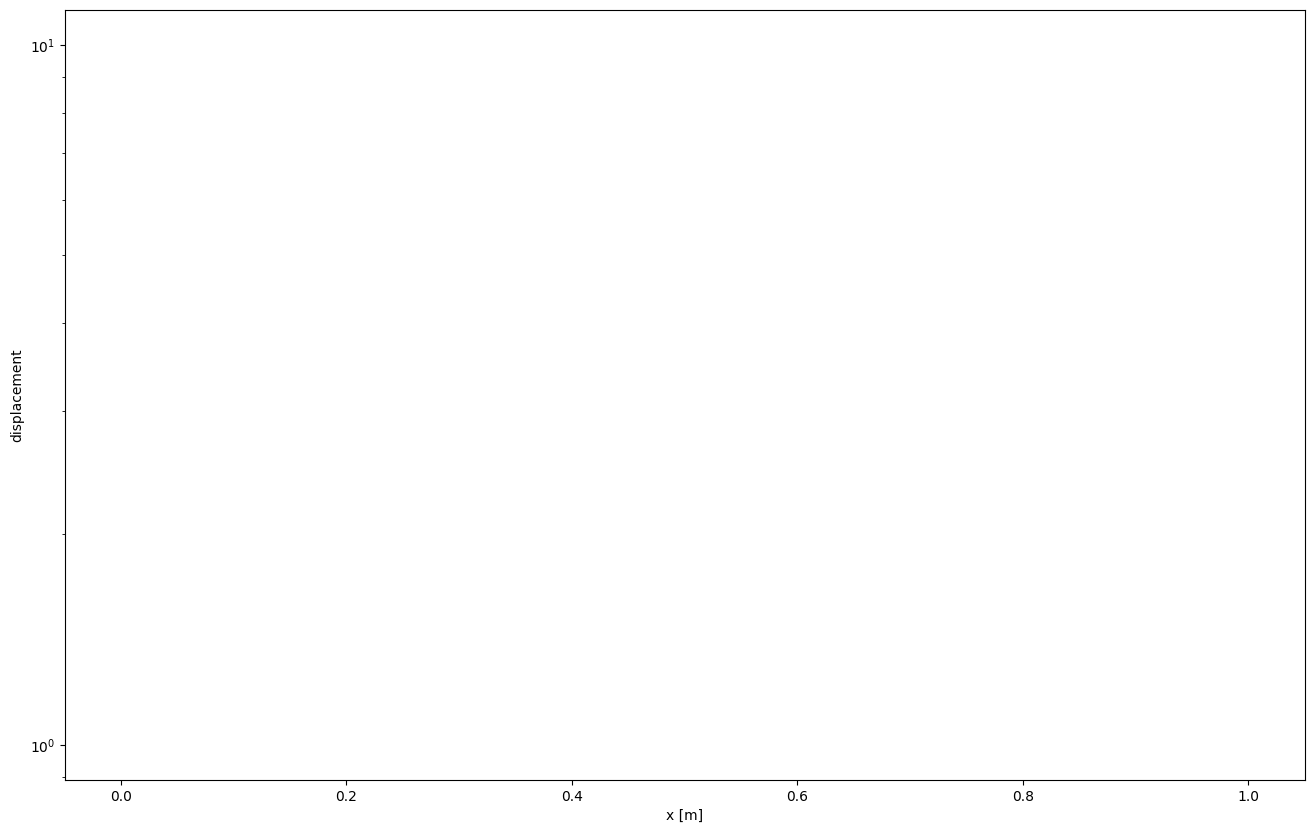

reached time t=0.0104


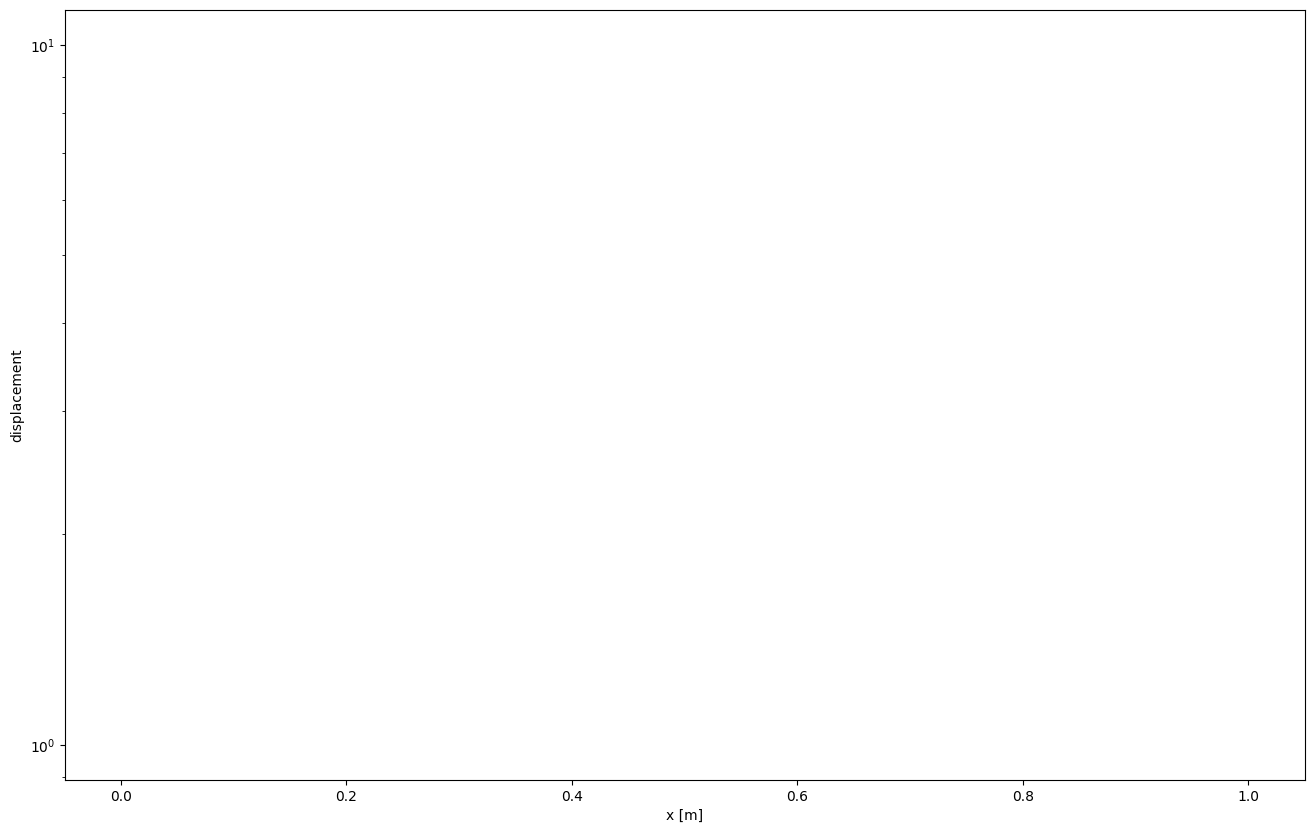

reached time t=0.0106


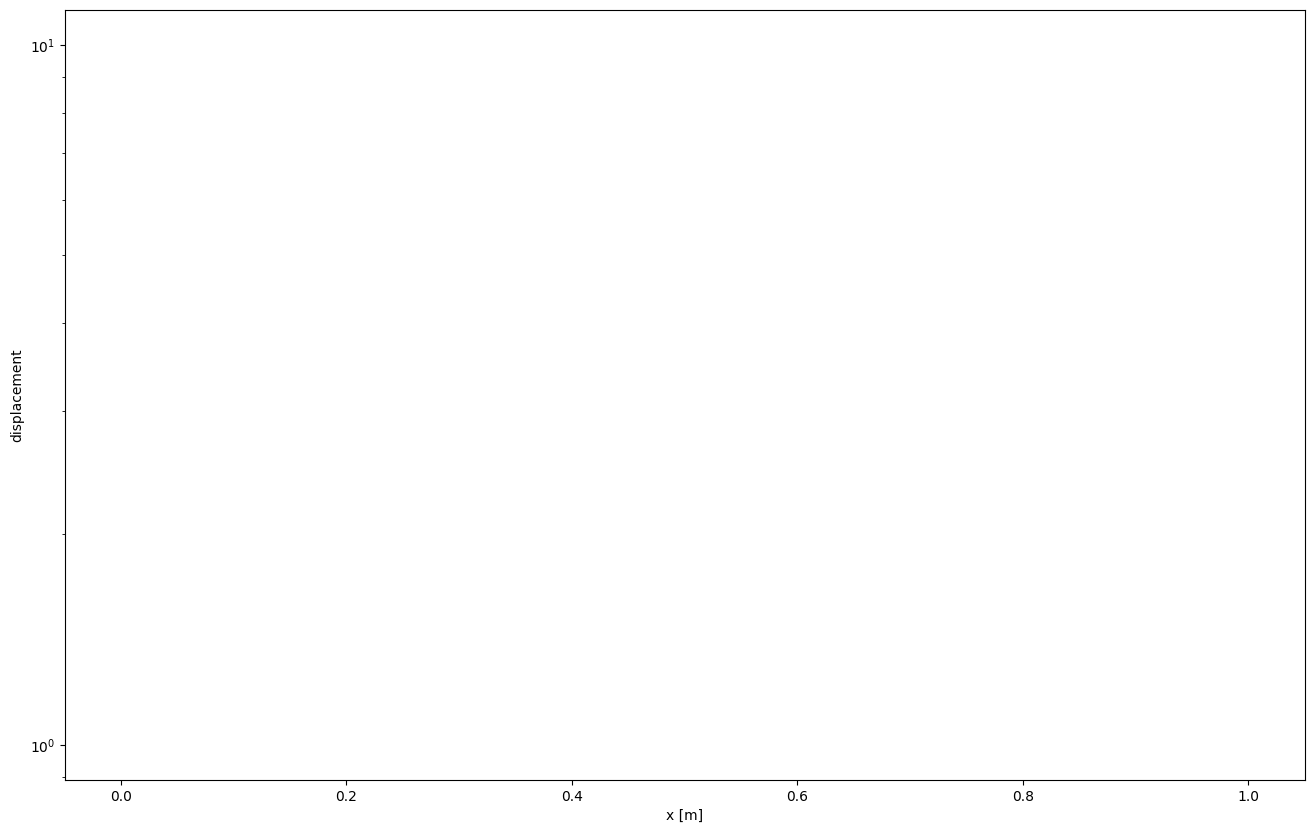

reached time t=0.010799999999999999


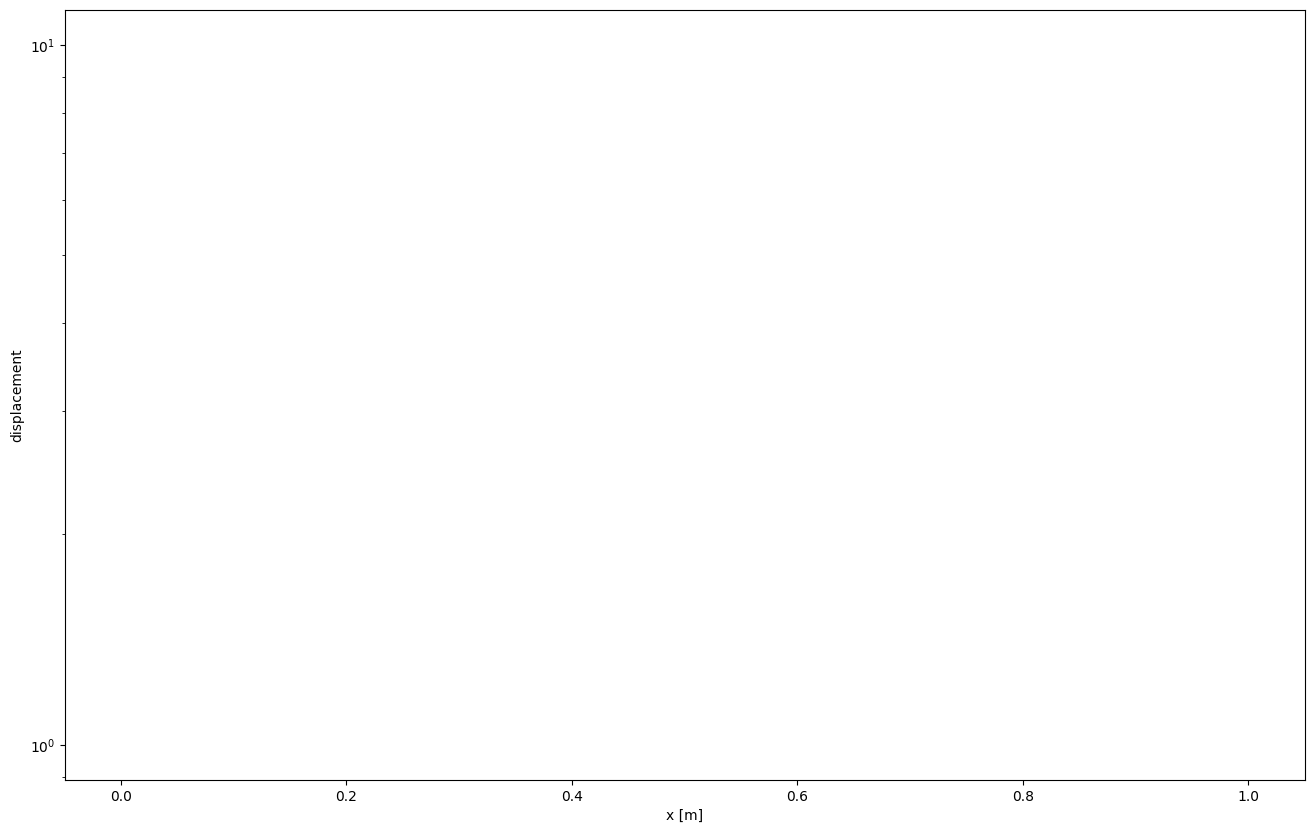

reached time t=0.011


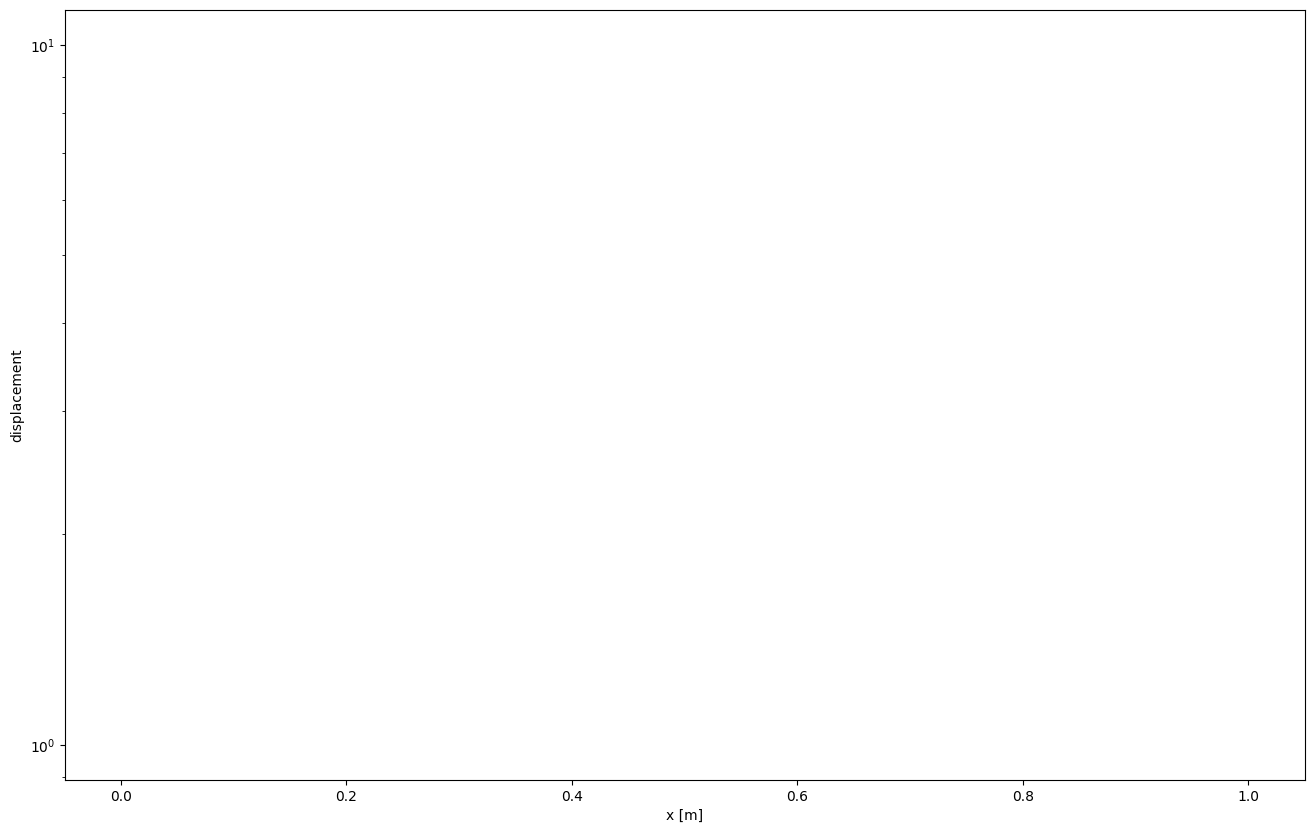

reached time t=0.0112


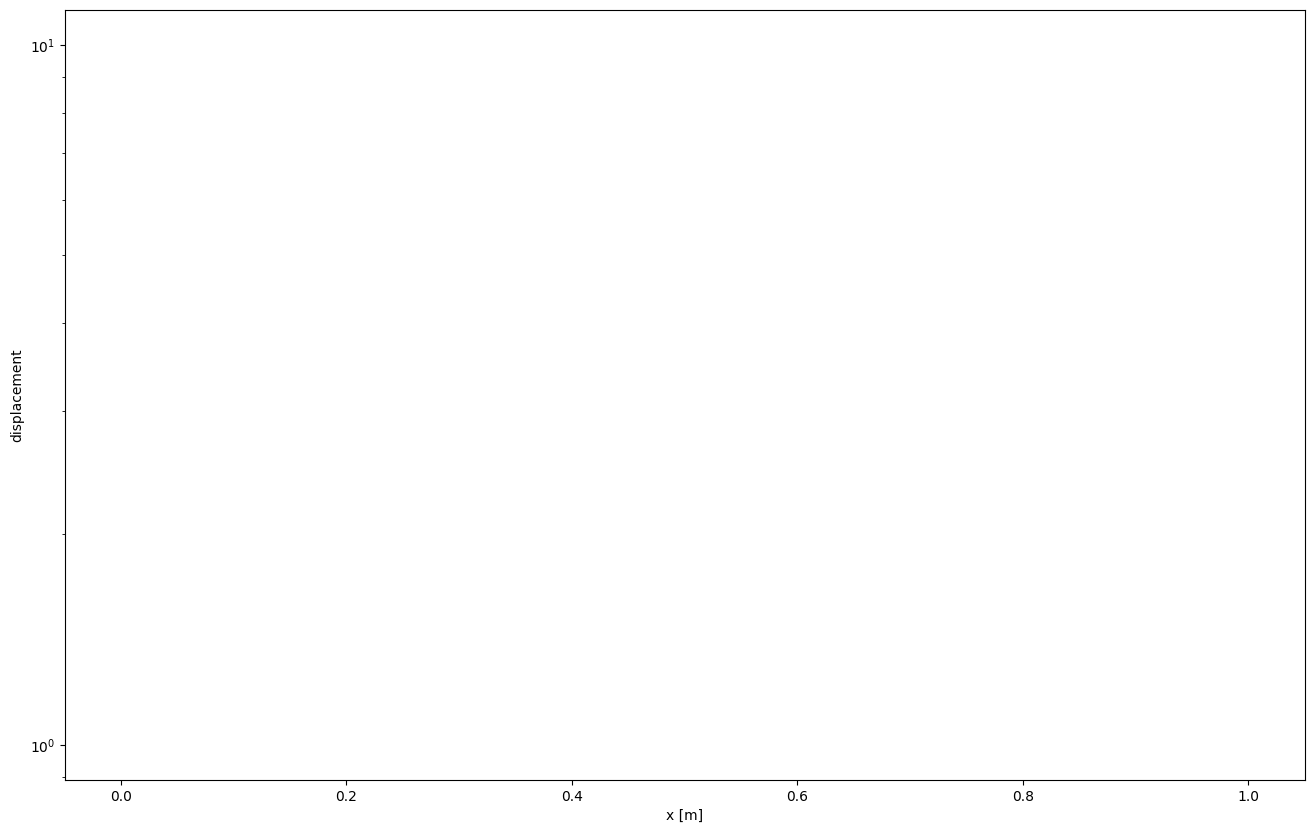

reached time t=0.011399999999999999


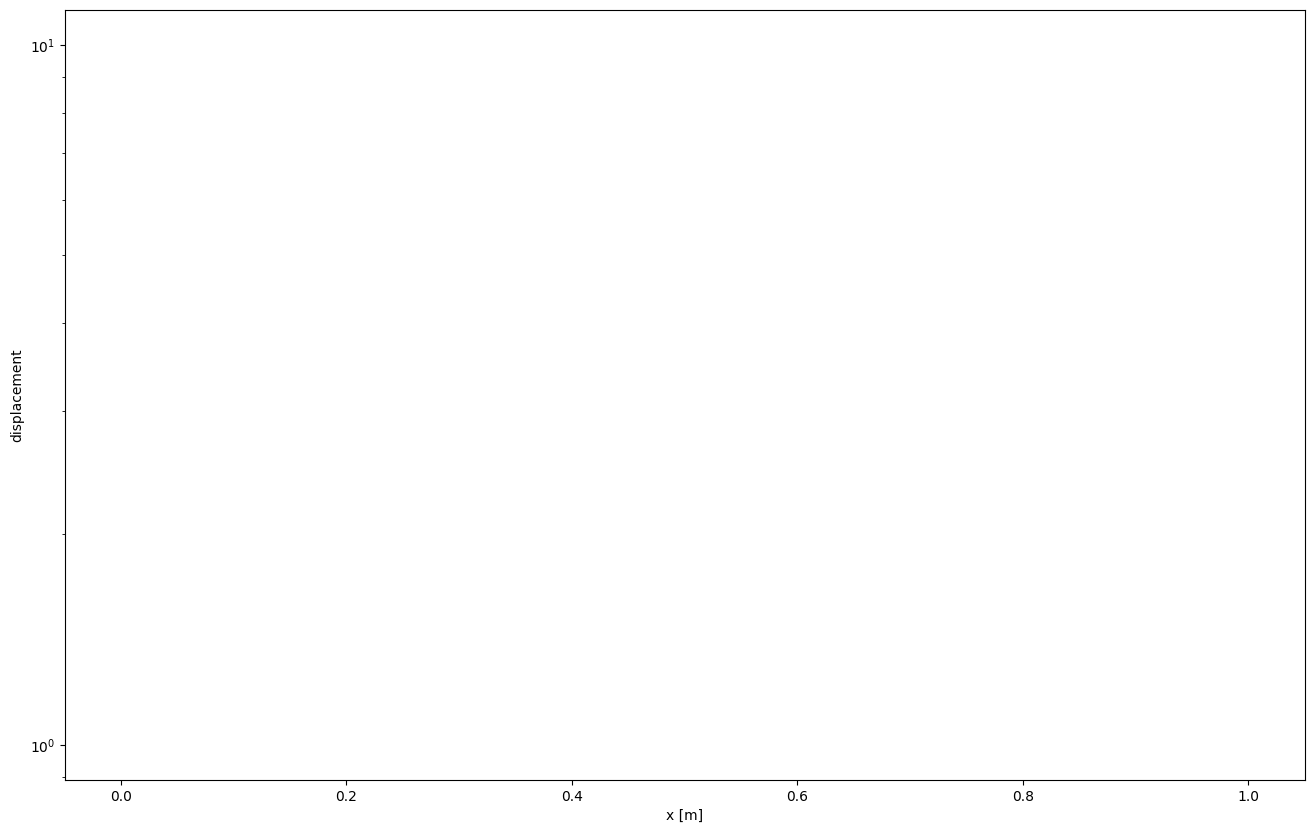

reached time t=0.0116


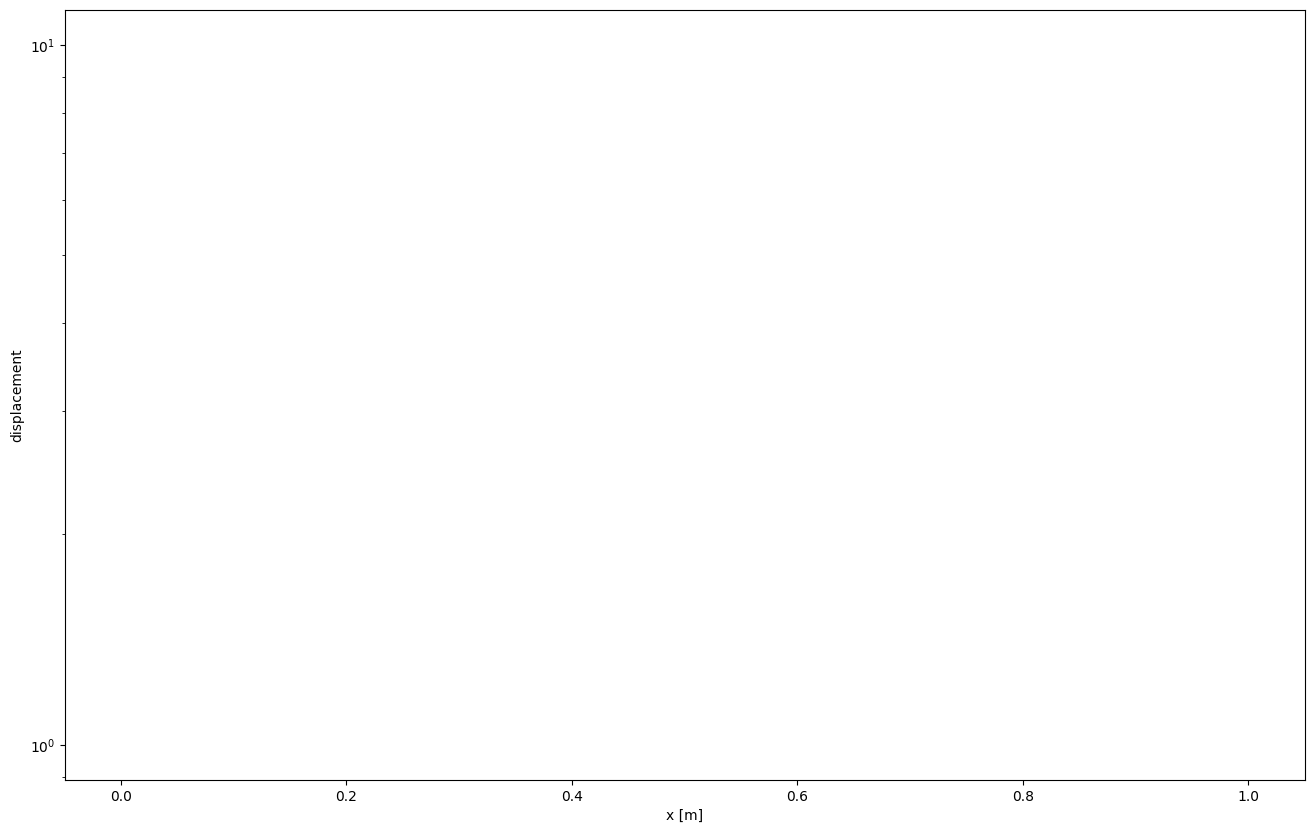

reached time t=0.0118


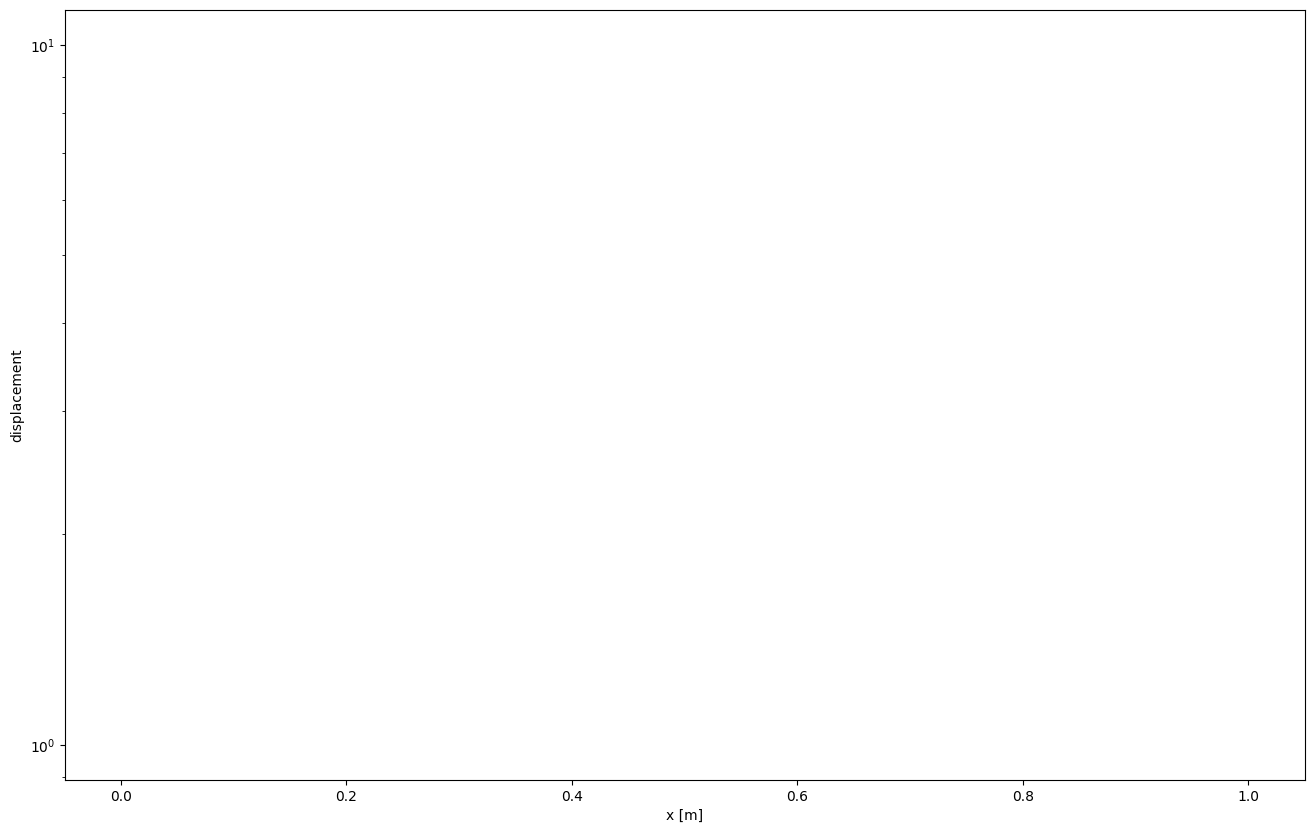

reached time t=0.012


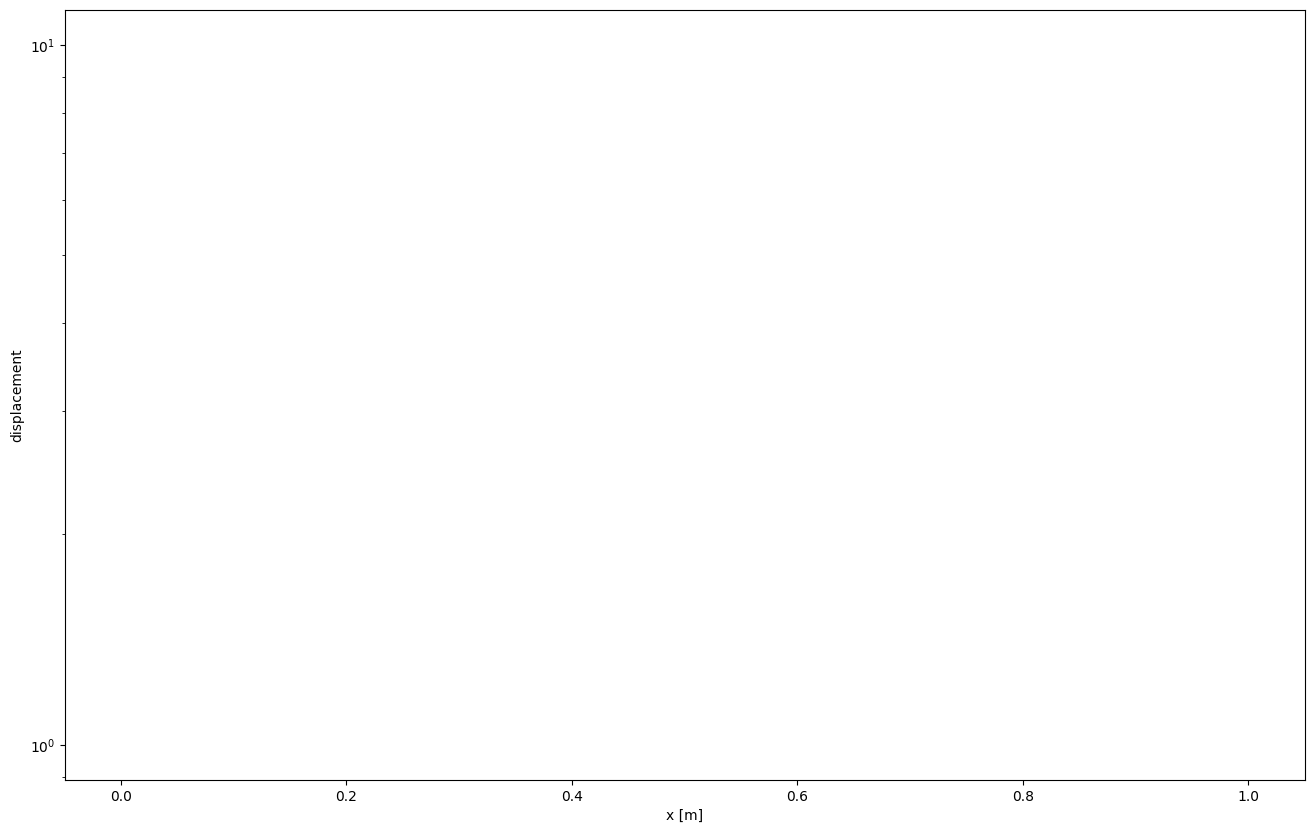

reached time t=0.012199999999999999


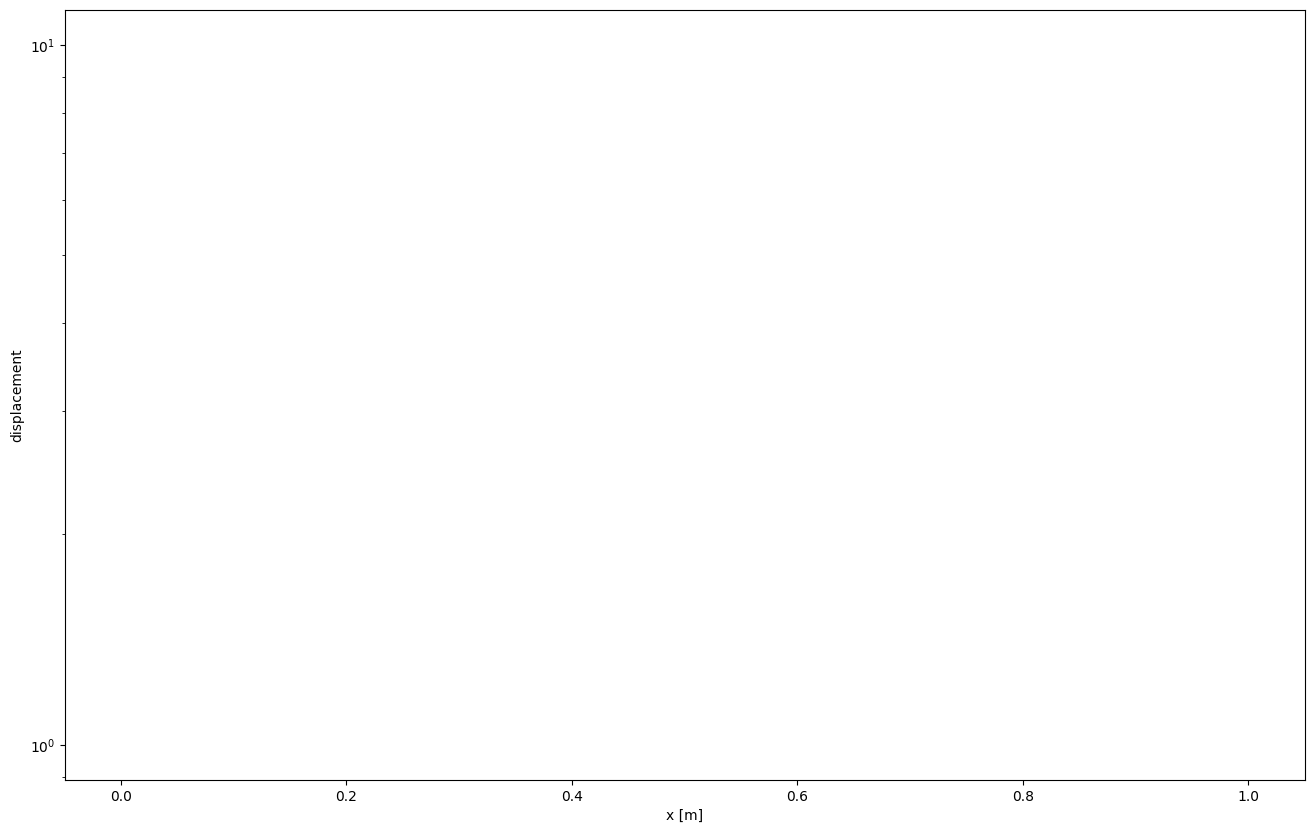

reached time t=0.0124


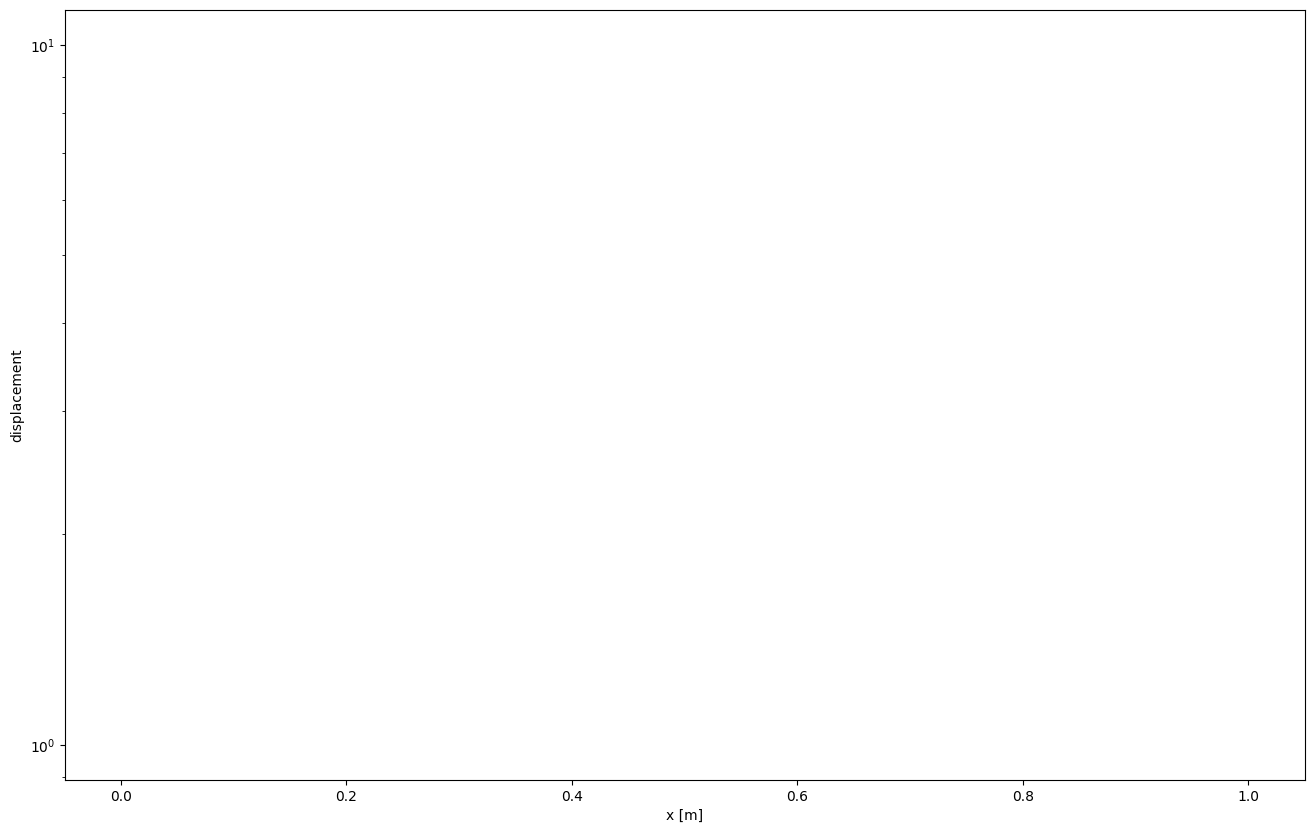

reached time t=0.0126


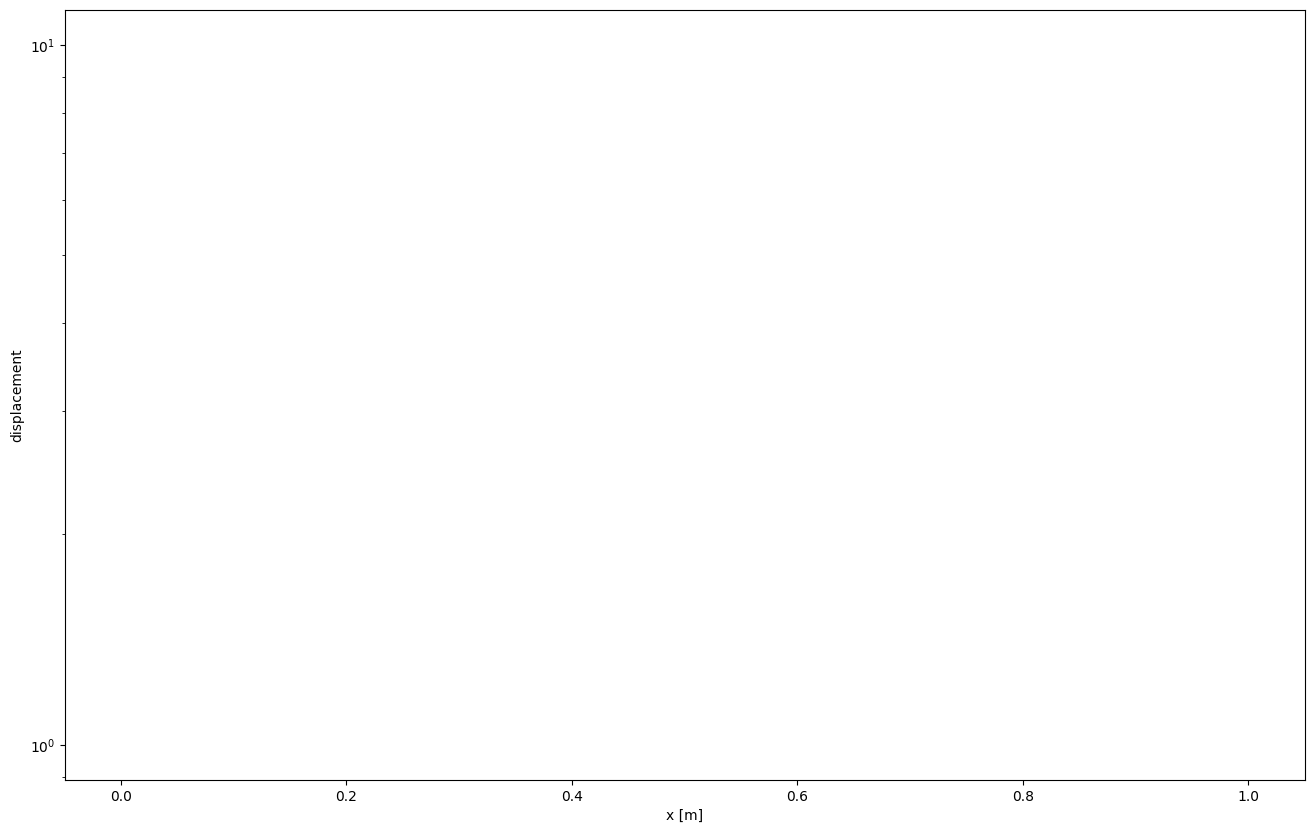

reached time t=0.012799999999999999


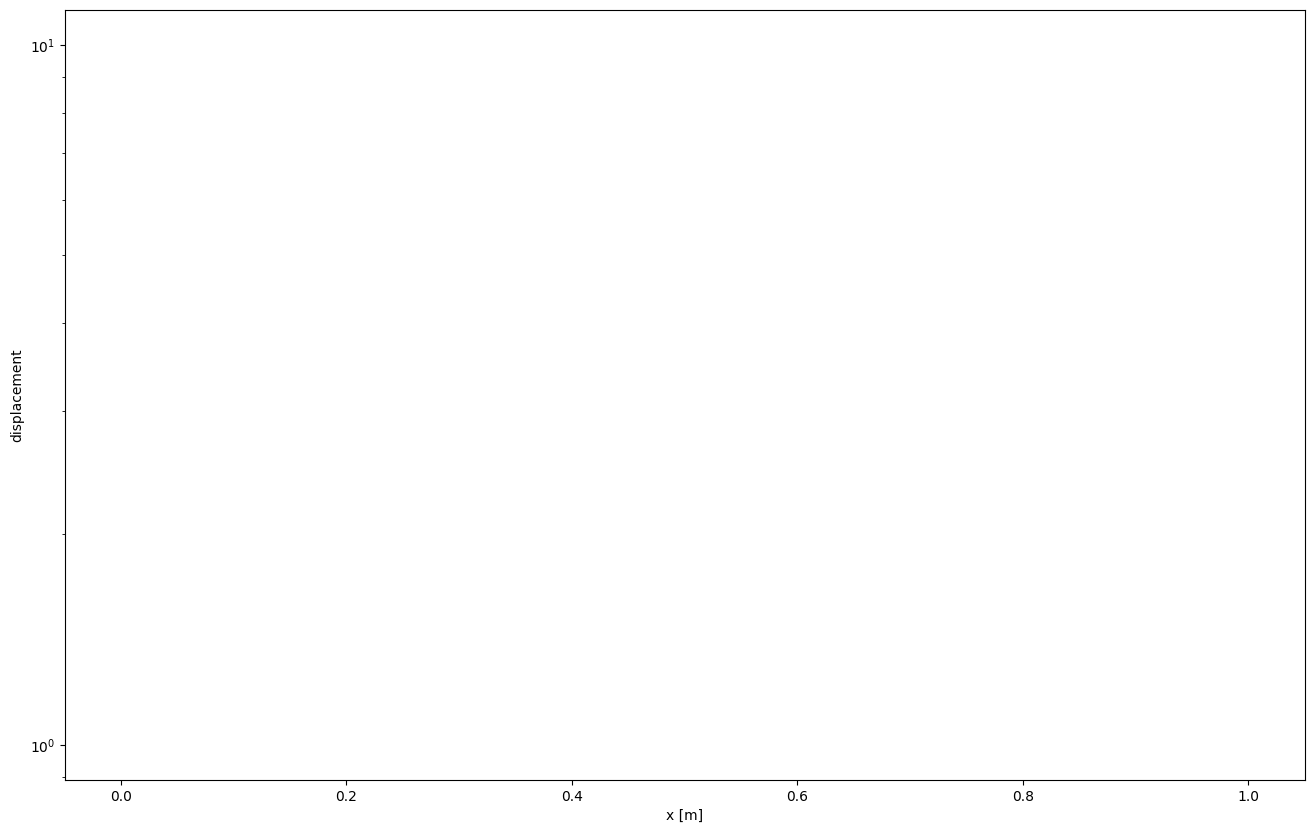

reached time t=0.013


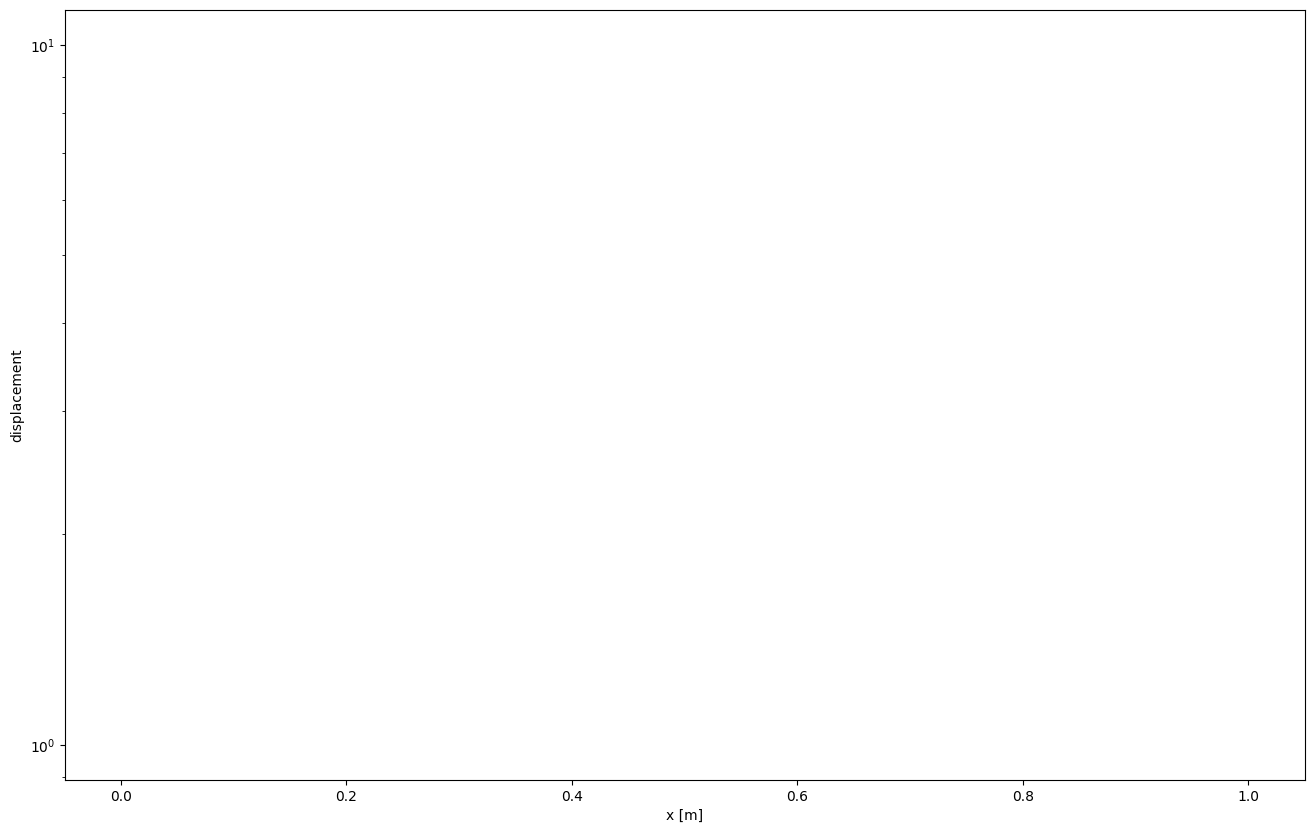

reached time t=0.0132


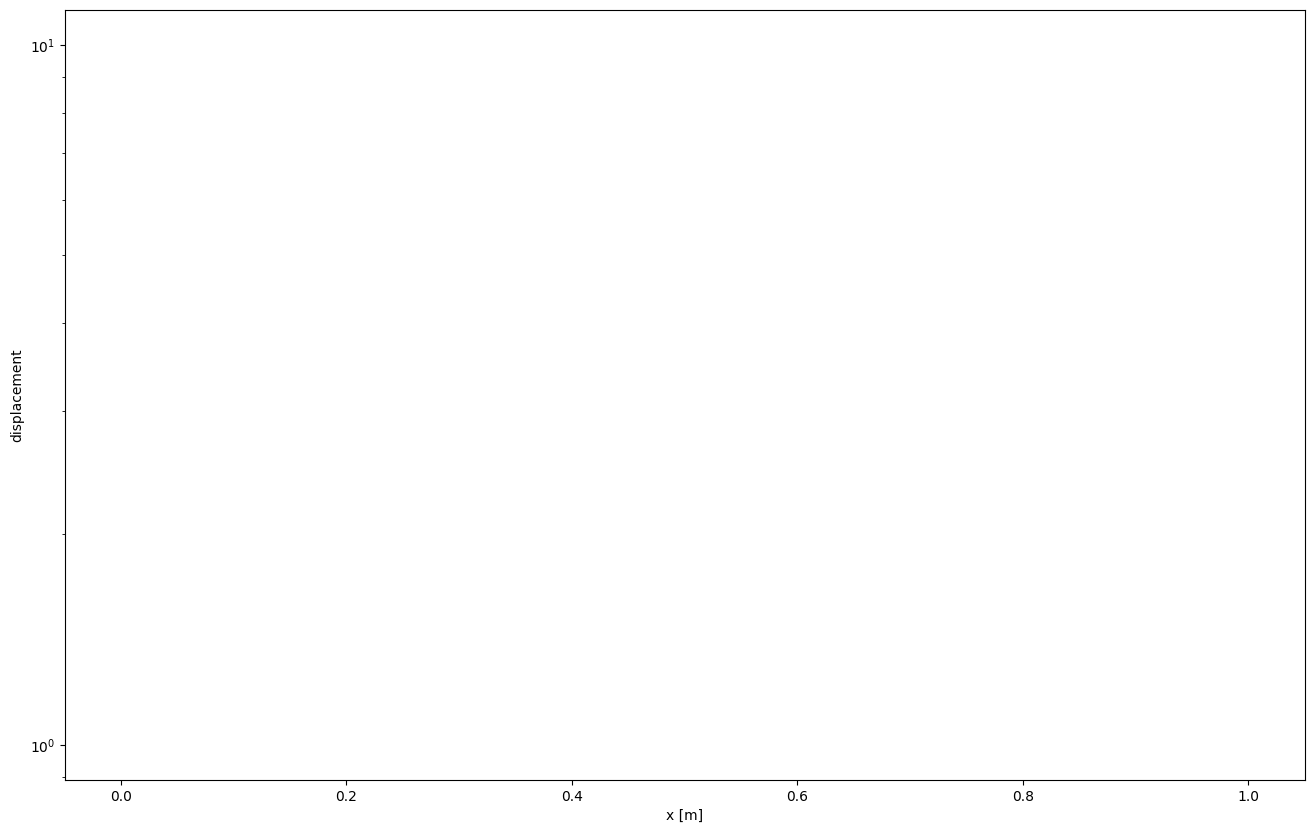

reached time t=0.013399999999999999


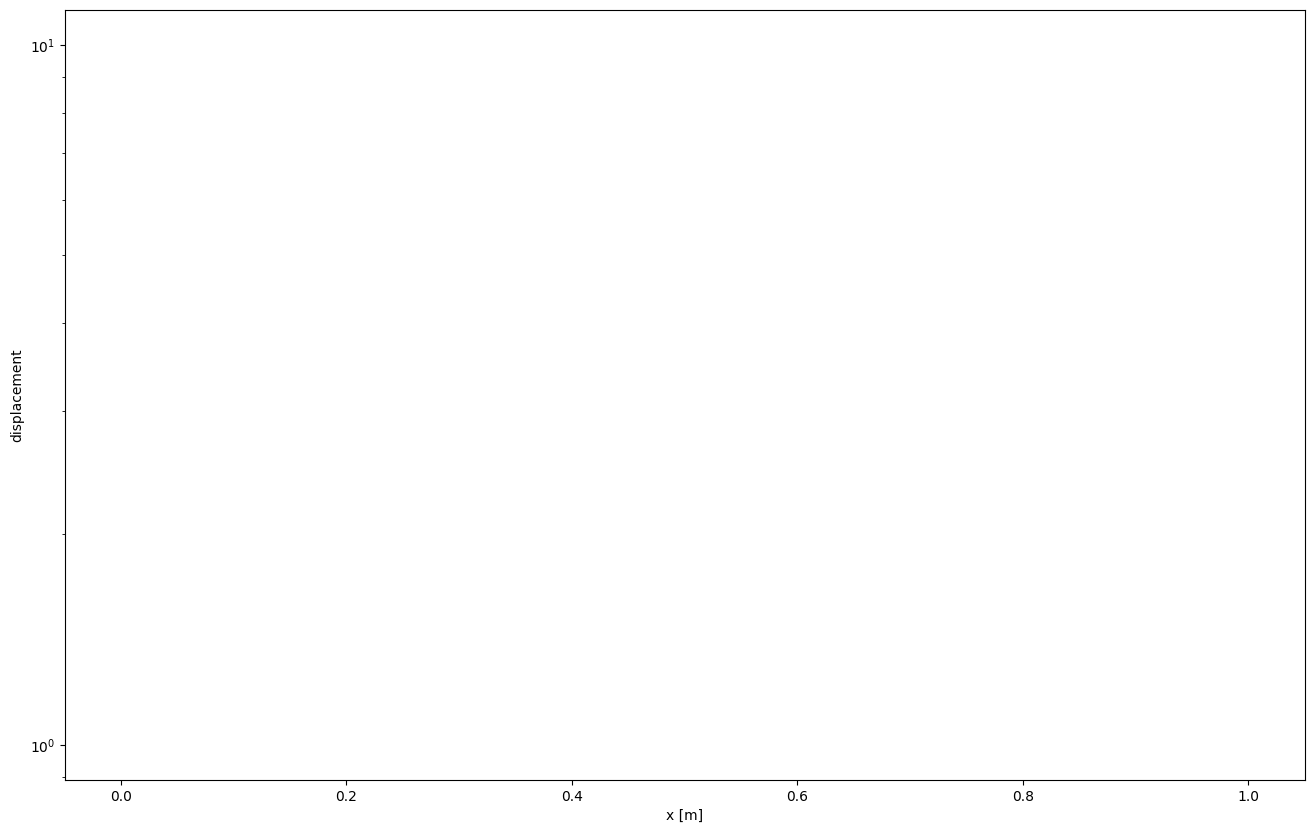

reached time t=0.0136


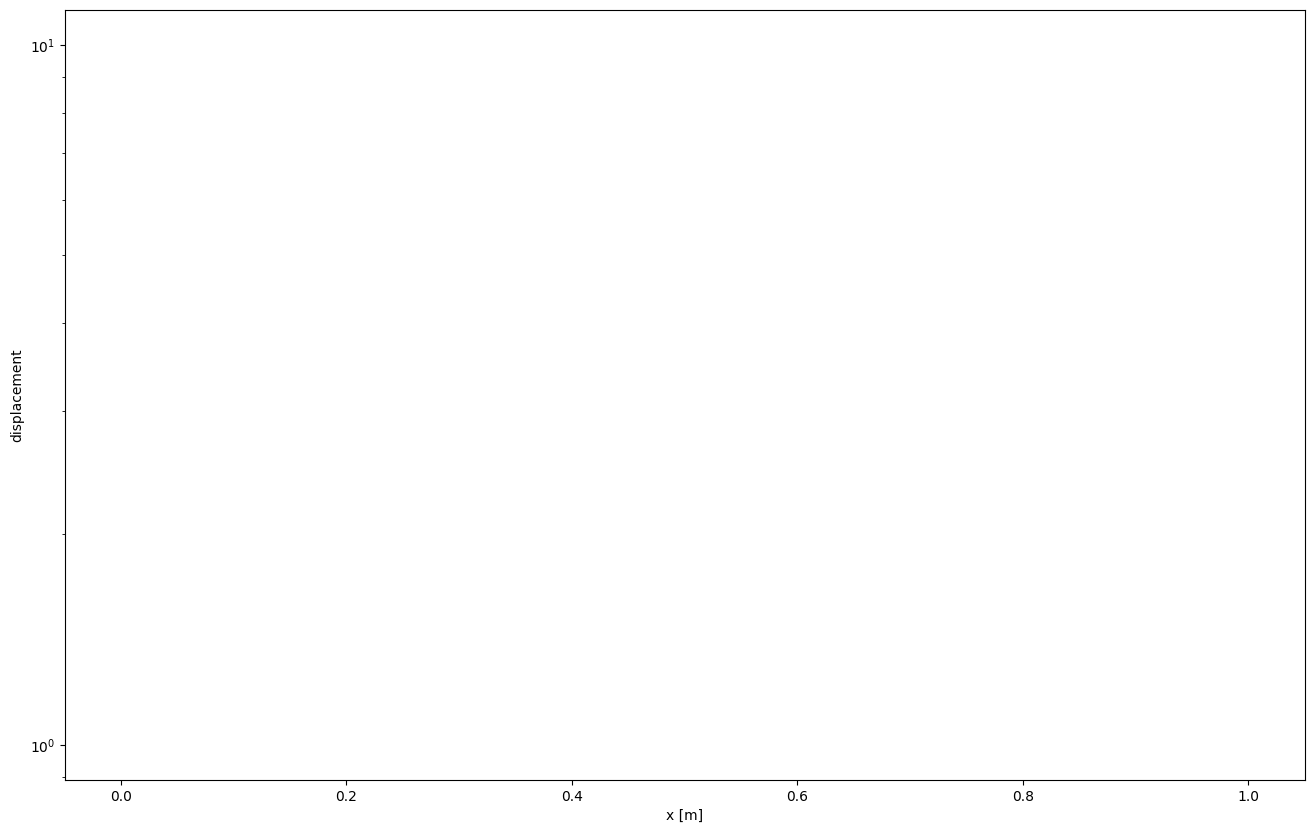

reached time t=0.0138


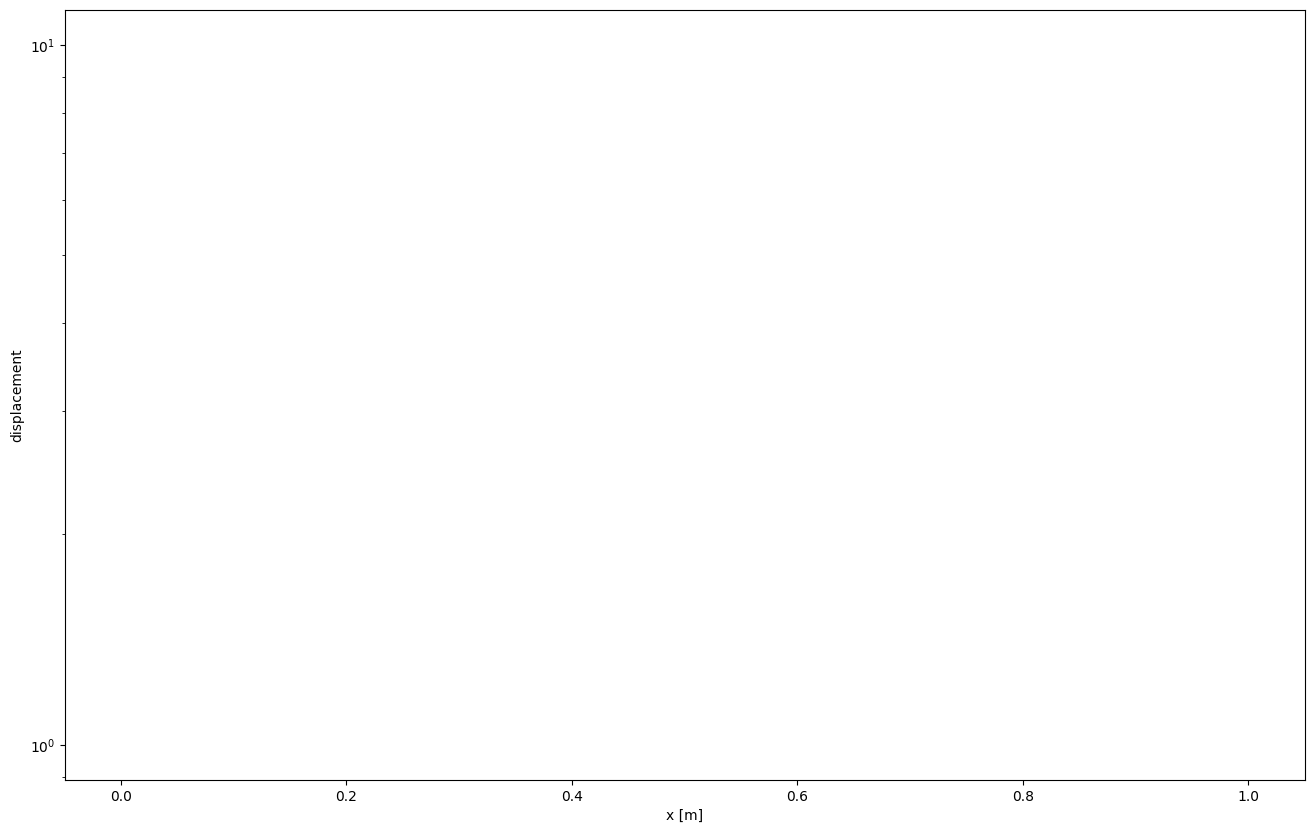

reached time t=0.013999999999999999


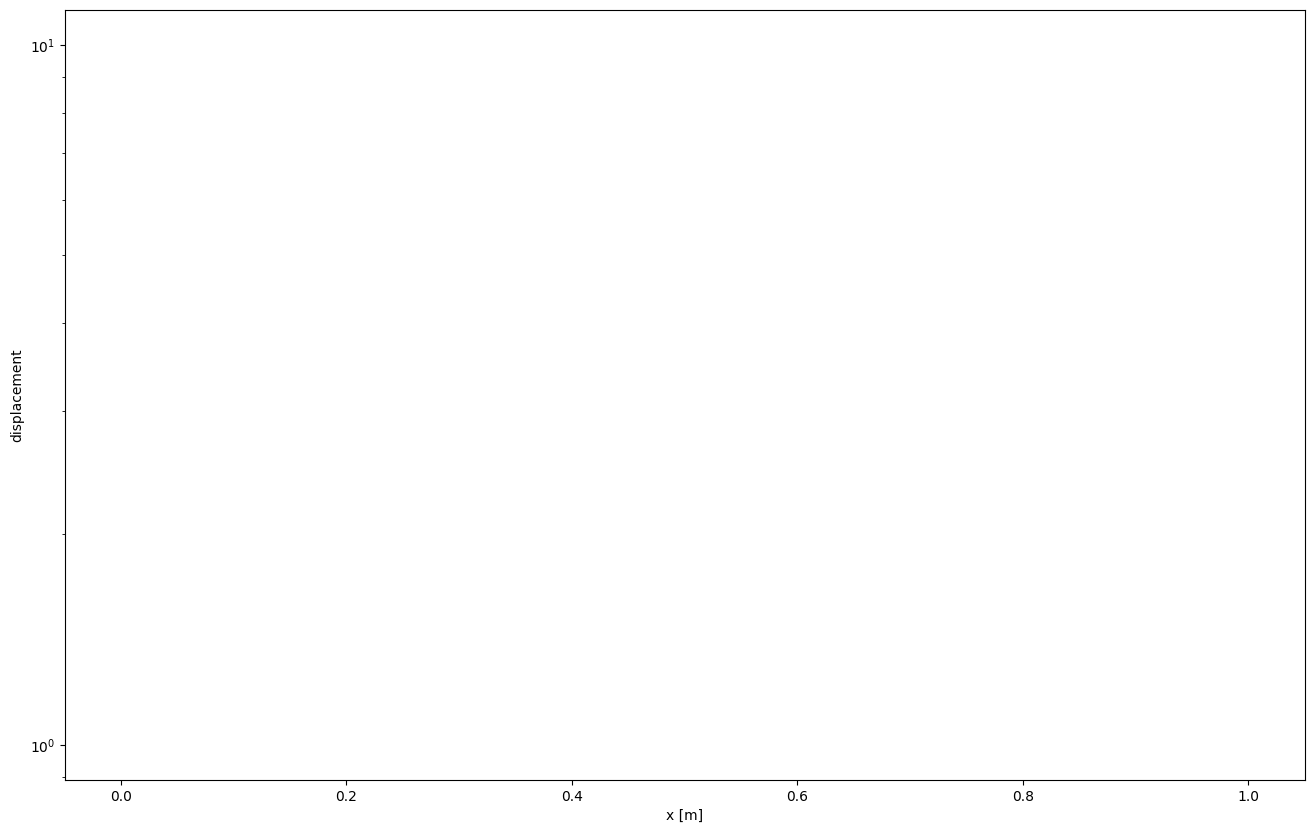

reached time t=0.014199999999999999


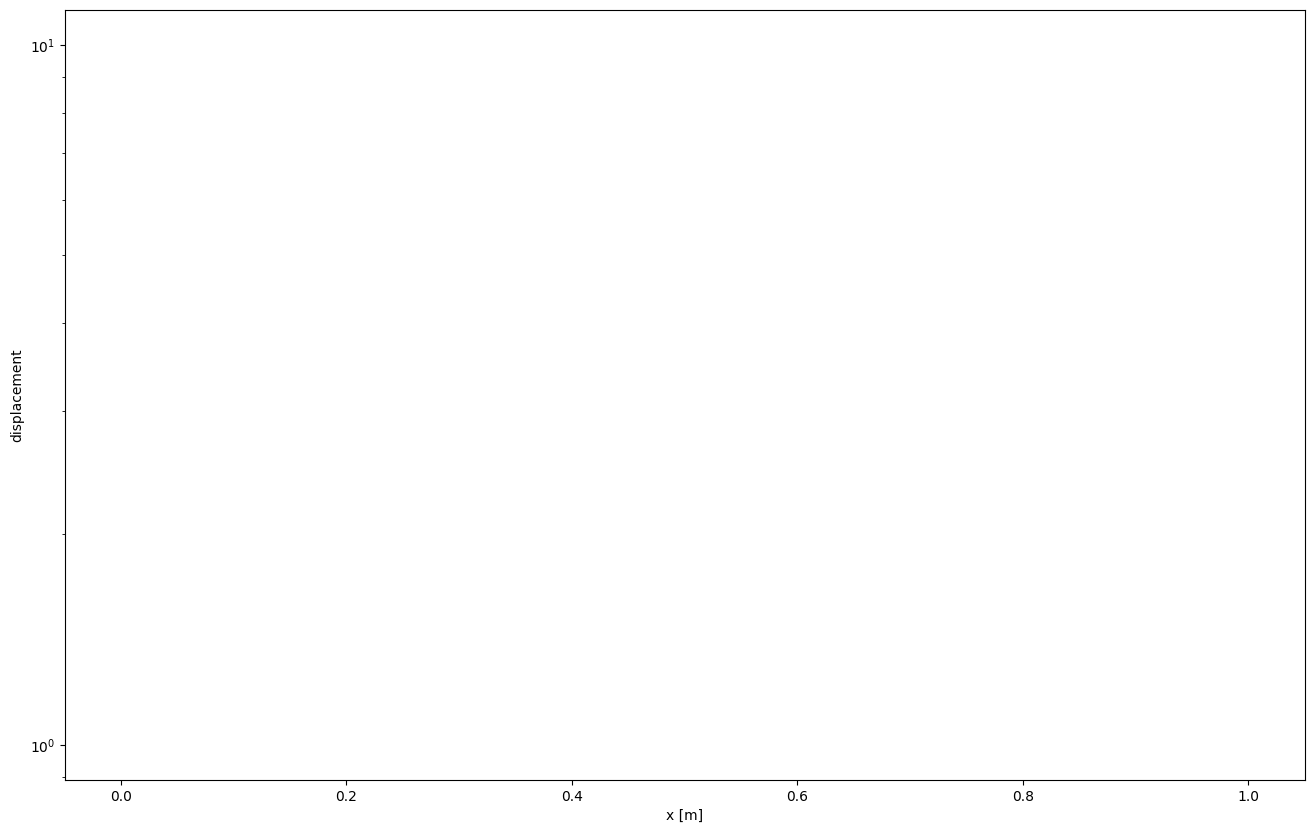

reached time t=0.0144


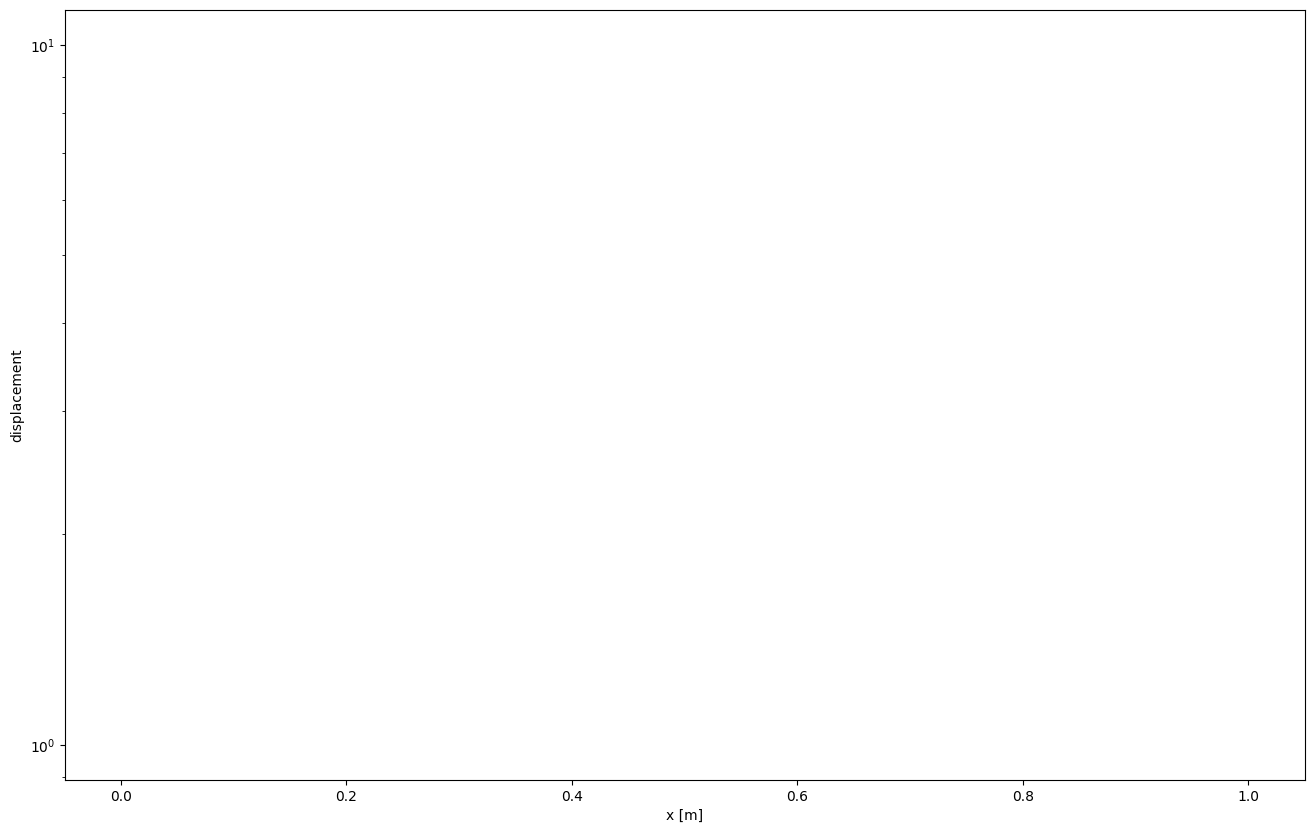

reached time t=0.0146


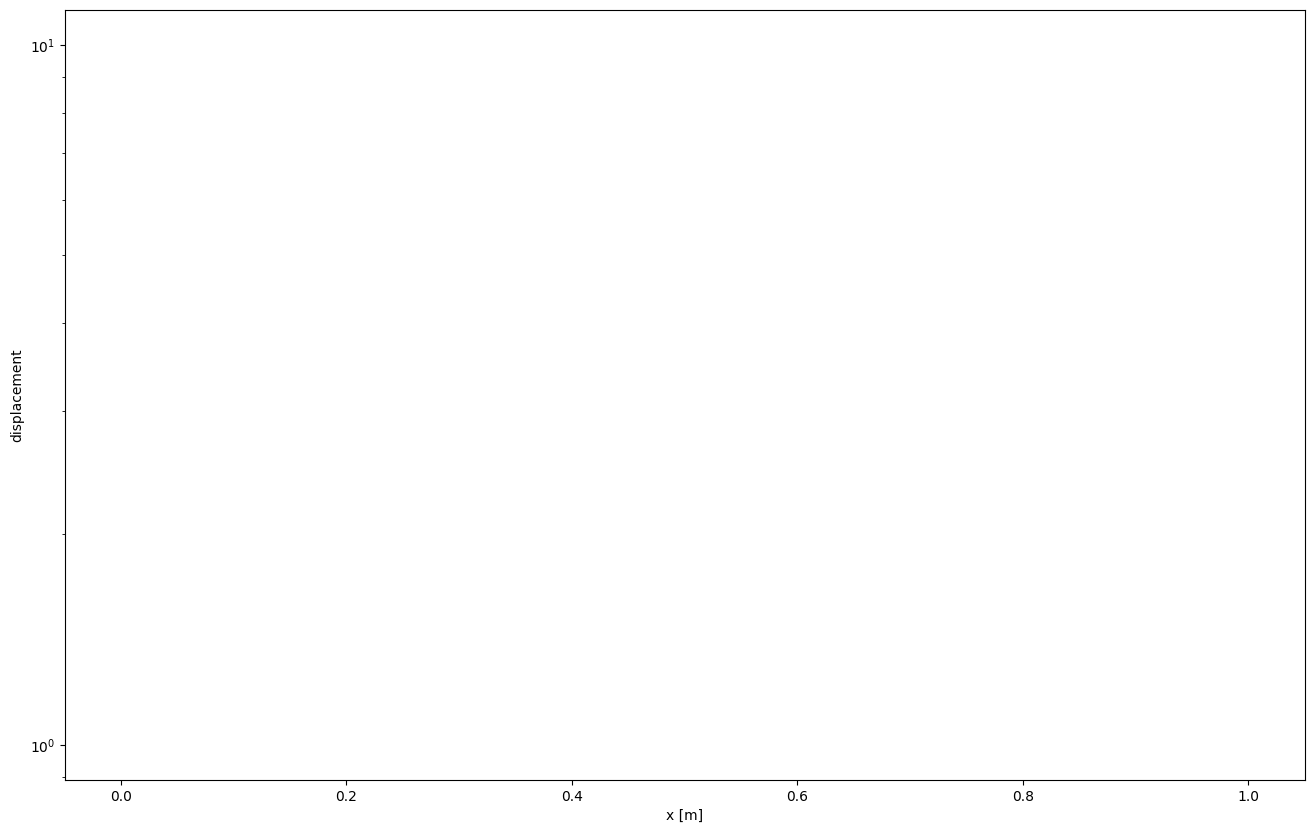

reached time t=0.014799999999999999


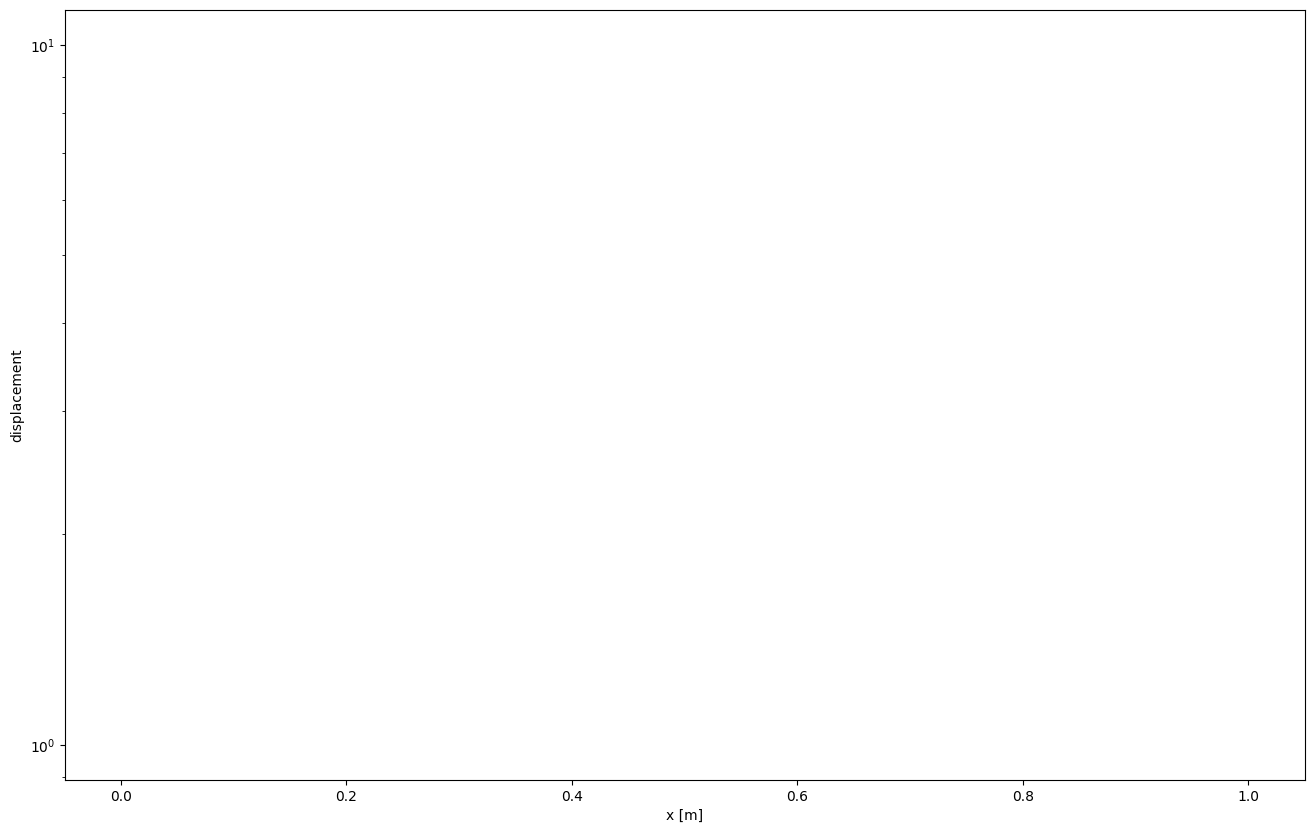

reached time t=0.015


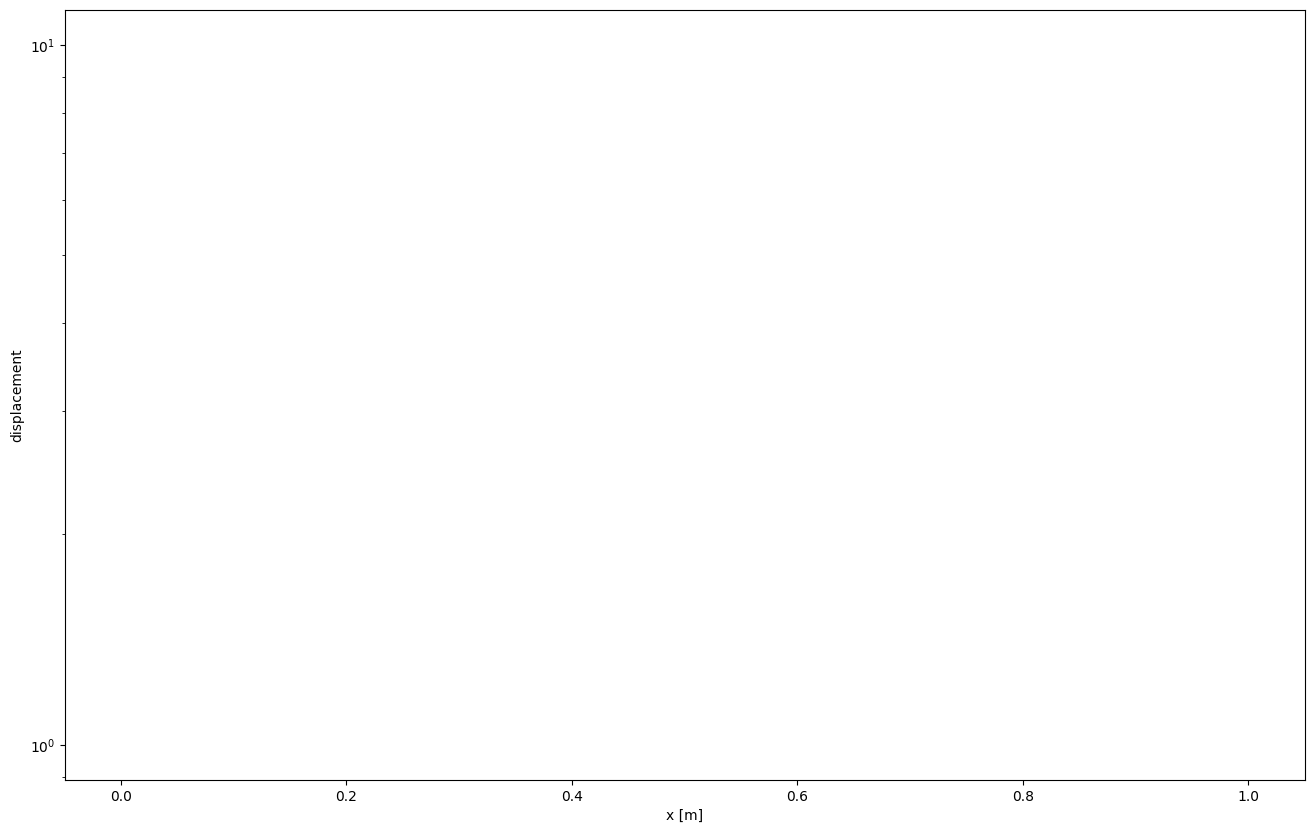

reached time t=0.0152


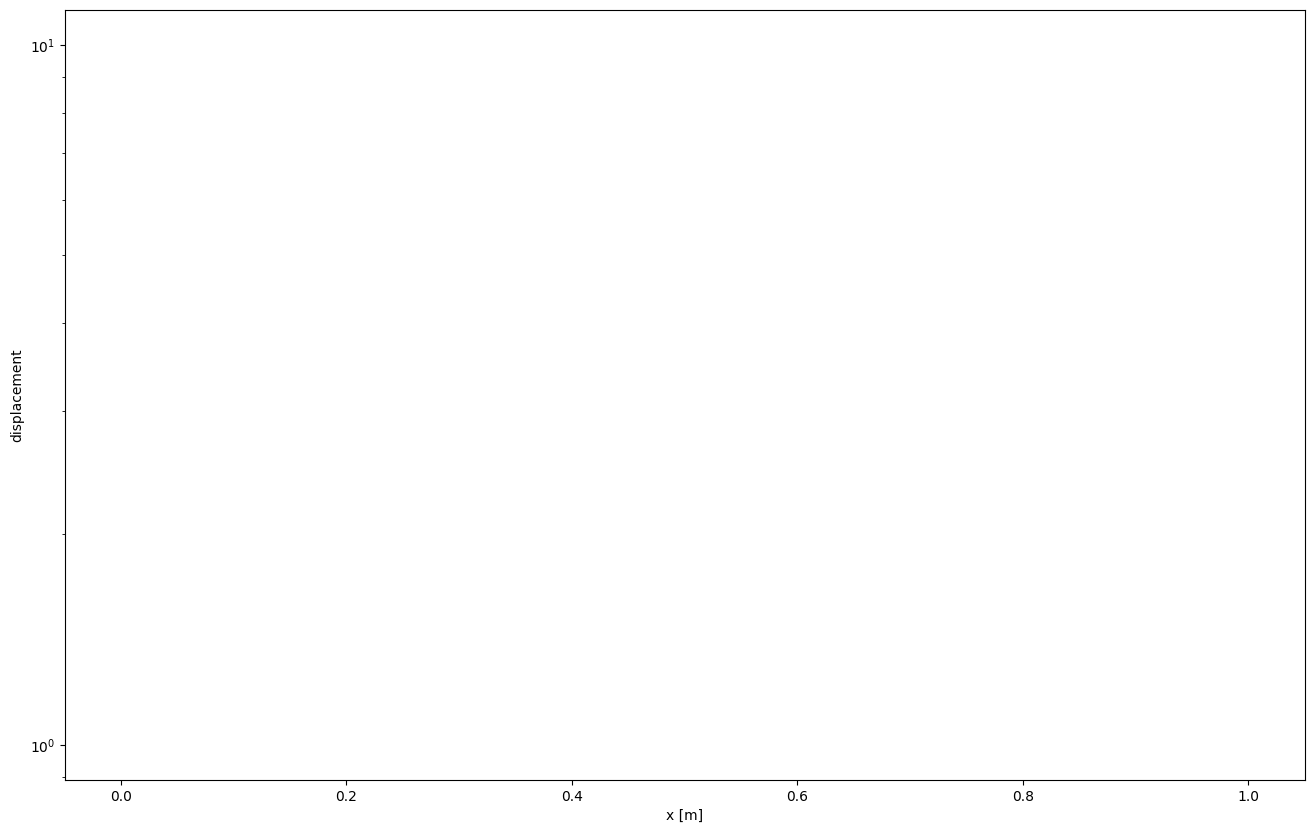

reached time t=0.015399999999999999


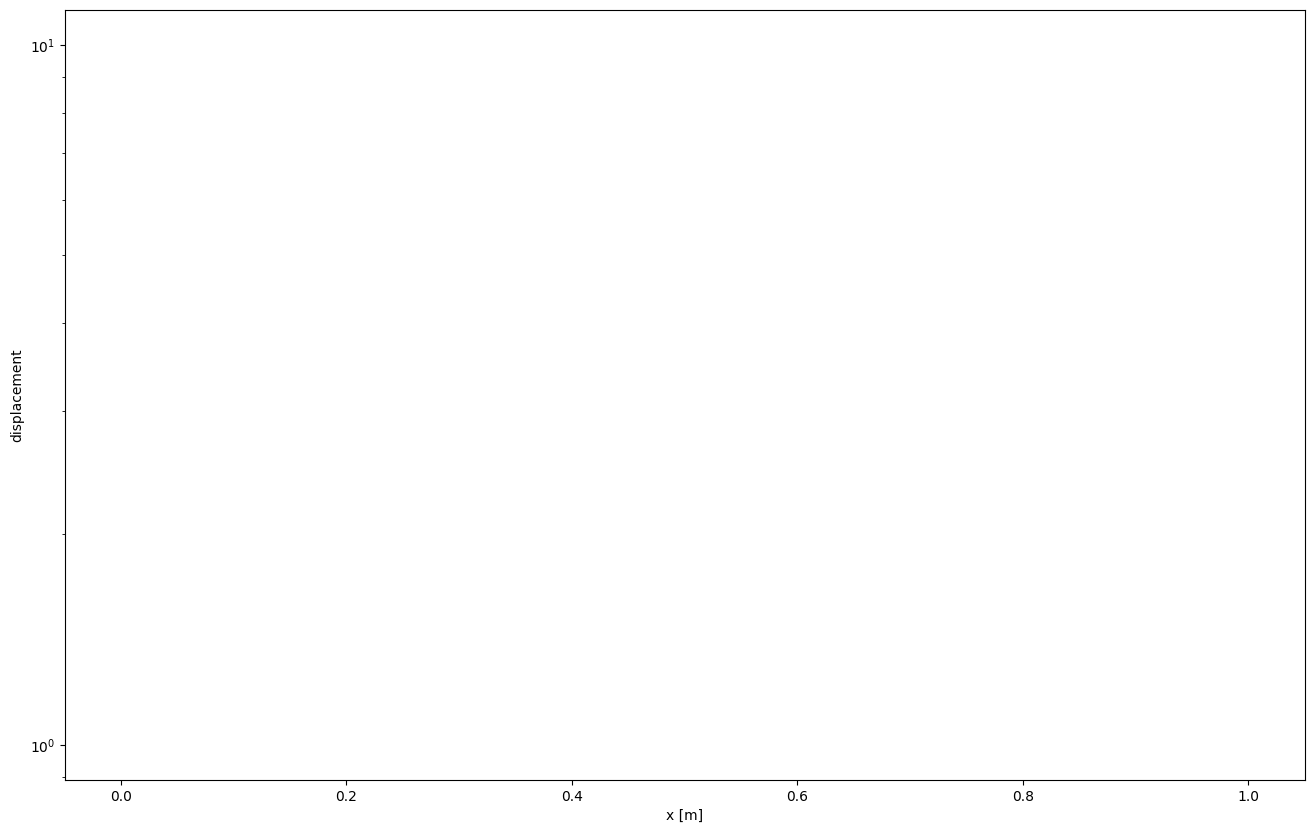

reached time t=0.0156


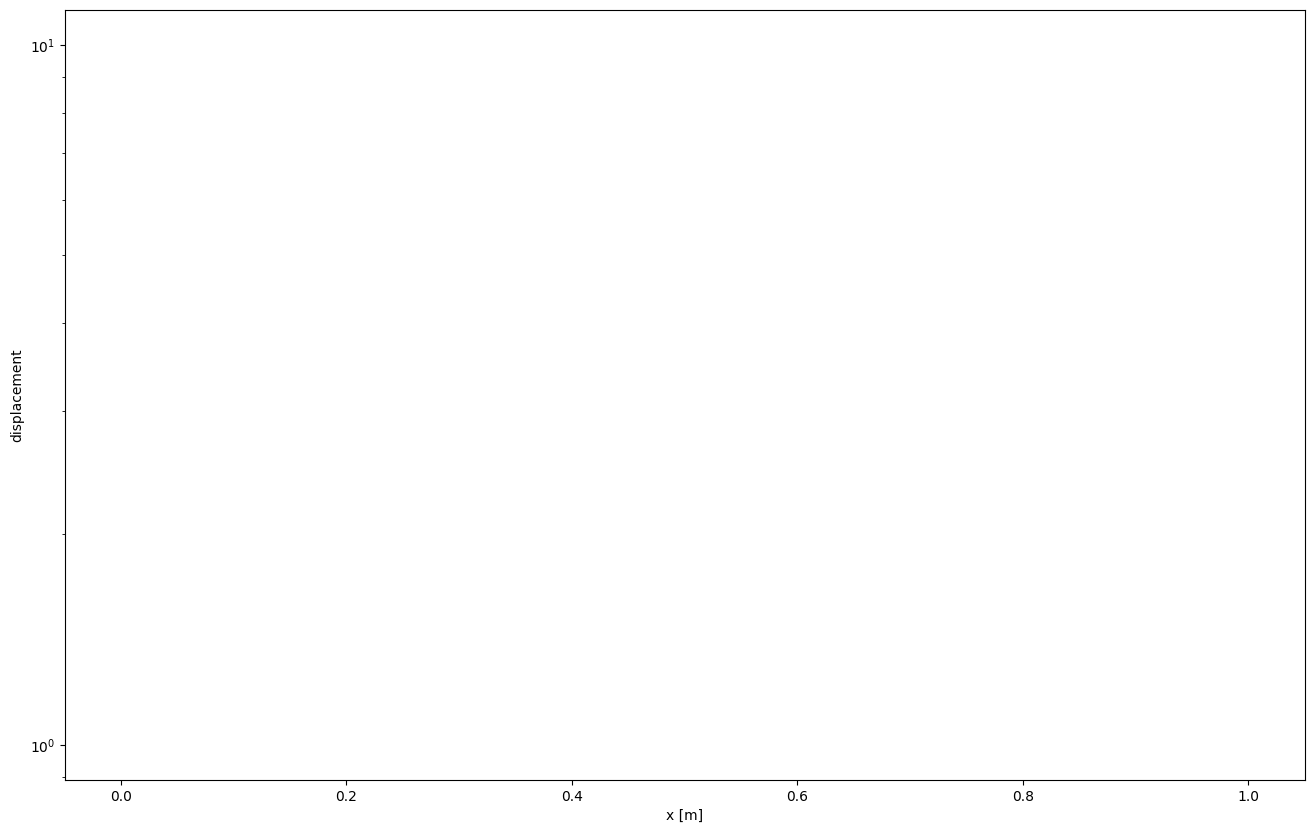

reached time t=0.015799999999999998


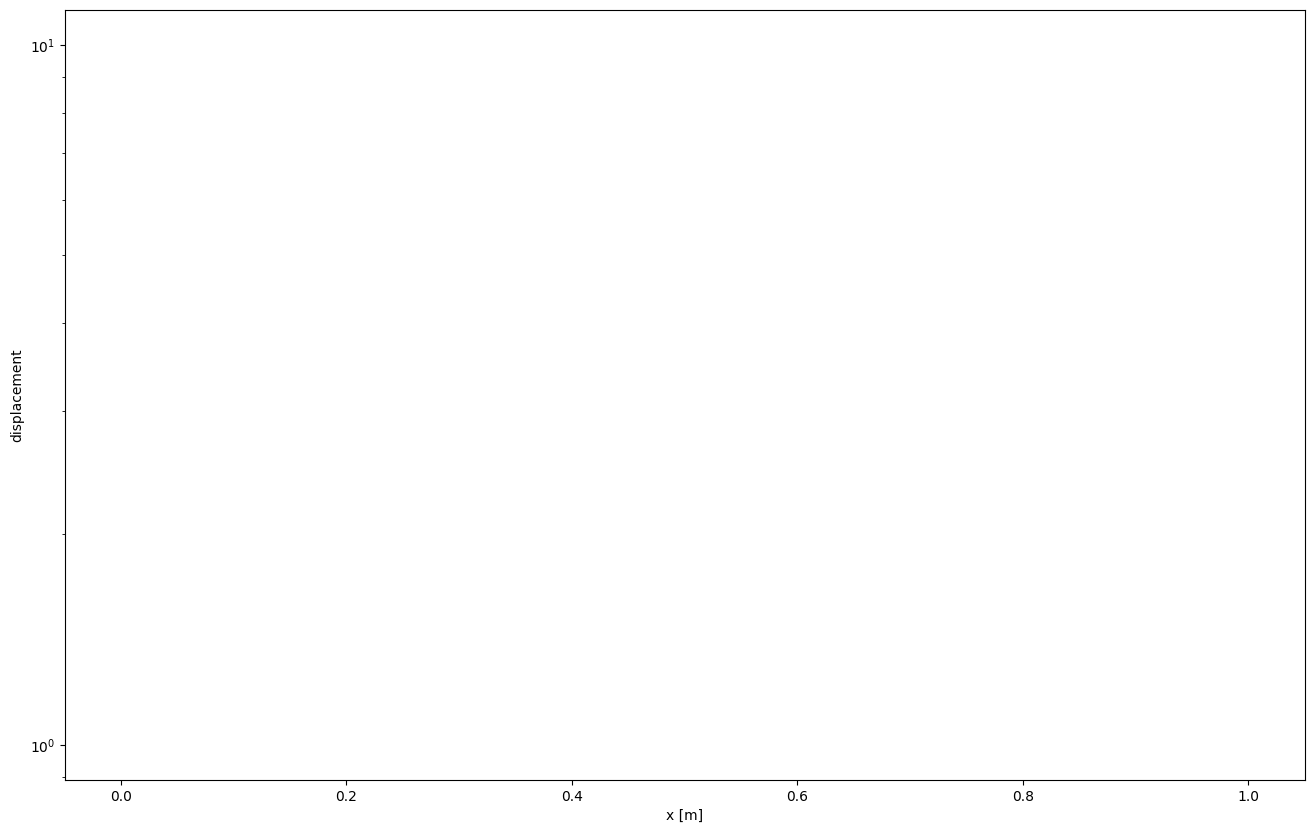

reached time t=0.016


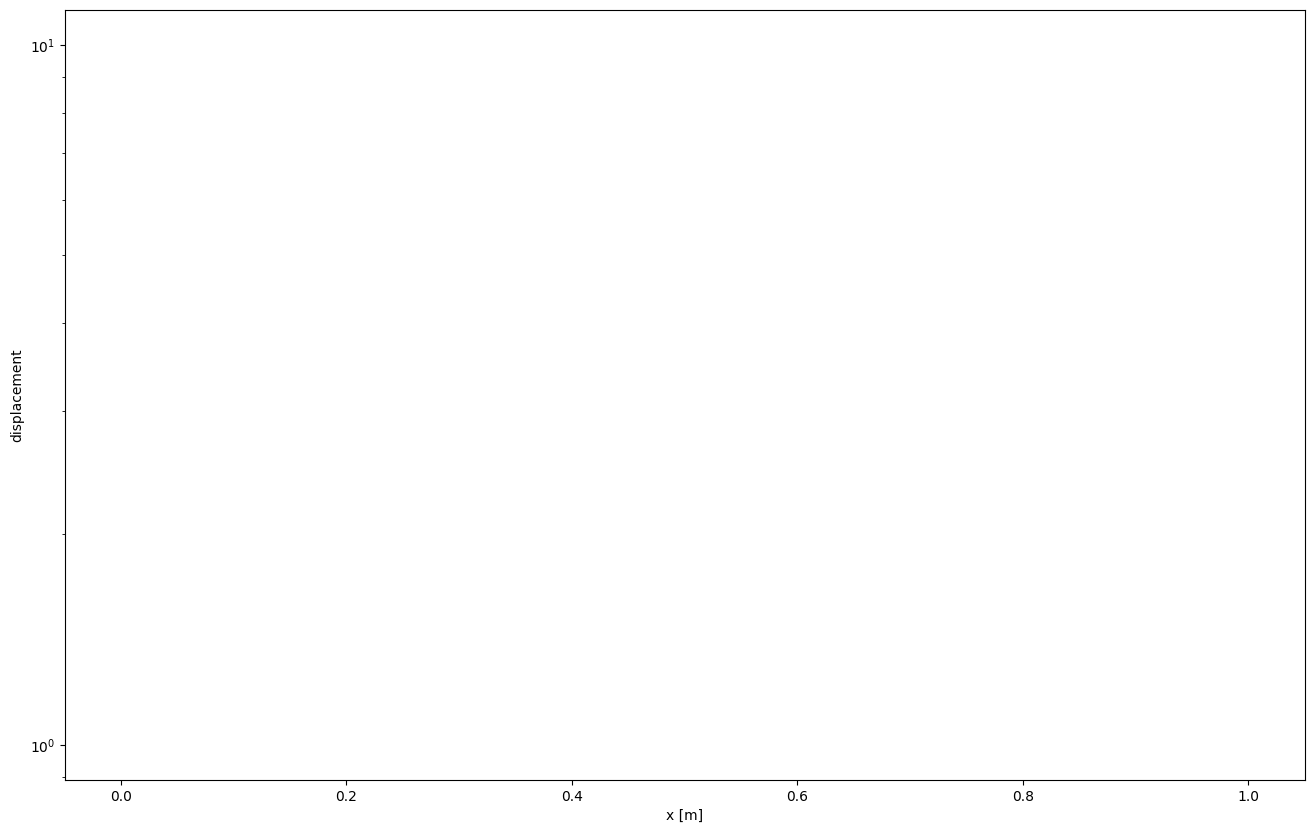

reached time t=0.0162


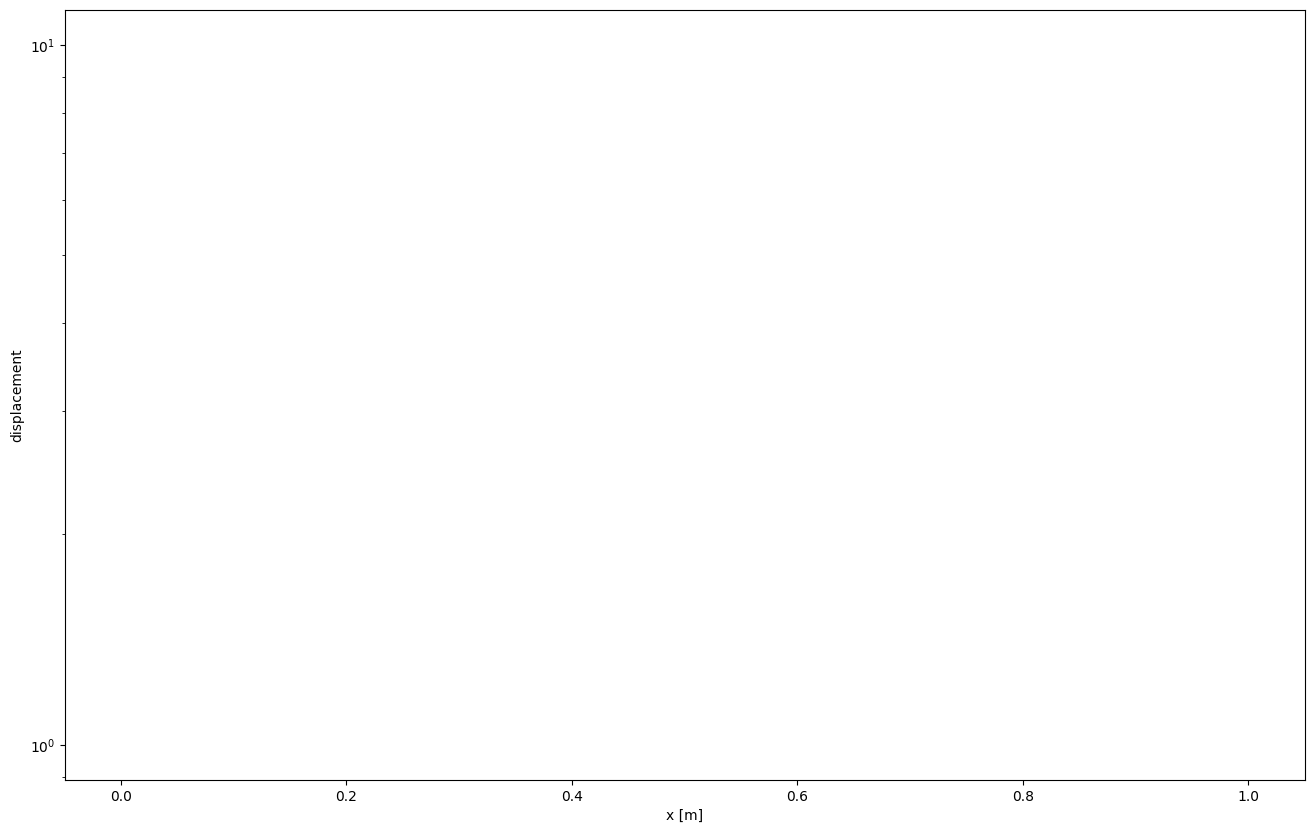

reached time t=0.016399999999999998


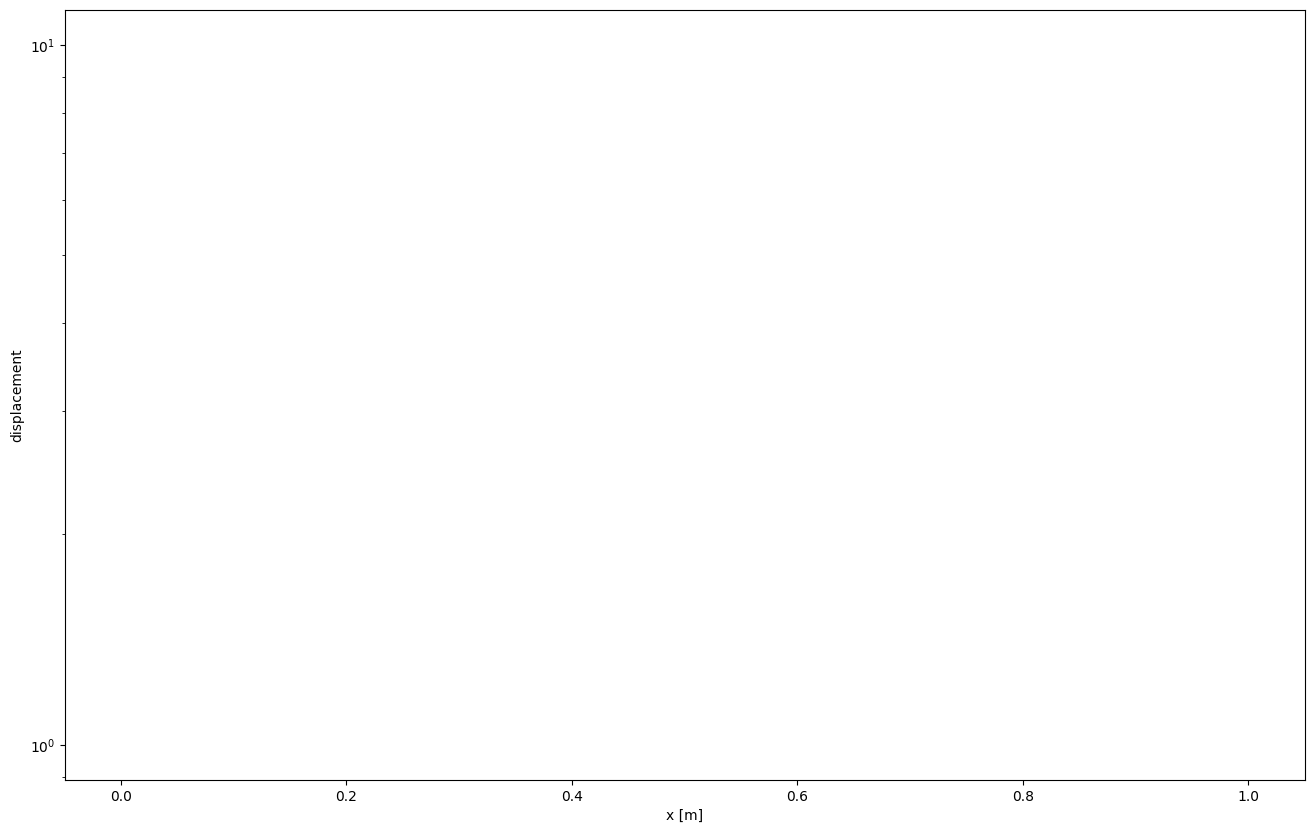

reached time t=0.0166


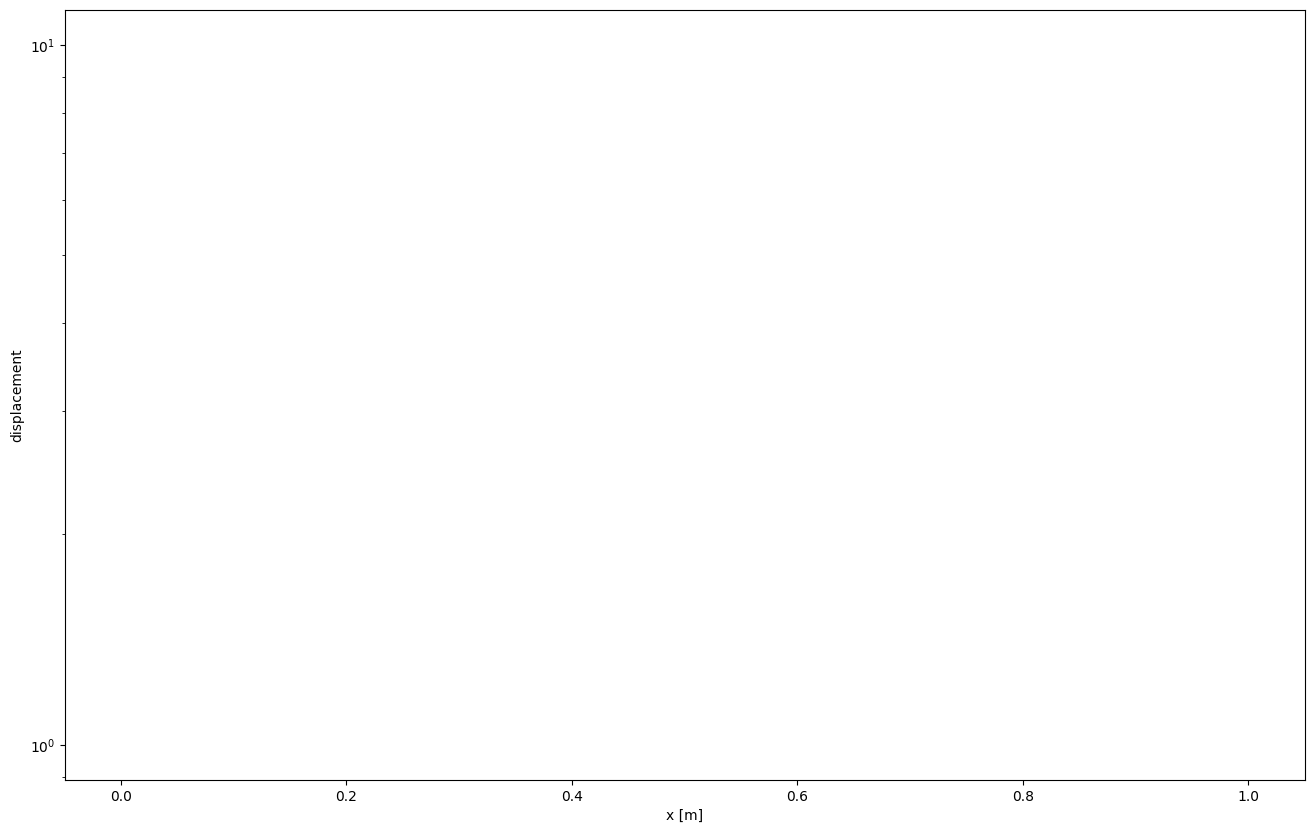

reached time t=0.0168


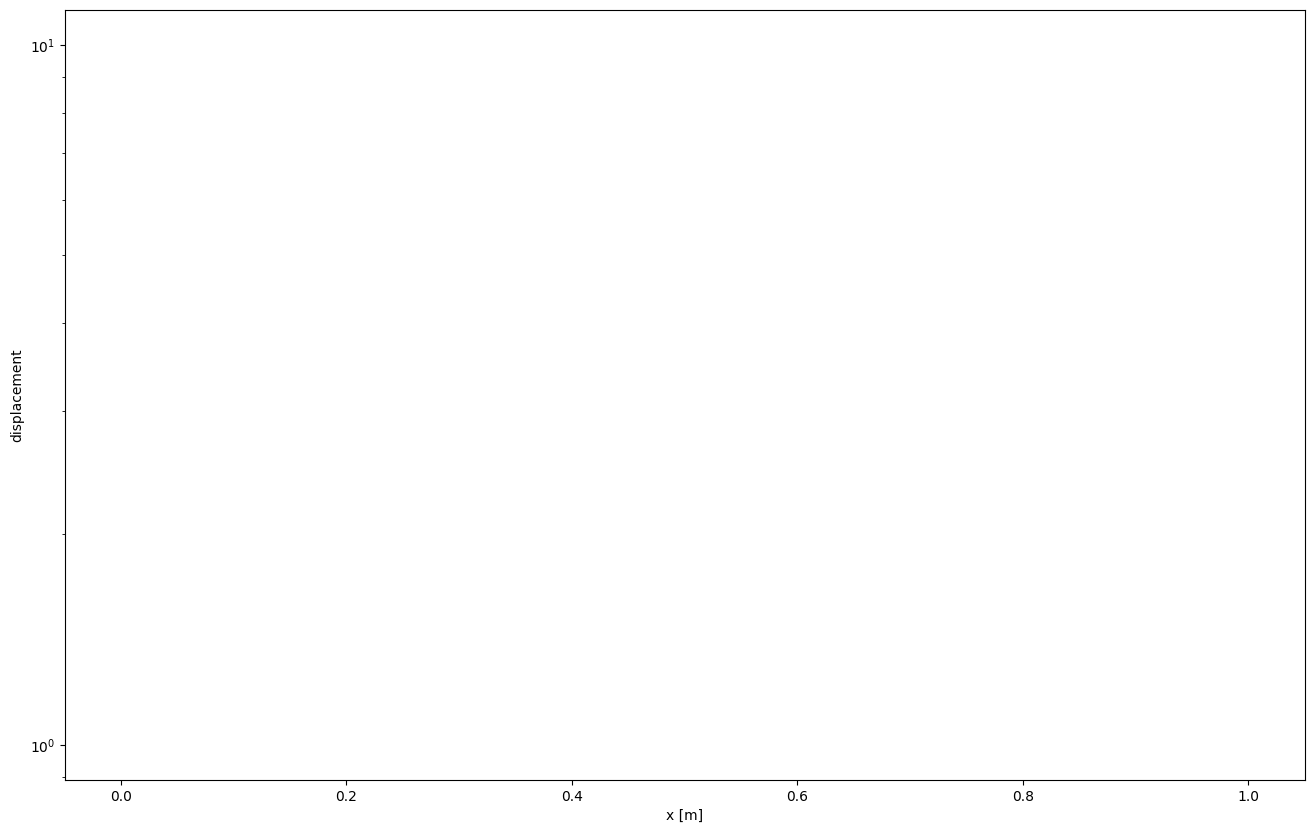

reached time t=0.016999999999999998


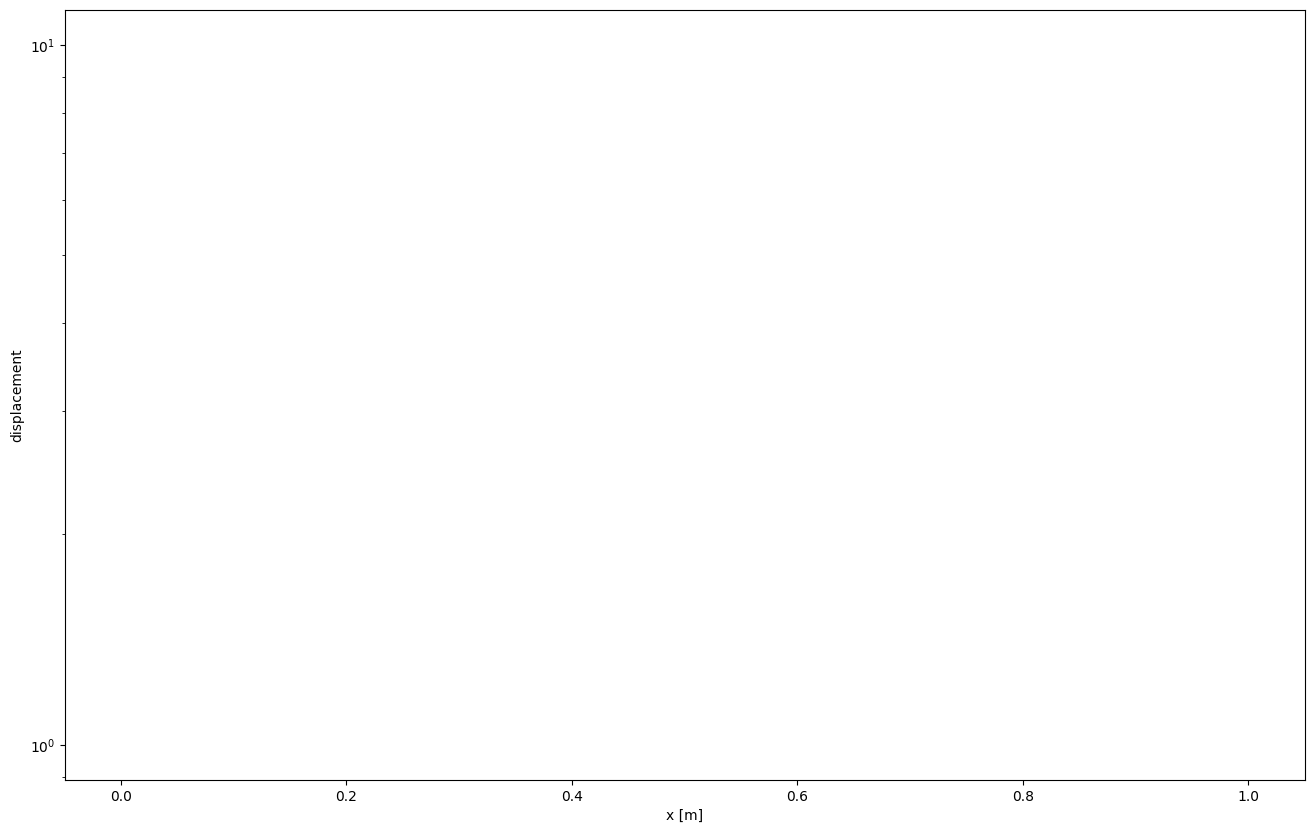

reached time t=0.0172


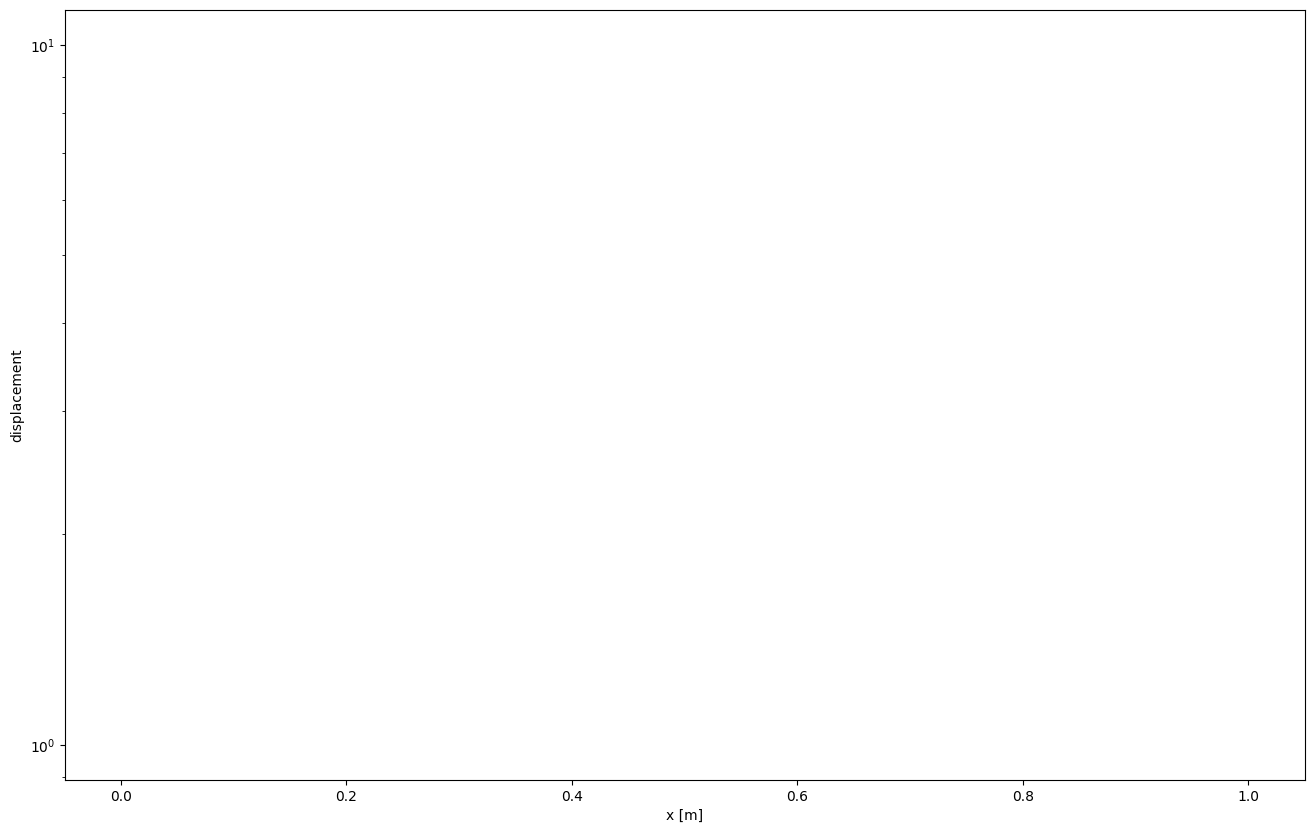

reached time t=0.0174


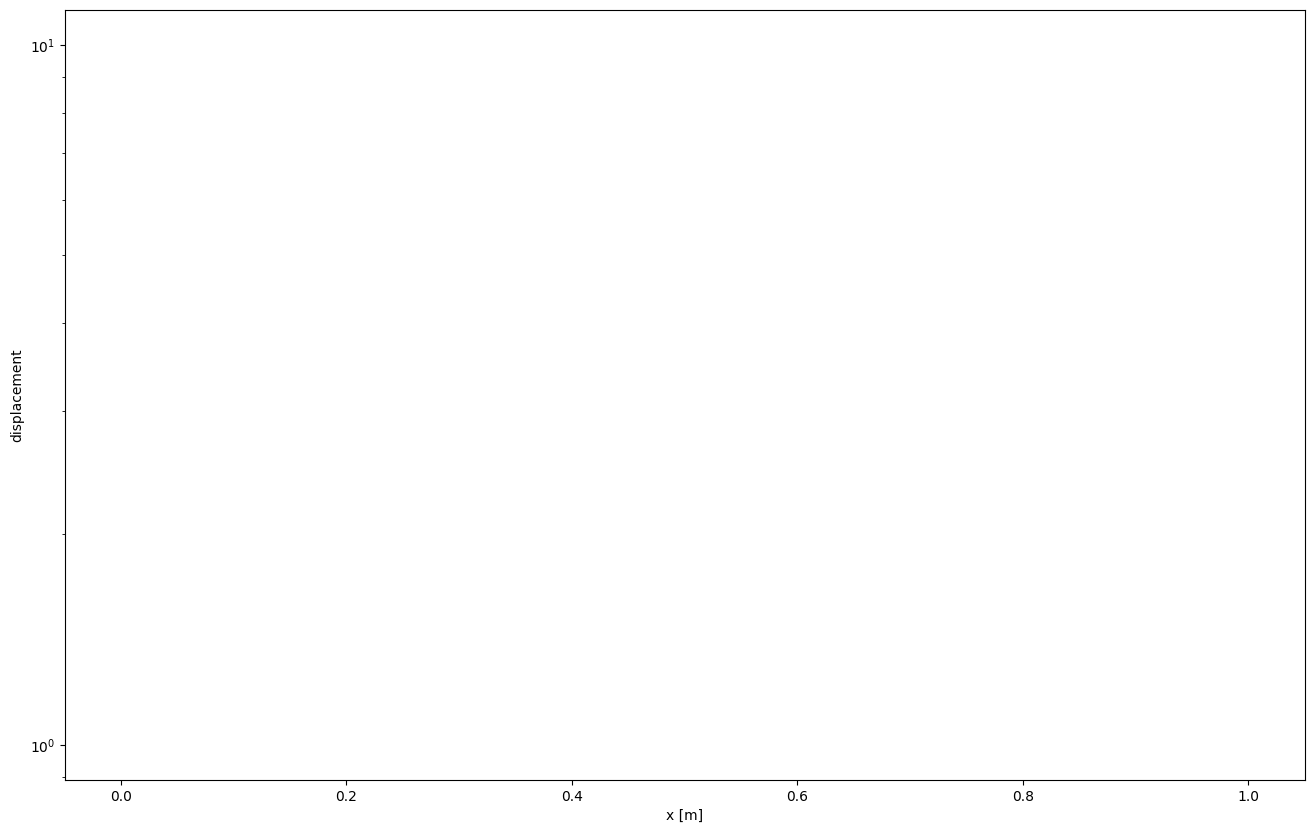

reached time t=0.017599999999999998


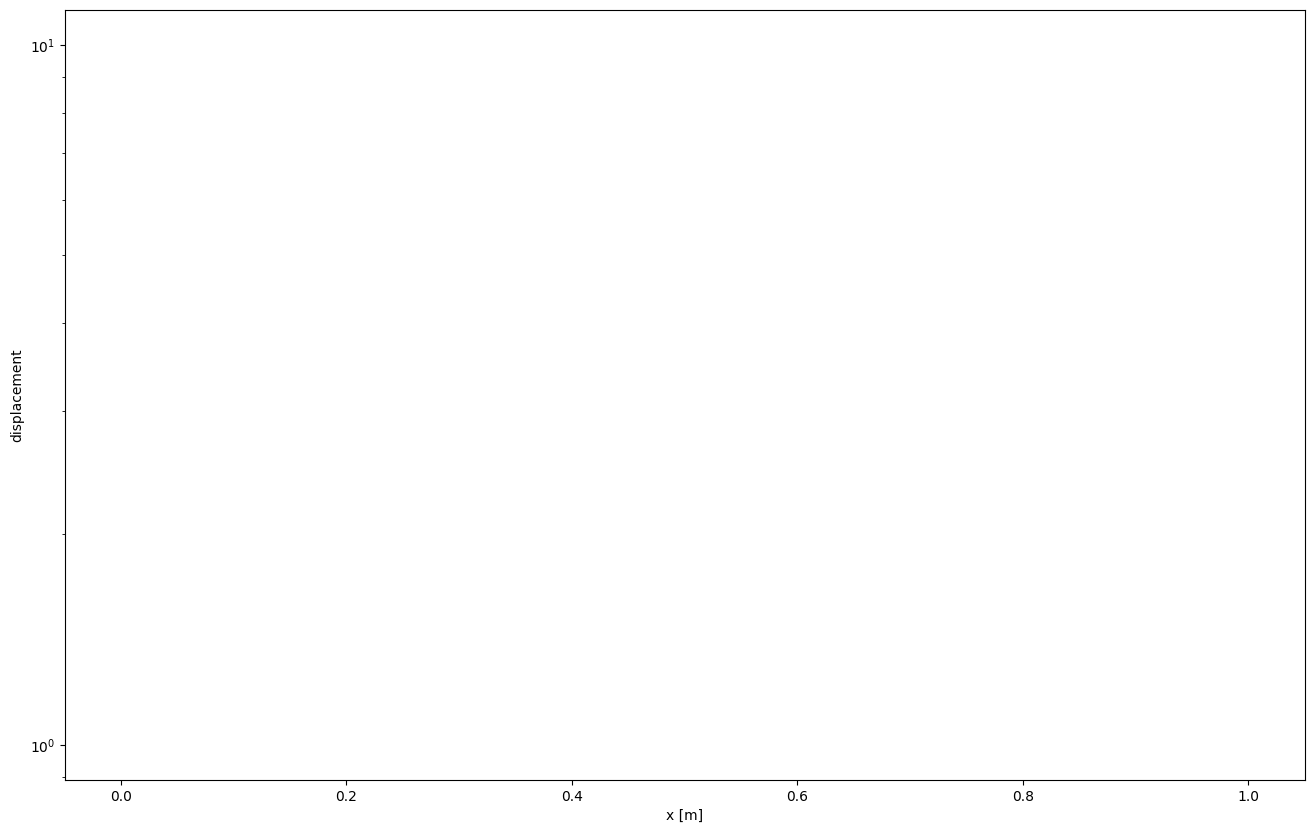

reached time t=0.0178


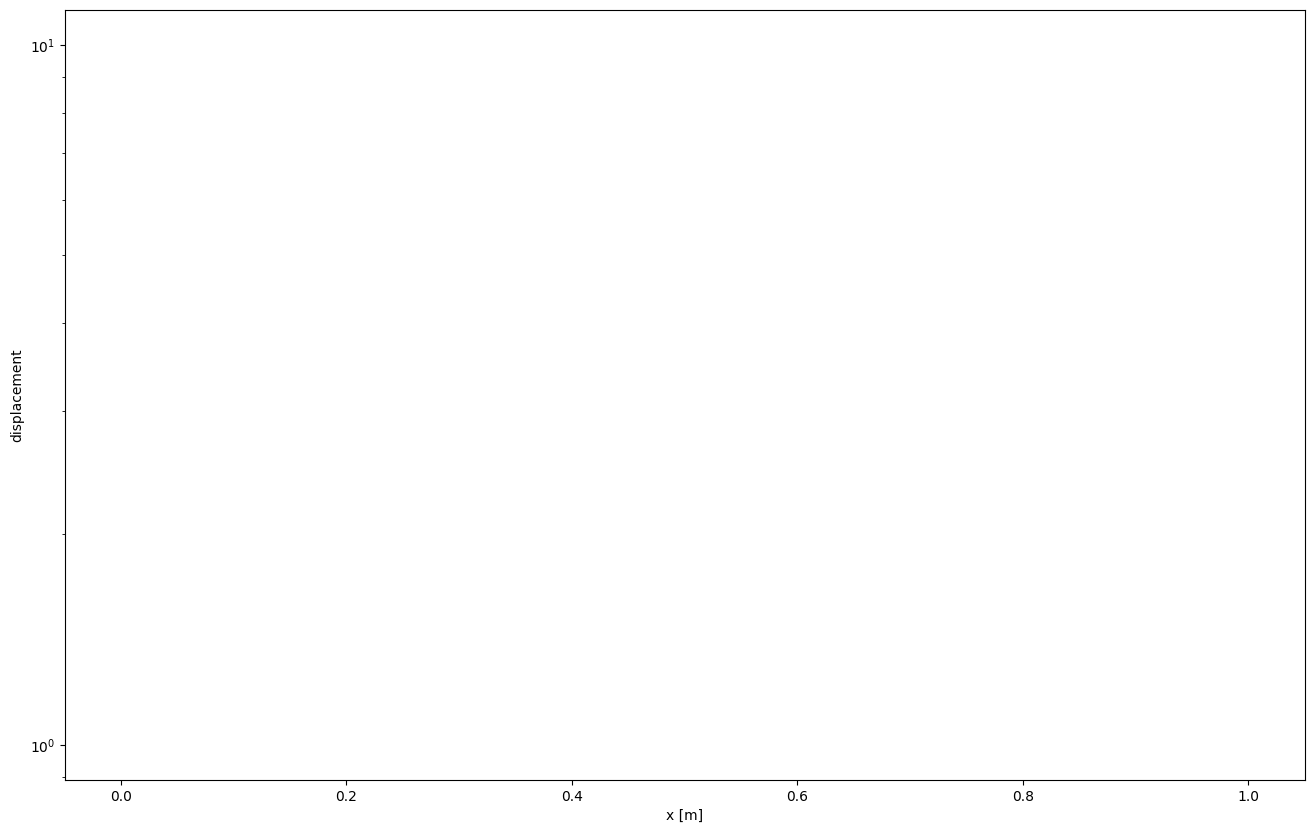

reached time t=0.018


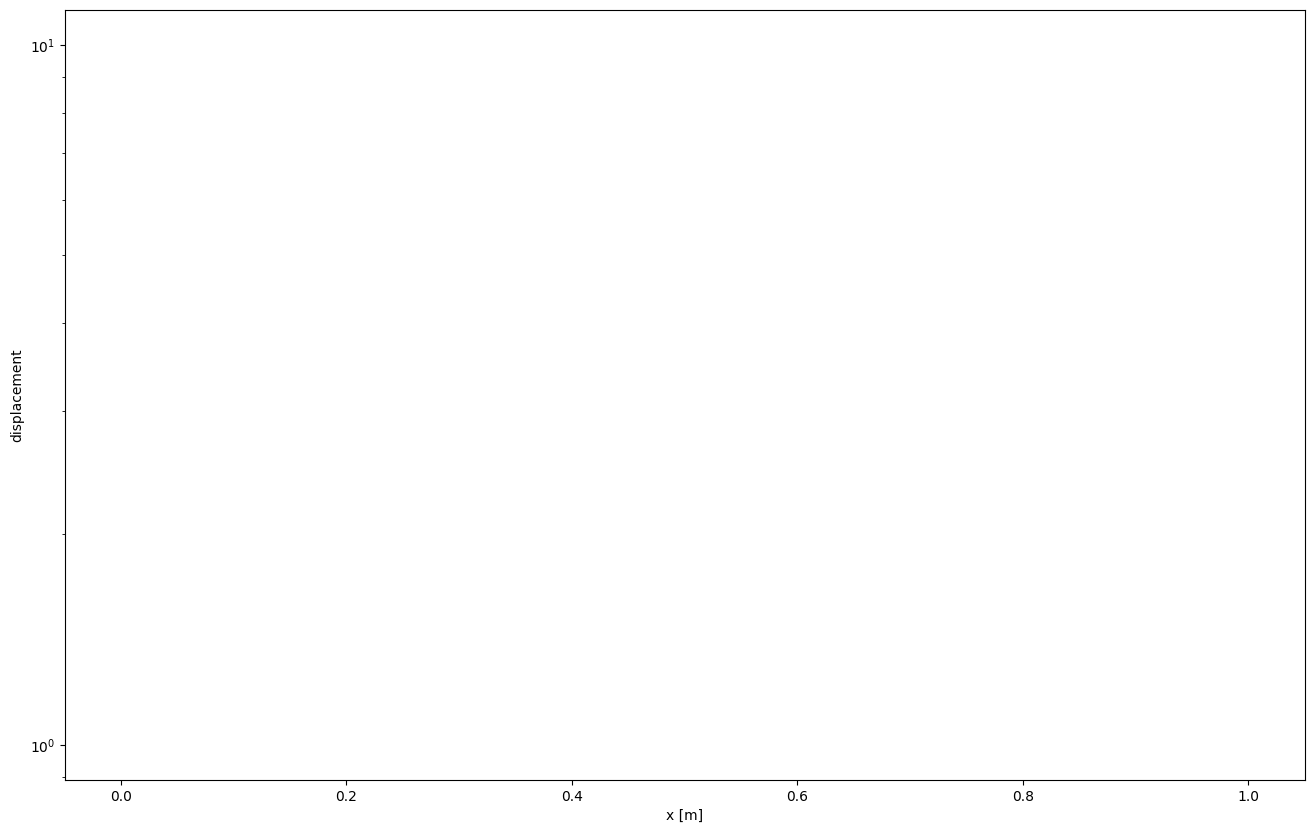

reached time t=0.0182


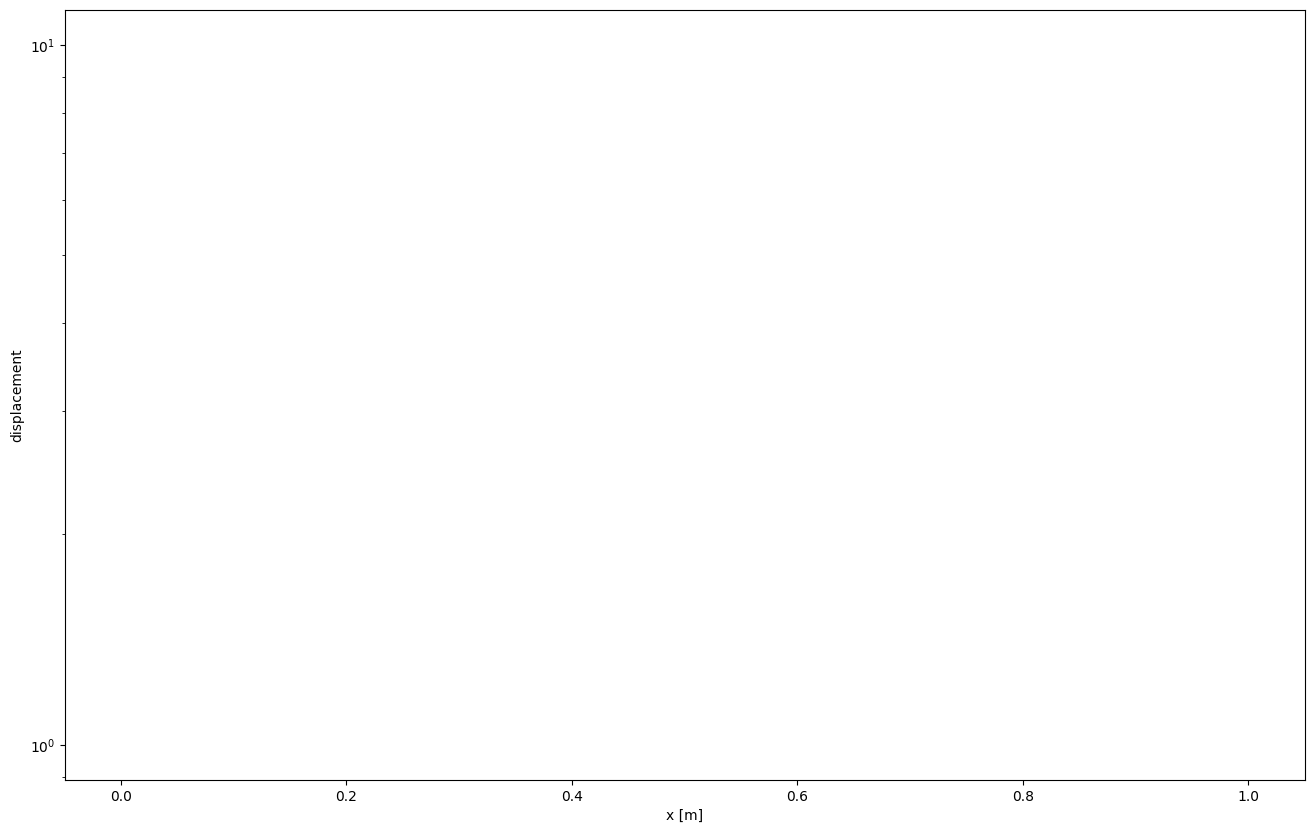

reached time t=0.0184


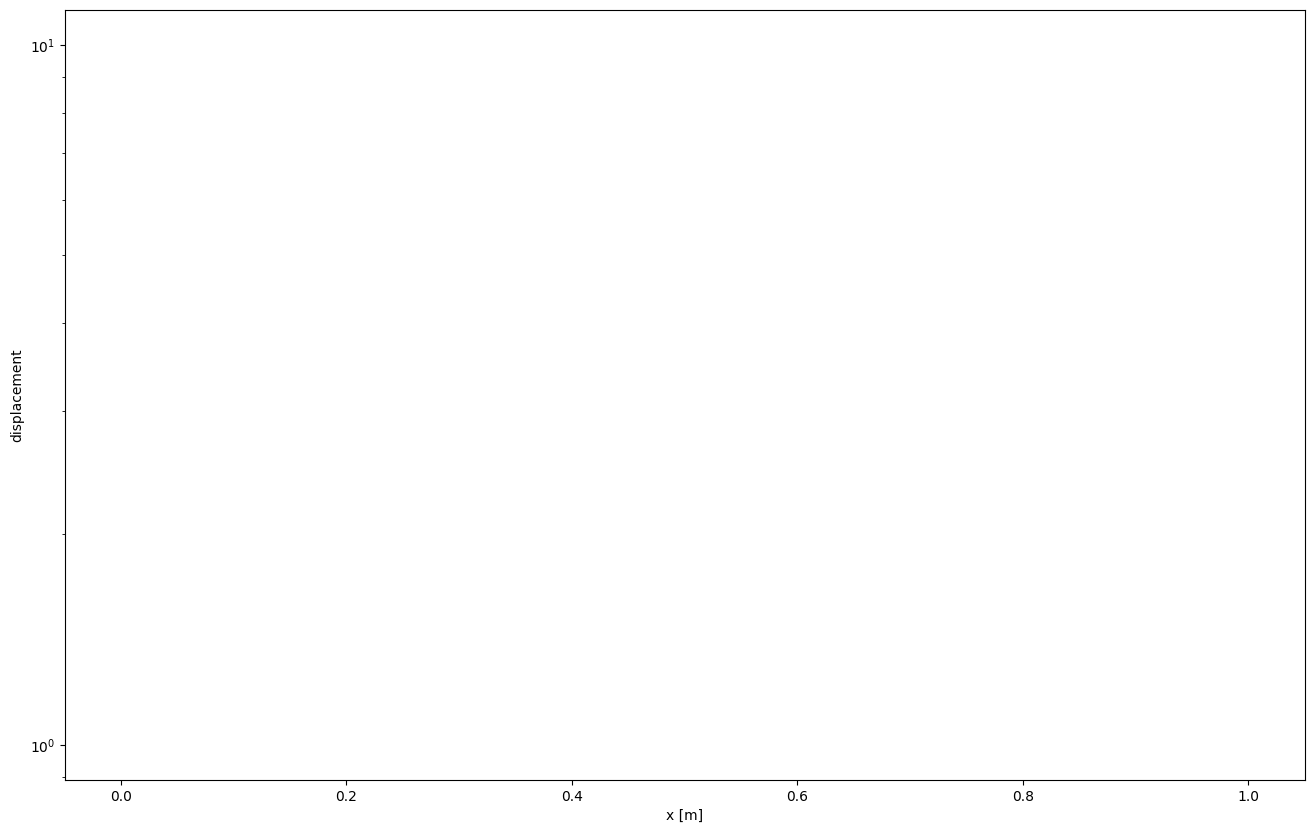

reached time t=0.0186


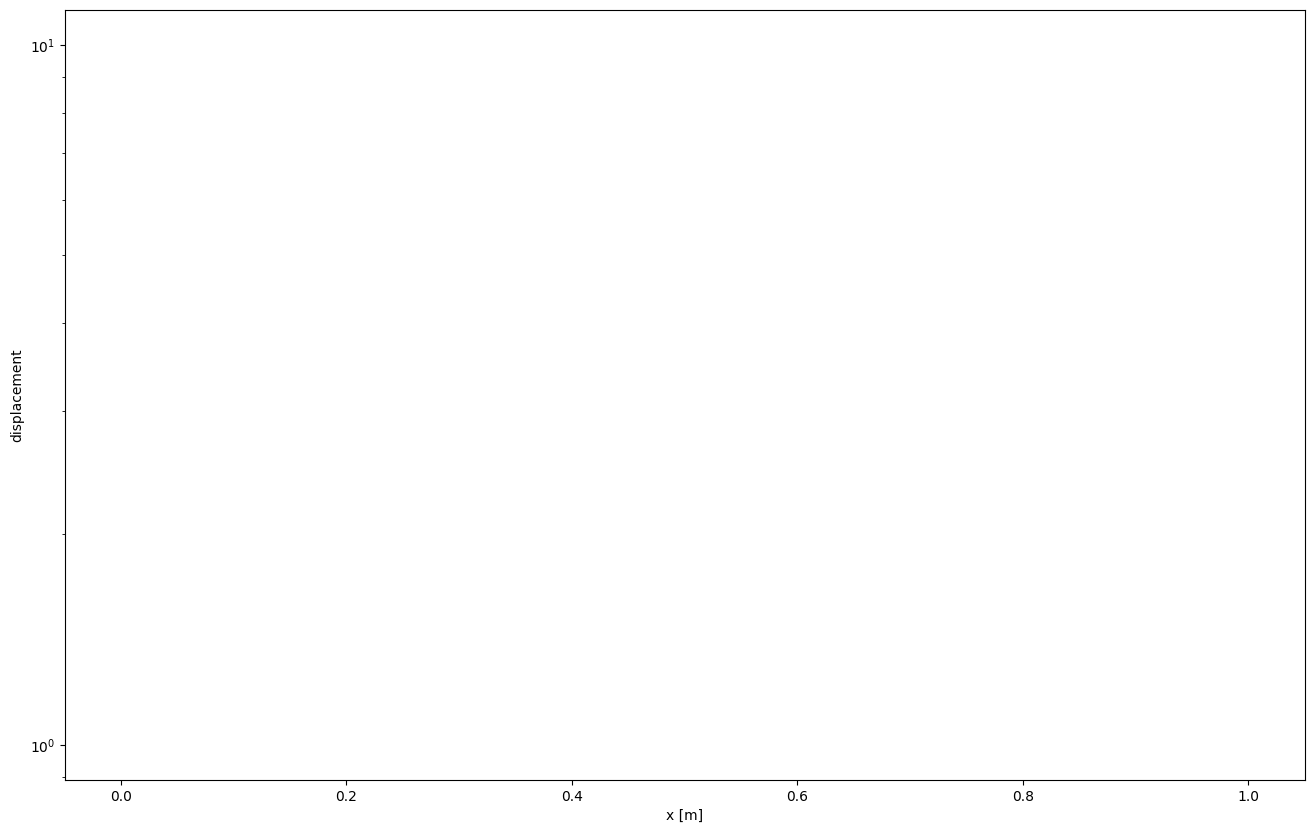

reached time t=0.0188


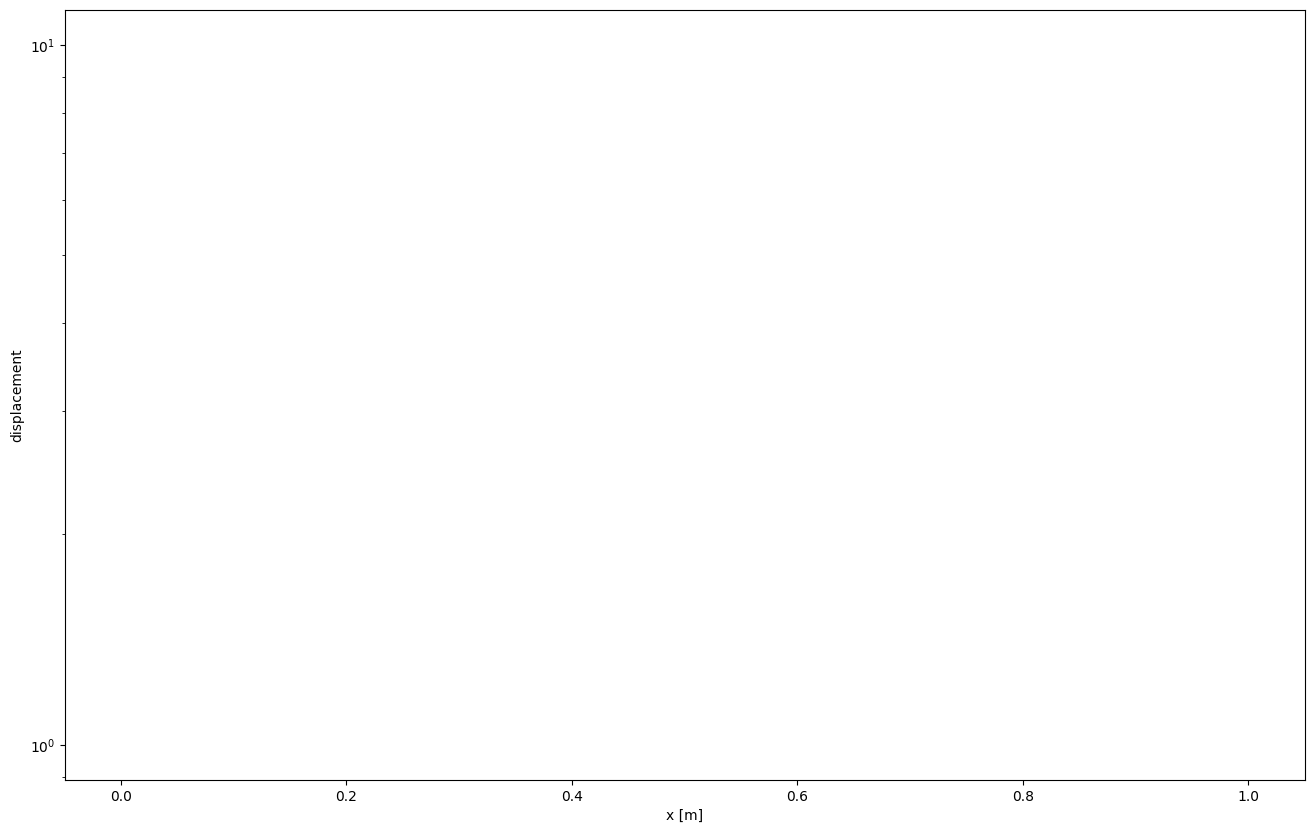

reached time t=0.019


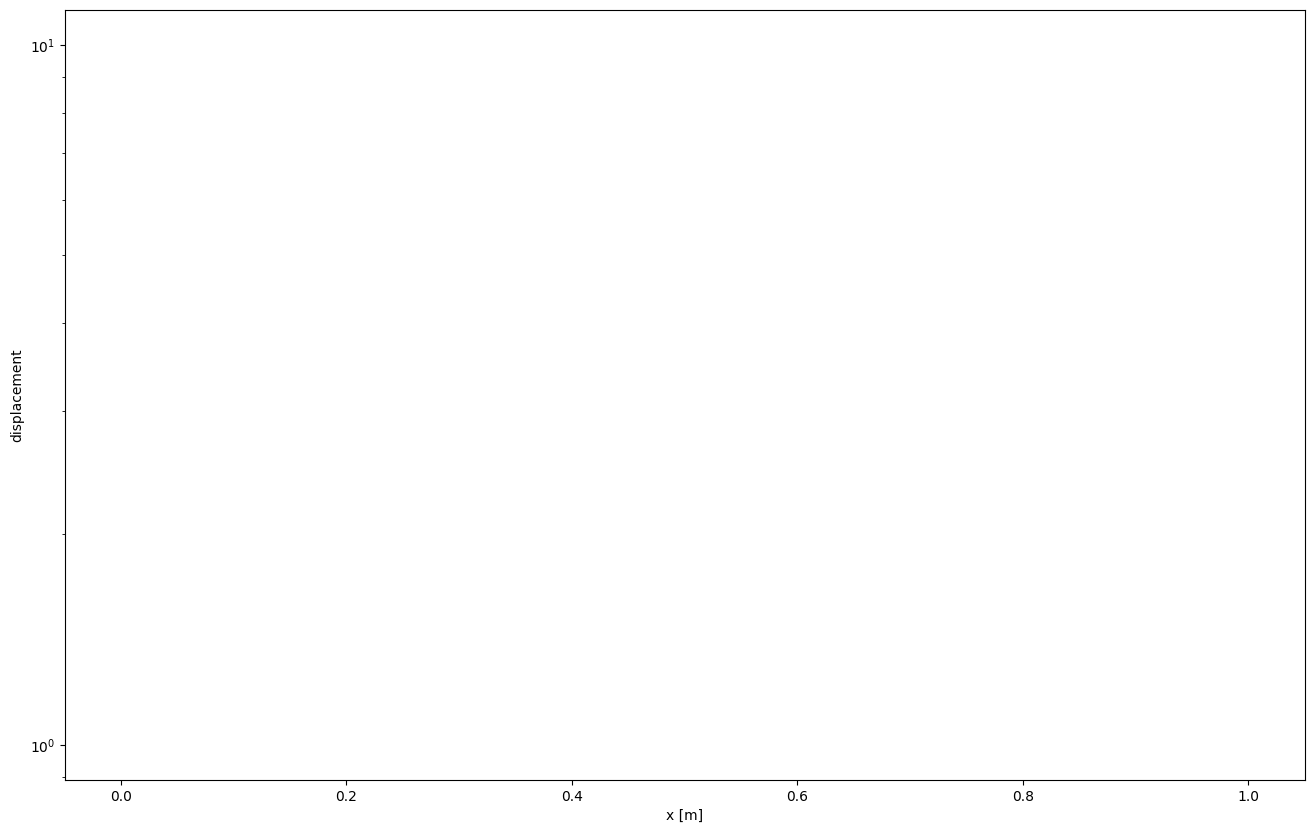

reached time t=0.0192


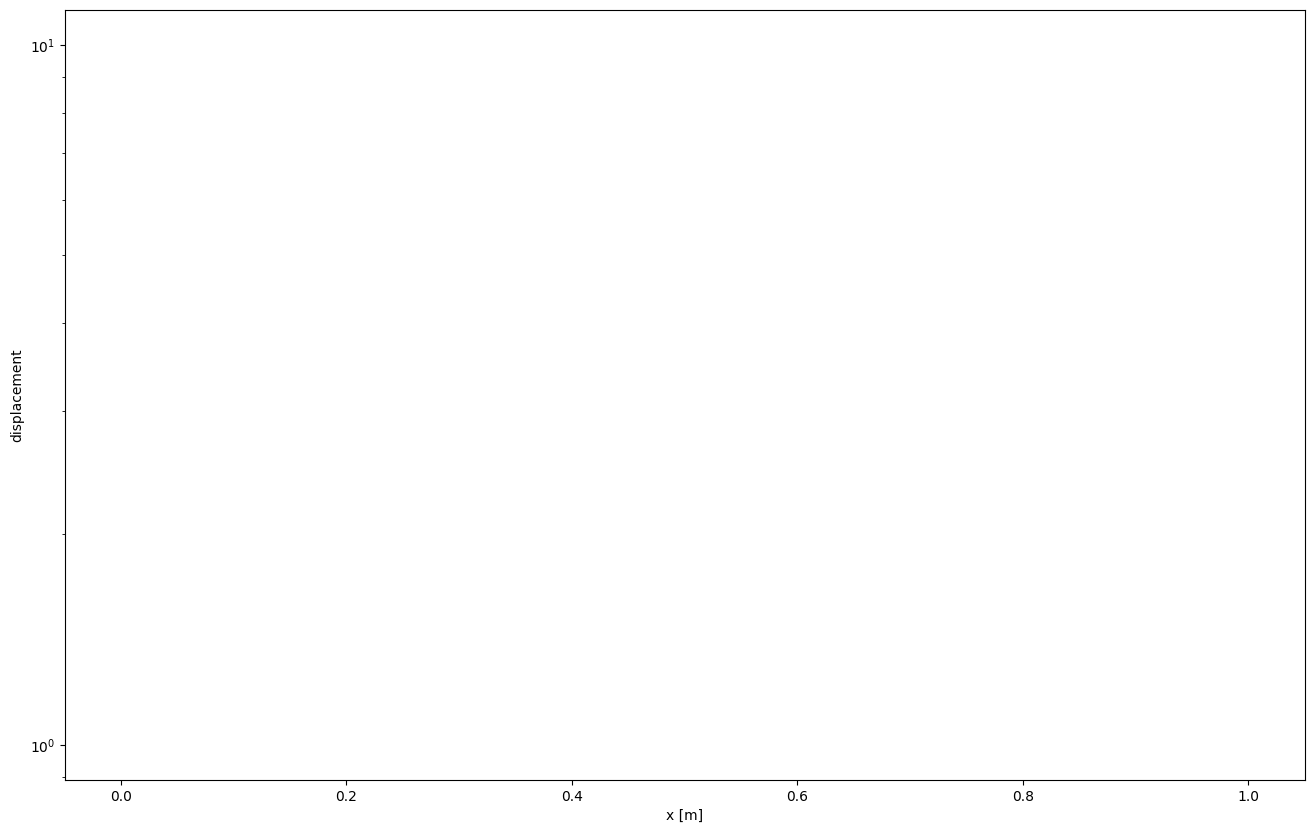

reached time t=0.0194


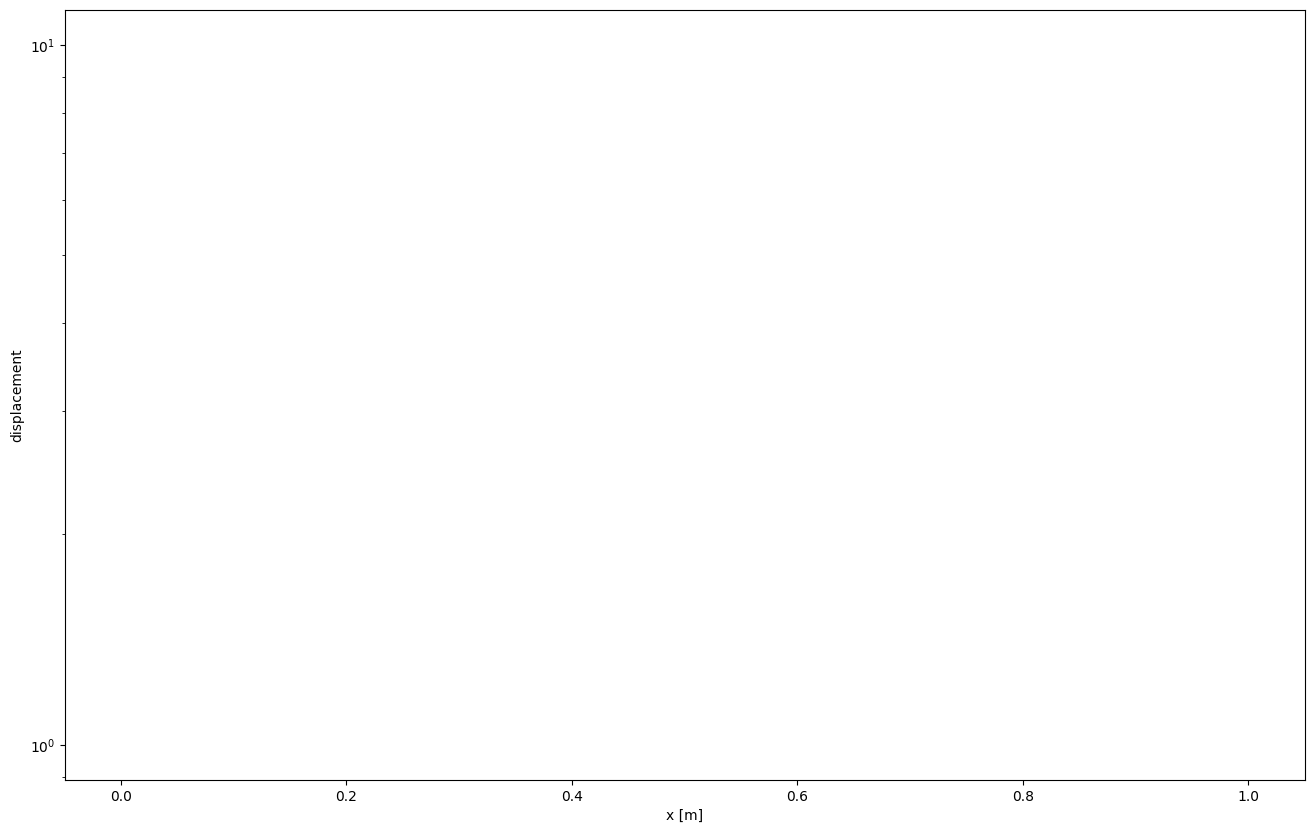

reached time t=0.0196


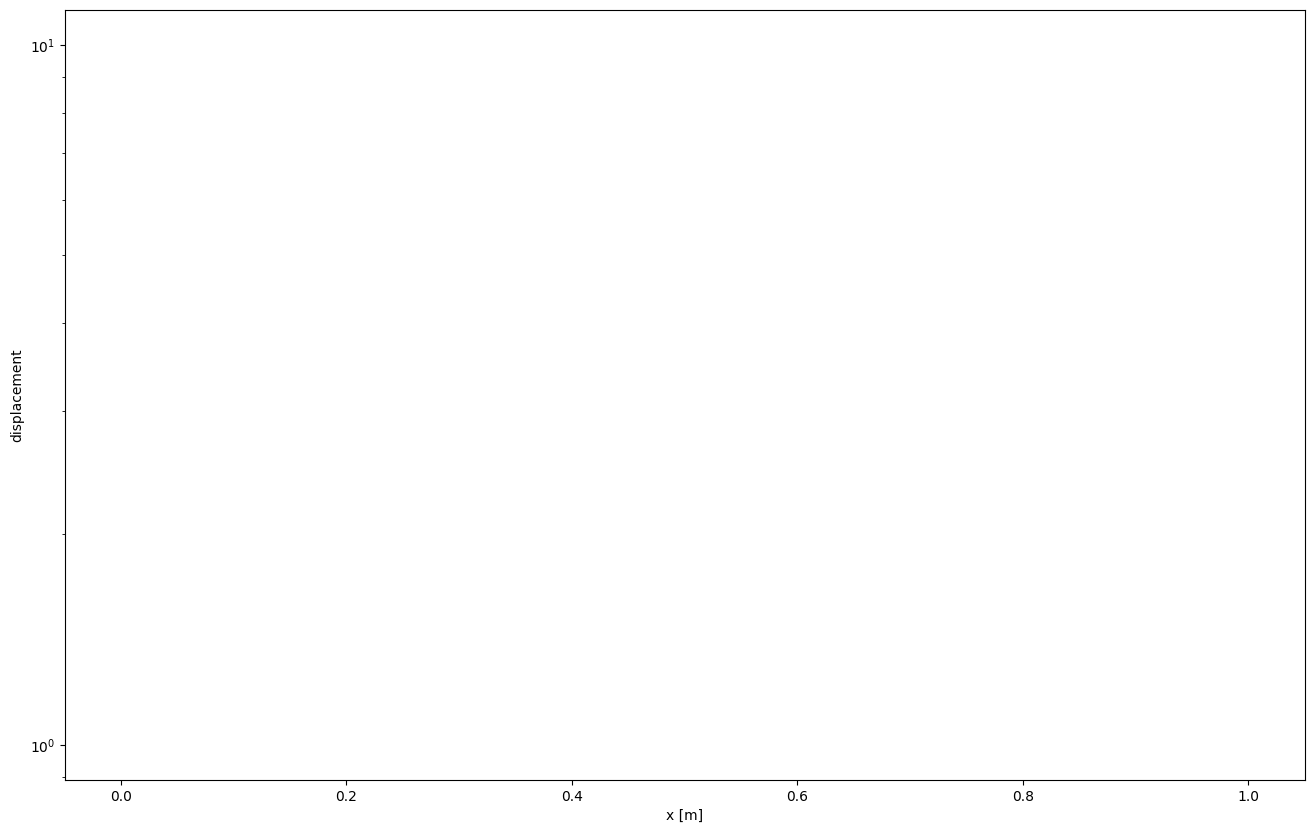

KeyboardInterrupt: 

In [14]:
# specify physical parameters
C = 1.
d = 0.1
L = 1.
sigma = 0.3
v = 100.

# specify numerical constants
NUM_X = int(5e+02)
dx = L/NUM_X
dt = h = 1.e-07

# stability criterion
top = dx ** 2
bot = 2. * L
comp = top/bot
print(h/comp)

print('dt = '+str(dt)+' s; dx = '+str(dx)+' m')

const = h * (v ** 2.) / (dx ** 2.)

# define function for initial value of wave speed
def psi0(x):
    factor = (C * x * (L - x))/(L ** 2)
    arg = ((x - d) ** 2) / (2. * (sigma ** 2))
    return (factor * np.exp(-arg))

xs = np.linspace(start=0.,stop=L,num=NUM_X)
ts = np.arange(start=0.,stop=1.e-01 - dt,step=dt)

# create arrays to store timesteps. I tried creating a meshgrid but at the resolution I am using it required >75 GB ram! Thus, I will elect to only store specific timesteps
Phi_new = Phi_old = np.zeros_like(xs)
Psi_new = Psi_old = np.zeros_like(xs)

# perscribe initial value
Psi_old = psi0(xs)

time = 0.

for n_t, t_val in enumerate(ts):
    
    Phi_new[:] = Phi_old[:] + h * Psi_old[:]

    
    if n_t % 2000 == 0:
        print('reached time t='+str(t_val))
        fig, ax = plt.subplots(figsize=(16,10))
        #print(Phi_new)
        plt.semilogy(xs, Phi_old, label='Vertical Displacement',color='navy')
        plt.semilogy(xs, Psi_old, label='time derivative of Displacement', color='y')
        plt.xlabel('x [m]')
        plt.ylabel('displacement')
        plt.show()
    
    for n_x, x_val in enumerate(xs):
        if n_x == 0 or n_x == NUM_X-1:
            continue
        Psi_new[n_x] = Psi_old[n_x] + const * (Phi_old[n_x+1] + Phi_old[n_x-1] + 2. * Phi_old[n_x])

    if t_val == 0.02:
        Phi_save = Phi_new.copy()
        Psi_save = Psi_new.copy()

    time += dt
    Phi_old = Phi_new.copy()
    Psi_old = Psi_new.copy()

fig, ax = plt.subplots(figsize=(16,10))
print(Phi_new)
plt.plot(xs, Phi_save, label='Vertical Displacement',color='navy')
plt.plot(xs, Psi_save, label='time derivative of Displacement', color='y')
plt.xlabel('x [m]')
plt.ylabel('displacement')
plt.show()




#### (b) FTCS (Forward-time, Centered-spatial) Integration method: Numerical Stability

## Problem 4
### Application question:

Numerical integration of any Hamiltonian physical system should obey the property that energy is conserved. This is acheived by implementing higher order methods and calculating the error explicitly throughout the execution of the integration. In other words, there are methods like Euler's which approximately conserve energy, however they do not do so exactly. In, e.g., the Euler method, the solution can be drawn closer and closer to energy-conserving by lowering the step size of the integration, but there is no framework within the routine enforcing the conversion of energy. In other semi-explicit or implicit methods, energy can be approximately conserved for ALL time. More specifically, the Hamiltonian itself is not conserved, but a quasi-Hamiltonian equivalent to the true one plus additional terms expanded in powers of the step size (the degree of which is based on the order of the method) is exactly conserved. For most numerical applications, you can only estimate the difference between the true Hamiltonian and the quasi-Hamiltonian which is exactly conserved, but it is normally possible to show that the difference between the two is not large, provided the method and numerical parameters are chosen carefully.  

Any physical system with no external forcing/interactions should conserve energy fundamentally. In some applications (e.g., thermodynamics) this is more important to be precise with than others (e.g., fluid dynamics), assuming the energy is approximately conserved in both cases. I would implement a leapfrog / semi-implicit method to ensure that energy is approximately conserved, since that method (with proper parameter selection) can guarantee that a quantity approximately equal to the energy is EXACTLY conserved. As discussed above, it may even be possible to estimate the error between the two Hamiltonians and further refine the solution. However, the exact conservation of energy is not always the most important quantity to be concerned with. In certain settings (e.g. space plasma simulations) it can be advantageous to _relax_ the energy conservation requirement, allowing for large performance boosts. Since the ions are traced kinetically in this code, and the domain is highly distributed across many processes, the macroparticles (representing an ensemble in phase space) are constantly merged and split into sub/super particles, during which it is expensive to exactly conserve energy; this is because particle motion may excite wave energy which is later dissipated. This is exemplified for the hybrid plasma code in section 7.2 of [this paper](https://www.sciencedirect.com/science/article/pii/S0010465510005266). In this case, the methods which only approximately conserve energy perform much more efficiently and have lower implementation risk, while reproducing the same physical features. 